## Useful libraries

In [138]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import torch_geometric
import sklearn

In [139]:
## TODO: https://medium.com/math-simplified/checking-for-linear-dependence-in-sympy-9776b66dbe75

## Utility functions

In [140]:
def categorize_columns(df, columns):
    for column in columns:
        df[column] = df[column].astype("category")
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    return df

In [141]:
def z_scale(df_z_scaled, columns): ## is a bit better for neural networks
    # for column in columns:
    #     df_z_scaled[column] = (df_z_scaled[column] - df_z_scaled[column].mean()) / df_z_scaled[column].std()   
    return df_z_scaled

In [142]:
from pandas.api.types import is_numeric_dtype
def remove_uninformative_columns(df, columns):
    ## removes categorcial columns where we have no duplicates (i.e., columns with all different categorical values like ids)
    filtered_columns = []
    for column in columns:
        all_values_in_column_identical = df[column].unique().shape[0] < 2
        if all_values_in_column_identical:
            continue
        category_has_duplicates = df.duplicated(subset=column).sum()> 0 ##is informative
        if category_has_duplicates or is_numeric_dtype(df[column]) :
            filtered_columns.append(column)
    return filtered_columns

In [143]:
import torch
def reverse_edge_index(torch_tensor):
    reversed_torch_tensor = torch.zeros_like(torch_tensor)
    reversed_torch_tensor[:, 0] = torch_tensor[:, 1]
    reversed_torch_tensor[:, 1] = torch_tensor[:, 0]
    return reversed_torch_tensor

## What we need
- Gene node feature #genes x #features
- Model node feature #models x features (for now includes drug inofrmation and the drug IC50 target for simplicity) (more complicated than I expected)
  -> later edge attribute prediction?
- Gene_model_edge_index_cn #edges x 2
- Gene_model_edge_index_mutations #edges x 2
- Gene_model_edge_index_geneexpressions #edges x 2
- Gene_model_edge_attributes_cn #edges x #attributes
- Gene_model_edge_attributes_mutations #edges x #attributes
- Gene_model_edge_attributes_geneexpressions #edges x #attributes

  Het-GAT for regression task with MSE as loss

## Read human genome

In [144]:
human_genome = pd.read_csv("human_genome.tsv", sep="\t", header=None) ## merging via gene symbol
human_genome["human_genome_index"] = human_genome.index
human_genome.head()

,0,1,2,3,human_genome_index
0,hsa:102466751,miRNA,1:complement(17369..17436),"MIR6859-1, hsa-mir-6859-1; microRNA 6859-1",0
1,hsa:100302278,miRNA,1:30366..30503,"MIR1302-2, MIRN1302-2, hsa-mir-1302-2; microRN...",1
2,hsa:79501,CDS,1:65419..71585,OR4F5; olfactory receptor family 4 subfamily F...,2
3,hsa:102465909,miRNA,1:complement(187891..187958),"MIR6859-2, hsa-mir-6859-2; microRNA 6859-2",3
4,hsa:112268260,CDS,1:complement(365134..382235),uncharacterized LOC112268260,4


## Get gene symbols to human genome index dataframe (is in nested list semicolon, comma separated)

In [145]:
def get_gene_idx_to_gene_symbol(human_genome):
    sem_split = human_genome[3].str.split("; ")
    comma_split = sem_split.map(lambda n: n[0]).str.split(",")
    exploded_gene_symbols = comma_split.explode().str.strip().to_frame()
    exploded_gene_symbols = exploded_gene_symbols.rename(columns={3:"symbol"})
    exploded_gene_symbols["human_genome_index"] = exploded_gene_symbols.index
    exploded_gene_symbols = exploded_gene_symbols.reset_index(drop=True)
    return exploded_gene_symbols

In [146]:
gene_idx_to_gene_symbol_df = get_gene_idx_to_gene_symbol(human_genome)

## Generate nodes features for gene nodes

In [147]:
def get_gene_features(human_genome):
    categorize_columns(human_genome, human_genome.columns[:3])
    z_scale(human_genome, human_genome.columns[:3])
    gene_features = human_genome.loc[:, :2].values
    return gene_features

In [148]:
gene_features = get_gene_features(human_genome)

In [149]:
gene_features.shape

(24689, 3)

## Generate node features for models (with target) and target labels

In [150]:
targets = pd.read_csv("target.csv",sep=";")
models = pd.read_csv("model_list_20240110.csv")
models.head()

,model_id,sample_id,patient_id,parent_id,model_name,synonyms,tissue,cancer_type,cancer_type_ncit_id,tissue_status,...,msh6_expression_by_ihc,braf_mutation_identified,braf_expression_by_ihc,pik3ca_mutation_identified,pten_expression_by_ihc,pten_mutation_identified,kras_mutation_identified,mismatch_repair_status,preoperative_ce_alevel,crispr_ko_data
0,SIDM01774,SIDS01659,SIDP01578,NaN,PK-59,NaN,Pancreas,Pancreatic Carcinoma,C3850,Metastasis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,SIDM00192,SIDS00612,SIDP00541,NaN,SNU-1033,NaN,Large Intestine,Colorectal Carcinoma,C9383,Tumour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,SIDM01447,SIDS01466,SIDP01347,NaN,SNU-466,NaN,Central Nervous System,Glioblastoma,C3058,Tumour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,SIDM01554,SIDS01363,SIDP01247,NaN,IST-MES-2,NaN,Lung,Mesothelioma,C45662,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,SIDM01689,SIDS01631,SIDP01557,NaN,MUTZ-5,NaN,Haematopoietic and Lymphoid,B-Lymphoblastic Leukemia,C8644,Tumour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [151]:
def get_transformed_merged_drug_model_df(models, targets):
    columns_with_most_val_filled = models.columns[models.isnull().sum(axis=0)/ models.shape[0] <= 0.1]
    filtered_columns = remove_uninformative_columns(models, columns_with_most_val_filled) ##all categorical
    filtered_columns.append("model_id") ## required for later join
    print(filtered_columns)
    models = models[filtered_columns].fillna("Unkown")
    columns_besides_id = list(filter(lambda x: x != "model_id", filtered_columns))
    models = categorize_columns(models, columns_besides_id)
    z_scale(models, columns_besides_id)
    models = models.rename(columns={"model_id":"SANGER_MODEL_ID"}) ##rename for join
    limited_drug_target = targets[targets["DRUG_ID"] == 1803] ##filter specific drug #1862
    limited_drug_target_filtered = limited_drug_target.loc[:, ["CELL_LINE_NAME", "SANGER_MODEL_ID", "MIN_CONC", "LN_IC50"]]
    limited_drug_target_filtered = categorize_columns(limited_drug_target_filtered, ["CELL_LINE_NAME"])
    z_scale(limited_drug_target_filtered, list(filter(lambda x: x not in ["LN_IC50", "SANGER_MODEL_ID"], limited_drug_target_filtered.columns)))
    model_drug_information = pd.merge(limited_drug_target_filtered, models, how="inner", on="SANGER_MODEL_ID") ## merge drug and model information
    model_drug_information["model_idx"] = model_drug_information.index ##store index for later joins to retrieve edge index
    return model_drug_information

In [152]:
for group in targets[targets["DRUG_NAME"].duplicated()].groupby(["DRUG_NAME"]):
    print(group)
    break

(('123138',),        DATASET  NLME_RESULT_ID  NLME_CURVE_ID  COSMIC_ID CELL_LINE_NAME  \
155760   GDSC2             401       18945976     684052           A673   
155761   GDSC2             401       18946263     684057            ES5   
155762   GDSC2             401       18946515     684059            ES7   
155763   GDSC2             401       18946797     684062          EW-11   
155764   GDSC2             401       18947077     684072        SK-ES-1   
...        ...             ...            ...        ...            ...   
156471   GDSC2             401       19187850    1660034        SNU-407   
156472   GDSC2             401       19188120    1660035         SNU-61   
156473   GDSC2             401       19188388    1660036         SNU-81   
156474   GDSC2             401       19188639    1674021         SNU-C5   
156475   GDSC2             401       19188921    1789883           DiFi   

       SANGER_MODEL_ID     TCGA_DESC  DRUG_ID DRUG_NAME PUTATIVE_TARGET  \
155760    

In [153]:
merged_drug_model_df = get_transformed_merged_drug_model_df(models,  targets)

['sample_id', 'patient_id', 'model_name', 'tissue', 'cancer_type', 'cancer_type_ncit_id', 'tissue_status', 'sample_site', 'cancer_type_detail', 'model_type', 'growth_properties', 'gender', 'ethnicity', 'smoking_status', 'sample_treatment', 'crispr_ko_data', 'model_id']


In [154]:
def get_target_label_and_model_with_target_feature(model_drug_information):
    target_labels = model_drug_information.pop("LN_IC50").values
    model_feature_columns = list(filter(lambda x: x not in ["model_idx", "SANGER_MODEL_ID"], model_drug_information.columns))
    print(model_feature_columns)
    model_and_target_features = model_drug_information[model_feature_columns].values
    return (target_labels, model_and_target_features)

In [155]:
target_labels, model_and_target_features = get_target_label_and_model_with_target_feature(merged_drug_model_df)

['CELL_LINE_NAME', 'MIN_CONC', 'sample_id', 'patient_id', 'model_name', 'tissue', 'cancer_type', 'cancer_type_ncit_id', 'tissue_status', 'sample_site', 'cancer_type_detail', 'model_type', 'growth_properties', 'gender', 'ethnicity', 'smoking_status', 'sample_treatment', 'crispr_ko_data']


In [156]:
target_labels.shape, model_and_target_features.shape

((717,), (717, 18))

In [282]:
merged_drug_model_df

,CELL_LINE_NAME,SANGER_MODEL_ID,MIN_CONC,sample_id,patient_id,model_name,tissue,cancer_type,cancer_type_ncit_id,tissue_status,sample_site,cancer_type_detail,model_type,growth_properties,gender,ethnicity,smoking_status,sample_treatment,crispr_ko_data,model_idx
0,551,SIDM01132,0.030016,338,284,1615,5,32,61,4,39,191,0,0,1,6,4,12,0,0
1,24,SIDM00848,0.030016,71,56,54,3,15,130,4,126,84,0,0,0,5,4,12,1,1
2,155,SIDM00263,0.030016,713,637,369,3,15,130,4,228,84,0,3,1,5,4,12,1,2
3,157,SIDM00269,0.030016,715,639,371,3,15,130,4,228,84,0,3,1,5,4,12,0,3
4,165,SIDM00203,0.030016,580,512,379,3,15,130,0,228,84,0,3,0,5,4,12,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,628,SIDM00214,0.030016,608,537,1855,13,11,109,0,33,58,0,0,1,2,4,0,0,712
713,632,SIDM00194,0.030016,609,538,1868,13,11,240,0,104,194,0,0,1,2,4,13,1,713
714,633,SIDM00193,0.030016,610,539,1879,13,11,109,4,48,58,0,0,1,2,4,13,1,714
715,636,SIDM00498,0.030016,941,841,1889,13,11,157,4,48,36,0,0,0,2,4,13,1,715


## Generate edge indices and edge attributes

### Read copy numbers

In [157]:
copy_numbers = pd.read_csv("WES_pureCN_CNV_genes_20220623.csv")
copy_numbers.head()

,model_name,model_id,symbol,gene_id,chr_name,chr_start,chr_end,total_copy_number,minor_copy_number,loh,...,seg_mean,gene_mean,num_targets,focal,breakpoints,num_snps,gatk_mean_log2_copy_ratio,comment,source,data_type
0,MEC-1,SIDM00001,ABCB1,SIDG00064,chr7,87503966,87600461,3.0,1.0,False,...,0.599167,0.414125,28.0,False,0.0,1124.0,0.574127,POOR GOF (70.4%),Sanger,WES
1,MEC-1,SIDM00001,ABL1,SIDG00150,chr9,130714099,130885948,3.0,1.0,False,...,0.599167,0.472693,12.0,False,0.0,977.0,0.585569,POOR GOF (70.4%),Sanger,WES
2,MEC-1,SIDM00001,BRD3,SIDG02504,chr9,134033313,134053689,3.0,1.0,False,...,0.599167,0.705704,11.0,False,0.0,977.0,0.585569,POOR GOF (70.4%),Sanger,WES
3,MEC-1,SIDM00001,CARD11,SIDG03455,chr7,2906361,2958783,3.0,1.0,False,...,0.599167,0.696245,23.0,False,0.0,1124.0,0.574127,POOR GOF (70.4%),Sanger,WES
4,MEC-1,SIDM00001,CDK6,SIDG04156,chr7,92614869,92833599,3.0,1.0,False,...,0.599167,0.750720,7.0,False,0.0,1124.0,0.574127,POOR GOF (70.4%),Sanger,WES


### Get edge index (model-[CopyNumbers]->gene)

In [158]:
def get_gene_and_model_merged_df(gene_idx_to_gene_symbol_df, merged_drug_model_df, df):
    human_genome_index_merged_df = pd.merge(gene_idx_to_gene_symbol_df, df, on="symbol", how = "inner")
    human_genome_index_merged_df = human_genome_index_merged_df.rename(columns={"model_id": "SANGER_MODEL_ID"}) ##rename for join
    model_gene_merged_df = pd.merge(human_genome_index_merged_df, merged_drug_model_df, on="SANGER_MODEL_ID", how="inner")
    return model_gene_merged_df

In [159]:
model_gene_merged_copy_number_df = get_gene_and_model_merged_df(gene_idx_to_gene_symbol_df, merged_drug_model_df, copy_numbers)
model_to_gene_copy_number_edge_index = model_gene_merged_copy_number_df.loc[:, ["model_idx", "human_genome_index"]].values.astype(np.int64)
model_to_gene_copy_number_edge_index.shape

(651665, 2)

### Get edge attributes (model-[CopyNumbers]->gene)

In [160]:
reduced_model_gene_attributes = model_gene_merged_copy_number_df.loc[:, ['total_copy_number',
       'minor_copy_number', 'cn_category', 'seg_mean', 'gene_mean', 'num_targets', 'num_snps', 'gatk_mean_log2_copy_ratio']]
reduced_model_gene_attributes = categorize_columns(reduced_model_gene_attributes, ["cn_category"])
reduced_model_gene_attributes = reduced_model_gene_attributes.fillna(0)
reduced_model_gene_attributes = z_scale(reduced_model_gene_attributes, reduced_model_gene_attributes.columns)
copy_number_edge_attributes = reduced_model_gene_attributes.values
copy_number_edge_attributes.shape

(651665, 8)

### Read mutations

In [161]:
mutations = pd.read_csv("mutations_summary_20221018.csv")
mutations = mutations.rename(columns={"gene_symbol": "symbol"})
mutations.head()

,gene_id,symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name
0,SIDG13960,KRAS,SIDM02080,p.Q61H,r.373a>c,c.183A>C,True,False,missense,1.0000,True,Sanger,HCM-SANG-1308-C25
1,SIDG38363,TP53,SIDM02080,p.E204*,r.800g>u,c.610G>T,True,False,nonsense,1.0000,True,Sanger,HCM-SANG-1308-C25
2,SIDG35070,SMAD4,SIDM02080,p.?,r.1494-2a>g,c.956-2A>G,True,False,ess_splice,1.0000,True,Sanger,HCM-SANG-1308-C25
3,SIDG25750,PREX2,SIDM02080,p.E553K,r.2006g>a,c.1657G>A,True,False,missense,0.2911,True,Sanger,HCM-SANG-1308-C25
4,SIDG01214,APC,SIDM02066,p.R790fs*8,r.2425_2426delAG,c.2366_2367delAG,True,False,frameshift,1.0000,True,Sanger,HCM-SANG-1313-C18


### Get edge index (model-[Mutations]->gene)

In [162]:
model_gene_merged_mutations_df = get_gene_and_model_merged_df(gene_idx_to_gene_symbol_df, merged_drug_model_df, mutations)
model_to_gene_mutations_edge_index = model_gene_merged_mutations_df.loc[:, ["model_idx", "human_genome_index"]].values.astype(np.int64)
model_to_gene_mutations_edge_index.shape

(7458, 2)

In [163]:
model_gene_merged_mutations_df.loc[:, ["protein_mutation", "rna_mutation", "cdna_mutation", "cancer_driver", "cancer_predisposition_variant", "effect", "vaf"]].isnull().sum()

protein_mutation                 0
rna_mutation                     0
cdna_mutation                    0
cancer_driver                    0
cancer_predisposition_variant    0
effect                           0
vaf                              0
dtype: int64

### Get edge attributes (model-[Mutations]->gene)

In [164]:
mutations_edge_attributes = model_gene_merged_mutations_df.loc[:, ["protein_mutation", "rna_mutation", "cdna_mutation", "cancer_driver", "cancer_predisposition_variant", "effect", "vaf"]]
mutations_edge_attributes = categorize_columns(mutations_edge_attributes,["protein_mutation", "rna_mutation", "cdna_mutation", "cancer_driver", "cancer_predisposition_variant", "effect"])
mutations_edge_attributes = z_scale(mutations_edge_attributes, mutations_edge_attributes.columns).values
mutations_edge_attributes.shape

(7458, 7)

### Read Gene expression data

In [165]:
rna_seq_df = pd.read_csv("rnaseq_tpm_20220624.csv",index_col=0, header = None,low_memory=False)
rna_seq_df.head()

,1,2,3,4,5,6,7,8,9,10,...,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432
0,,,,,,,,,,,,,,,,,,,,,
model_id,NaN,SIDM00001,SIDM00002,SIDM00003,SIDM00005,SIDM00006,SIDM00007,SIDM00008,SIDM00009,SIDM00011,...,SIDM02071,SIDM02072,SIDM02073,SIDM02074,SIDM02075,SIDM02076,SIDM02077,SIDM02078,SIDM02079,SIDM02080
model_name,NaN,MEC-1,NBsusSR,M14,MDA-MB-134-VI,MCC26,MCC13,MCAS,MC-1010,Malme-3M,...,HCM-SANG-1325-C15,HCM-SANG-1331-C18,HCM-SANG-1337-C18,HCM-SANG-1326-C15,HCM-SANG-1300-C18,HCM-SANG-1322-C15,HCM-SANG-1332-C18,HCM-SANG-1095-C25,HCM-SANG-1336-C15,HCM-SANG-1308-C25
dataset_name,NaN,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,...,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq
data_source,NaN,Broad,Sanger,Sanger,Broad,Sanger,Sanger,Broad,Sanger,Broad,...,Sanger,Sanger,Sanger,Sanger,Sanger,Sanger,Sanger,Sanger,Sanger,Sanger
gene_id,symbol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
def get_transformed_df_in_model_gene_value_format(rna_seq_df):
    rna_seq_df_transposed = rna_seq_df.transpose().iloc[0:, :]
    new_header = rna_seq_df_transposed.iloc[0, :] 
    rna_seq_df_transposed = rna_seq_df_transposed.iloc[1:, :] 
    rna_seq_df_transposed.columns = new_header
    rna_seq_df_transposed = rna_seq_df_transposed.iloc[:, [0, *list(range(5, new_header.shape[0]))]]
    rna_seq_df_transposed = rna_seq_df_transposed.rename(columns={rna_seq_df_transposed.columns[0]: "SANGER_MODEL_ID"})
    rna_seq_df_transposed_stacked = rna_seq_df_transposed.set_index('SANGER_MODEL_ID').stack().reset_index(name='ExpressionValue')
    rna_seq_df_transposed_stacked = rna_seq_df_transposed_stacked.rename(columns={1:'symbol'})
    return rna_seq_df_transposed_stacked

In [167]:
transformed_seq_data = get_transformed_df_in_model_gene_value_format(rna_seq_df)

### Get edge index (model-[Expression]->gene)

In [168]:
model_gene_merged_exprssion_df = get_gene_and_model_merged_df(gene_idx_to_gene_symbol_df, merged_drug_model_df, transformed_seq_data)
gene_expression_model_edge_index = model_gene_merged_exprssion_df.loc[:,["model_idx", "human_genome_index"]].values.astype(np.int64)
gene_expression_model_edge_index.shape

(16466450, 2)

### Get edge attributes (model-[Expression]->gene)

In [169]:
import torch
device = torch.device("cpu") #torch.device("cuda:1")
gene_expression_torch = torch.from_numpy(model_gene_merged_exprssion_df.loc[:, ["ExpressionValue"]].astype(float).values).to(device)
gene_expression_model_edge_attributes_torch = (gene_expression_torch - gene_expression_torch.mean()) / gene_expression_torch.std()
gene_expression_model_edge_attributes = gene_expression_model_edge_attributes_torch.cpu().numpy()
gene_expression_model_edge_attributes.shape

(16466450, 1)

## Create graph

In [202]:
from torch_geometric.data import HeteroData
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
data = HeteroData()
data['model'].x = torch.from_numpy(standard_scaler.fit_transform(model_and_target_features)).type(torch.float)
data['gene'].x = torch.from_numpy(standard_scaler.fit_transform(gene_features)).type(torch.float)
data['model', 'copy_number', 'gene'].edge_index = torch.transpose(torch.from_numpy(model_to_gene_copy_number_edge_index).type(torch.long), 0, -1)
# data['model', 'mutation', 'gene'].edge_index = torch.transpose(torch.from_numpy(model_to_gene_mutations_edge_index).type(torch.long), 0, -1)
# data['model', 'expression', 'gene'].edge_index = torch.transpose(torch.from_numpy(gene_expression_model_edge_index).type(torch.long), 0, -1)

data['model', 'copy_number', 'gene'].edge_attr = torch.from_numpy(standard_scaler.fit_transform(copy_number_edge_attributes)).type(torch.float)
# data['model', 'mutation', 'gene'].edge_attr = torch.from_numpy(standard_scaler.fit_transform(mutations_edge_attributes)).type(torch.float)
# data['model', 'expression', 'gene'].edge_attr = torch.from_numpy(standard_scaler.fit_transform(gene_expression_model_edge_attributes)).type(torch.float)

data['gene', 'copy_number', 'model'].edge_index = torch.transpose(reverse_edge_index(torch.from_numpy(model_to_gene_copy_number_edge_index)).type(torch.long), 0, -1)
# data['gene', 'mutation', 'model'].edge_index = torch.transpose(reverse_edge_index(torch.from_numpy(model_to_gene_mutations_edge_index)).type(torch.long), 0, -1)
# data['gene', 'expression', 'model'].edge_index = torch.transpose(reverse_edge_index(torch.from_numpy(gene_expression_model_edge_index)).type(torch.long), 0, -1)

data['gene', 'copy_number', 'model'].edge_attr = torch.from_numpy(standard_scaler.fit_transform(copy_number_edge_attributes)).type(torch.float)
# data['gene', 'mutation', 'model'].edge_attr = torch.from_numpy(standard_scaler.fit_transform(mutations_edge_attributes)).type(torch.float)
# data['gene', 'expression', 'model'].edge_attr = torch.from_numpy(standard_scaler.fit_transform(gene_expression_model_edge_attributes)).type(torch.float)

# label_leak_cn = torch.index_select(y, 0 , data['gene', 'copy_number', 'model'].edge_index[1])
# data['gene', 'copy_number', 'model'].edge_attr = torch.concat((data['gene', 'copy_number', 'model'].edge_attr, label_leak_cn.unsqueeze(1)), dim = 1)

y = torch.from_numpy(target_labels).type(torch.float)
data['model'].y = y

In [283]:
model_to_gene_copy_number_edge_index

array([[  157,    75],
       [  503,    75],
       [  643,    75],
       ...,
       [  415, 23224],
       [  231, 23224],
       [  227, 23224]])

In [172]:
data

HeteroData(
  model={
    x=[717, 18],
    y=[717],
  },
  gene={ x=[24689, 3] },
  (model, copy_number, gene)={
    edge_index=[2, 651665],
    edge_attr=[651665, 8],
  },
  (model, mutation, gene)={
    edge_index=[2, 7458],
    edge_attr=[7458, 7],
  },
  (model, expression, gene)={
    edge_index=[2, 16466450],
    edge_attr=[16466450, 1],
  },
  (gene, copy_number, model)={
    edge_index=[2, 651665],
    edge_attr=[651665, 8],
  },
  (gene, mutation, model)={
    edge_index=[2, 7458],
    edge_attr=[7458, 7],
  },
  (gene, expression, model)={
    edge_index=[2, 16466450],
    edge_attr=[16466450, 1],
  }
)

## train, val test split

In [192]:
from sklearn.model_selection import train_test_split
train_indices, test_indices = train_test_split(torch.arange(y.shape[0]), random_state = 42, test_size=0.33)
train_indices.shape, test_indices.shape

(torch.Size([480]), torch.Size([237]))

## Construct GNN

In [160]:
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import Linear, GATConv
class GNN(nn.Module): ## After reading I would prefer RGATConv!
    ## Architecture ideas - skip connections, dropout, elu/relu, HEATConv/GAT/RGATConv/Custom, Weight initialization (e.g., Glorot/Bengio)
    def __init__(self, hidden_dim = 32,heads = 1, out_dim = 1, dropout = 0):
        super(GNN, self).__init__()
        self.lin_features = Linear(-1, hidden_dim)
        self.lin_edge_attr = Linear(-1, hidden_dim)
        self.conv = GATConv(hidden_dim, hidden_dim, heads = heads, add_self_loops = False, dropout = dropout)
        self.lin_conv = Linear(hidden_dim*heads, hidden_dim)
        # self.lin_conv_2 = Linear(hidden_dim, hidden_dim)
        self.lin_end = Linear(hidden_dim*heads, out_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr):
        x = F.elu(self.lin_features(x))
        edge_attr = F.elu(self.lin_edge_attr(edge_attr))
        x = self.conv(x, edge_index, edge_attr) + x
        # x = self.dropout(x)
        # x = F.elu(x) 
        # x = self.lin_conv(x) 
        # x = F.elu(x) 
        # x = self.dropout(x)
        x = self.lin_end(x)
        return x

In [59]:
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import Linear, GATConv
class GNN(nn.Module): ## After reading I would prefer RGATConv!
    ## Architecture ideas - skip connections, dropout, elu/relu, HEATConv/GAT/RGATConv/Custom, Weight initialization (e.g., Glorot/Bengio)
    def __init__(self, hidden_dim = 32,heads = 1, out_dim = 1, dropout = 0):
        super(GNN, self).__init__()
        self.lin_features = Linear(-1, hidden_dim)
        self.lin_edge_attr = Linear(-1, hidden_dim)
        self.conv = GATConv(hidden_dim, hidden_dim, heads = heads, add_self_loops = False, dropout = dropout)
        self.lin_conv = Linear(hidden_dim*heads, hidden_dim)
        # self.lin_conv_2 = Linear(hidden_dim, hidden_dim)
        self.lin_end = Linear(hidden_dim, out_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr):
        x = F.elu(self.lin_features(x))
        edge_attr = F.elu(self.lin_edge_attr(edge_attr))
        x = self.conv(x, edge_index, edge_attr)
        x = self.dropout(x)
        x = self.lin_conv(x)
        x = F.elu(x) 
        x = self.dropout(x)
        x = self.lin_end(x)
        return x

In [88]:
import torch
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import Linear

class CustomGNNConv(MessagePassing):
    
    def __init__(self, hidden_dim, out_channels):
        ## message aggregator
        super().__init__(aggr='add')
        self.lin = Linear(-1, hidden_dim)
        self.lin_edge_features = Linear(-1, hidden_dim)

        self.out = Linear(hidden_dim , out_channels)
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.lin_edge_features.reset_parameters()

    def forward(self, x, edge_index, edge_attr):

        # Linearly transform node features and edge attributes to have the same hidden dimension. (JUST simplification for now bight be problem to transform 1-dim GE data to N dims)
        # x = self.lin(x)
        # edge_attr = self.lin_edge_features(edge_attr)
        
        # Start propagating messages.
        print(x[0].shape)
        print(x[1].shape)
        out = x[0] #self.propagate(edge_index, x=x, edge_attr = edge_attr) 
        return self.out(out)

    ## theta / message formation
    def message(self, x_j, edge_attr):
        return torch.cat([x_j, edge_attr], dim = 1)

    # ## gamma / embedding update
    def update(self, aggr_out, x_i, edge_attr):
        return  aggr_out

In [90]:
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import Linear, GATConv
from torch_geometric.nn.norm.batch_norm import BatchNorm

class CustomGNN(nn.Module):
    def __init__(self, hidden_dim = 32, out_dim = 1, dropout = 0):
        super().__init__()
        self.batch_norm1 = BatchNorm(hidden_dim) 
        self.lin_features = Linear(-1, hidden_dim)
        self.lin_edge_attr = Linear(-1, hidden_dim)
        
        self.conv = CustomGNNConv(hidden_dim, out_dim)
        self.lin_end = Linear(hidden_dim, out_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr):
        x = F.relu(self.lin_features(x))
        edge_attr = F.relu(self.lin_edge_attr(edge_attr))

        # x = self.batch_norm1(x)
        # # edge_attr = self.batch_norm1(edge_attr)
        x = self.conv(x, edge_index, edge_attr)
        # x = self.dropout(x)
        # x = F.relu(x)
        # x = self.batch_norm1(x)
        # x = self.conv(x, edge_index, edge_attr) + x
        # x = self.dropout(x)
        # x = F.relu(x)
        # x = self.batch_norm1(x)
        # x = self.lin_end(x)
        return x

In [158]:
import torch
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import Linear
from torch_geometric.utils import degree

# This function is copied from https://github.com/gordicaleksa/pytorch-GAT/blob/main/The%20Annotated%20GAT%20(PPI).ipynb
## Thanks to Aleksa Gordic for the implementation!
def explicit_broadcast(this, other):
    # Append singleton dimensions until this.dim() == other.dim()
    for _ in range(this.dim(), other.dim()):
        this = this.unsqueeze(-1)

    # Explicitly expand so that shapes are the same
    return this.expand_as(other)

def describe(tensor):
    return f"{tensor.mean()} +- {tensor.std()} [{tensor.min()}, {tensor.max()}]"
    
class HeteroCustomGNN(torch.nn.Module):
    
    def __init__(self, hidden_dim, out_channels, x_dict, edge_attr_dict, dropout):
        ## message aggregator
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)
        self.in_dict = torch.nn.ModuleDict()
        for key in x_dict:
            self.in_dict[key] = torch.nn.Linear(x_dict[key].shape[1], hidden_dim)

        self.in_edge_attr_dict = torch.nn.ModuleDict()
        for key in edge_attr_dict:
            self.in_edge_attr_dict[str(key)] = torch.nn.Linear(edge_attr_dict[key].shape[1], hidden_dim)

        self.message_dict = torch.nn.ModuleDict()
        for key in edge_attr_dict:
            self.message_dict[str(key)] = torch.nn.Linear(hidden_dim*2, hidden_dim)
            
        self.out_dict = torch.nn.ModuleDict()
        for key in x_dict:
            self.out_dict[key] = torch.nn.Linear(hidden_dim , out_channels)

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        ## First hidden representations (linear transformations)
        for key in x_dict:
            x_dict[key] = self.dropout(x_dict[key])
            x_dict[key] = self.in_dict[key](x_dict[key])
            
        for key in edge_attr_dict:
            edge_attr_dict[key] = self.dropout(edge_attr_dict[key])
            edge_attr_dict[key] = self.in_edge_attr_dict[str(key)](edge_attr_dict[key])

        ## Activations
        for key in x_dict:
            x_dict[key] = torch.relu(x_dict[key])
            
        for key in edge_attr_dict:
            edge_attr_dict[key] =  torch.relu(edge_attr_dict[key])

        ##Message generation
        message_dict = dict()
        for key in edge_index_dict:
            source, edge, target = key
            edge_index = edge_index_dict[key]
            # edge_dropout = torch.ones(edge_index.shape[1], device = device)
            # edge_dropout = self.dropout(edge_dropout)
            
            source_lift = torch.index_select(x_dict[source], 0, edge_index[0])
            target_lift = torch.index_select(x_dict[target], 0, edge_index[1])
                   
            # messages = source_lift + target_lift + edge_attr_dict[key]
            messages = torch.cat([source_lift, edge_attr_dict[key]], dim = 1)
            messages = self.dropout(messages) #*explicit_broadcast(edge_dropout, messages)
            messages = torch.relu(self.message_dict[str(key)](messages))
            aggregated_messages = torch.zeros_like(x_dict[target], device = device, dtype=x_dict[target].dtype)
            
            broadcasted_target_index = explicit_broadcast(edge_index[1], messages)
            aggregated_messages.scatter_reduce_(0, broadcasted_target_index, messages, "mean")
            message_dict[key] = aggregated_messages# (aggregated_messages - aggregated_messages.min() ) / (aggregated_messages.max() - aggregated_messages.min() )
            # print(describe(message_dict[key]))
            
            
        ## Message aggregation
        message_aggr_dict = dict()
        for key in message_dict:
            source, edge, target = key
            messages_for_target = message_dict[key]
            previous_message_aggr_target = message_aggr_dict.get(target, torch.zeros_like(messages_for_target, device = device))
            message_aggr_dict[target] = previous_message_aggr_target + messages_for_target
            # print(describe(message_aggr_dict[target]))

        ## Message passing
        for key in x_dict:
            x_dict[key] = x_dict[key] + message_aggr_dict[key]
            # print(describe(x_dict[key]))
            
        ## Out
        for key in x_dict:
            x_dict[key] = self.out_dict[key](x_dict[key])
        return x_dict

In [219]:
import torch
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import Linear
from torch_geometric.utils import degree

# This function is copied from https://github.com/gordicaleksa/pytorch-GAT/blob/main/The%20Annotated%20GAT%20(PPI).ipynb
## Thanks to Aleksa Gordic for the implementation!
def explicit_broadcast(this, other):
    # Append singleton dimensions until this.dim() == other.dim()
    for _ in range(this.dim(), other.dim()):
        this = this.unsqueeze(-1)

    # Explicitly expand so that shapes are the same
    return this.expand_as(other)

def describe(tensor):
    return f"{tensor.mean()} +- {tensor.std()} [{tensor.min()}, {tensor.max()}]"
    
class HeteroCustomGNN(torch.nn.Module):
    
    def __init__(self, hidden_dim, out_channels, x_dict, edge_attr_dict, dropout):
        ## message aggregator
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)
        self.hidden_dim = hidden_dim

        self.message_dict = torch.nn.ModuleDict()
        for key in edge_attr_dict:
            source, edge, target = key
            in_dim = x_dict[source].shape[1] + x_dict[target].shape[1] + edge_attr_dict[key].shape[1]
            self.message_dict[str(key)] = torch.nn.Linear(in_dim, hidden_dim)

        # self.passing_dict = torch.nn.ModuleDict()
        # for key in x_dict:
        #     self.passing_dict[key] = torch.nn.Linear(hidden_dim, hidden_dim)
        
        self.out_dict = torch.nn.ModuleDict()
        for key in x_dict:
            self.out_dict[key] = torch.nn.Linear(hidden_dim , out_channels)

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        ##Message generation
        message_dict = dict()
        for key in edge_index_dict:
            source, edge, target = key
            edge_index = edge_index_dict[key]
            # edge_dropout = torch.ones(edge_index.shape[1], device = device)
            # edge_dropout = self.dropout(edge_dropout)
            
            source_lift = torch.index_select(x_dict[source], 0, edge_index[0])
            target_lift = torch.index_select(x_dict[target], 0, edge_index[1])
                   
            # messages = source_lift + target_lift + edge_attr_dict[key]
            messages = torch.cat([source_lift, edge_attr_dict[key], target_lift], dim = 1)
            messages = self.dropout(messages) #*explicit_broadcast(edge_dropout, messages)
            messages = torch.relu(self.message_dict[str(key)](messages))
            aggregated_messages = torch.zeros((x_dict[target].shape[0], self.hidden_dim), device = device, dtype=x_dict[target].dtype)
            
            broadcasted_target_index = explicit_broadcast(edge_index[1], messages)
            aggregated_messages.scatter_reduce_(0, broadcasted_target_index, messages, "mean")
            message_dict[key] = aggregated_messages            
            
        ## Message aggregation
        message_aggr_dict = dict()
        for key in message_dict:
            source, edge, target = key
            messages_for_target = message_dict[key]
            previous_message_aggr_target = message_aggr_dict.get(target, torch.zeros_like(messages_for_target, device = device))
            message_aggr_dict[target] = previous_message_aggr_target + messages_for_target

        # Message passing
        for key in x_dict:
            messages = self.dropout(message_aggr_dict[key])
            x_dict[key] = messages #torch.relu(self.passing_dict[key](messages)) # + x_dict[key]
            
        ## Out
        for key in x_dict:
            x_dict[key] = self.out_dict[key](x_dict[key])
        return x_dict

## K-fold cross validation

In [194]:
device = torch.device("cuda:2")
loss_fn = torch.nn.MSELoss(reduction="mean")

In [195]:
from torch_geometric.loader import HGTLoader

def get_loaders(train_data, train_index, val_index, batch_size):
    
    train_loader = HGTLoader(
        train_data,
        # Sample 10_000_000 nodes per type and per batch for 1 hop
        num_samples={key: [batch_size*10_000_000] for key in data.node_types},
        batch_size=batch_size,
        input_nodes=('model', train_index),
    )

    val_loader = HGTLoader(
        train_data,
        num_samples={key: [batch_size*10_000_000] for key in data.node_types},
        batch_size=batch_size,
        input_nodes=('model', val_index),
    )

    hetero_train_loader_iterator = iter(train_loader)
    hetero_val_loader_iterator = iter(val_loader)
    
    return (list(hetero_train_loader_iterator), list(hetero_val_loader_iterator))
    

In [196]:
import copy
def train_k(train_loader, hyperparameters):
    global device
    model = copy.deepcopy(hyperparameters["model"]).to(device)
    optim = torch.optim.Adam(params=model.parameters(), lr = hyperparameters["lr"], weight_decay=hyperparameters["wd"])
    loss_list = []
    for epoch in tqdm(range(hyperparameters["epochs"])):
        acc_loss = 0
        batch_size = 0 
        
        for batch in train_loader:
            optim.zero_grad()
            batch = batch.to(device)
            model.train()
            out =  model(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
            loss = loss_fn(out["model"].squeeze(),batch["model"].y)
            acc_loss += loss.item()
            batch_size += batch["model"].x.shape[0]
            loss.backward()
            optim.step()
        loss_list.append(acc_loss / batch_size)        
        
    return model, np.array(loss_list)

In [197]:
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

def evaluate_k(model, val_loader):
    global device
    model = model.to(device)
    with torch.inference_mode():
        true_target_values = []
        pred_target_values = []
        
        for batch in val_loader:
            batch = batch.to(device)
            model.eval()
            pred = model(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
            true_target_values.append(batch["model"].y)
            pred_target_values.append(pred["model"].squeeze(0).flatten())
        
        true_target_values = torch.cat(true_target_values, 0).squeeze()
        pred_target_values = torch.cat(pred_target_values, 0).squeeze()
        
        y_true = true_target_values.cpu().numpy()
        y_pred = pred_target_values.cpu().numpy()
        
        rmse = root_mean_squared_error(y_true,y_pred)
        mse = mean_squared_error(y_true,y_pred)
        mae = mean_absolute_error(y_true,y_pred)
        r2 = r2_score(y_true,y_pred)
        secondary_scores = {
            "mse": mse,
            "mae": mae,
            "r2": r2,
            "rmse": rmse
        }
        return r2, secondary_scores #, (pred_target_values, true_target_values)

In [109]:
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from torch_geometric.nn import to_hetero

def check_hyperparams(train_data, hyperparameters, train_indices):
    k_fold = KFold(n_splits=5, random_state=0, shuffle=True)
    
    scores = []
    for i, (train_index, val_index) in enumerate(k_fold.split(train_indices)):
        train_index = train_indices[train_index]
        val_index = train_indices[val_index]
        train_loader, val_loader = get_loaders(train_data, train_index, val_index, hyperparameters["batch_size"])
        model, loss_list = train_k(copy.deepcopy(train_loader), hyperparameters)
        score, secondary_scores = evaluate_k(model, copy.deepcopy(val_loader))
        print(secondary_scores)
        scores.append(score)
    return np.mean(scores)

def find_best_model(train_data, hyperparameter_list, train_indices):
    greater_is_better = True
    best_score = float("-inf") if greater_is_better else float("inf")
    best_hyperparams = None
    for hyperparameters in tqdm(hyperparameter_list):
        print(30*"#")
        print(hyperparameters)
        score = check_hyperparams(train_data, hyperparameters, train_indices)
        if greater_is_better and score > best_score:
            best_hyperparams = hyperparameters
            best_score = score
        if not greater_is_better and score < best_score:
            best_hyperparams = hyperparameters
            best_score = score
    return best_hyperparams, best_score

## We could also integrate here something fancier like hyperopt but for now lets stick to grid search
# epochs_list = [50, 100, 150]
# batch_size_list = [64, 128, 256]
# aggr_list = ["sum"]
# heads_list = [4,6,8]
# hidden_dim_list = [32, 64, 128]
# dropout_list = [0, .2]
# wd_list = [0, 5e-5]
# lr_list = [3e-3, 3e-4, 3e-5]

epochs_list = [ 100, 300, 500]
batch_size_list = [128]
hidden_dim_list = [8, 16, 32, 64, 128]
dropout_list = [0.0, 0.1, 0.2, 0.4]
wd_list = [1e-4, 1e-3, 5e-4]
lr_list = [1e-5, 1e-4, 1e-3]

def get_hyperparamer_list(epochs_list, batch_size_list, hidden_dim_list, dropout_list, wd_list, lr_list):
    hyperparameter_list = []
    for epochs in epochs_list:
        for batch_size in batch_size_list:
            for hidden_dim in hidden_dim_list:
                for dropout in dropout_list:
                    for wd in wd_list:
                        for lr in lr_list:
                            torch.manual_seed(0)
                            hyperparameters = dict({})
                            hyperparameters["hidden_dim"] = hidden_dim
                            hyperparameters["dropout"] = dropout
                            # model = CustomGNN(heads = heads, hidden_dim=hidden_dim, dropout=dropout)
                            model = HeteroCustomGNN(hidden_dim=hyperparameters["hidden_dim"],
                                    out_channels=1,
                                    x_dict = data.x_dict,
                                    edge_attr_dict=data.edge_attr_dict,
                                    dropout = hyperparameters["dropout"]).to(device)
                            # model = to_hetero(model, data.metadata(), aggr = aggr).to(device)
                            
                            
                            hyperparameters["batch_size"] = batch_size
                            hyperparameters["epochs"] = epochs
                            hyperparameters["model"] = model
                            hyperparameters["lr"] = lr
                            hyperparameters["wd"] = wd
                            # hyperparameters["heads"] = heads
                            hyperparameter_list.append(hyperparameters)
    return hyperparameter_list
    
hyperparameter_list = get_hyperparamer_list(epochs_list, batch_size_list, hidden_dim_list, dropout_list, wd_list, lr_list)
best_hyperparams, best_score = find_best_model(data, hyperparameter_list, train_indices)

  0%|          | 0/540 [00:00<?, ?it/s]

##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=1, bias=True)
    (gene): Linear(in

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.4744108, 'mae': 1.0798459, 'r2': -2.2942949493577265, 'rmse': 1.2142532}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5514336, 'mae': 1.099459, 'r2': -1.7895415390042837, 'rmse': 1.2455655}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6753223, 'mae': 1.2019627, 'r2': -3.1564555551253557, 'rmse': 1.2943424}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5743378, 'mae': 1.1180778, 'r2': -2.3796777689932105, 'rmse': 1.2547262}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7752657, 'mae': 1.1484541, 'r2': -1.0313531488633254, 'rmse': 1.332391}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.71674395, 'mae': 0.67864335, 'r2': -0.6014302116684593, 'rmse': 0.8466073}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8144753, 'mae': 0.64088184, 'r2': -0.4644600401573362, 'rmse': 0.90248287}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7367118, 'mae': 0.73959947, 'r2': -0.8277737133634839, 'rmse': 0.85831916}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7650939, 'mae': 0.70556784, 'r2': -0.6424498276786827, 'rmse': 0.8746965}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1285311, 'mae': 0.7782813, 'r2': -0.29132490865606564, 'rmse': 1.0623235}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4620501, 'mae': 0.51267785, 'r2': -0.032364442799884374, 'rmse': 0.6797427}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.60269195, 'mae': 0.5146056, 'r2': -0.08366495739466284, 'rmse': 0.7763324}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.44704273, 'mae': 0.51406354, 'r2': -0.10910778515333286, 'rmse': 0.66861254}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.53009236, 'mae': 0.55212075, 'r2': -0.13796500084717866, 'rmse': 0.72807443}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8548706, 'mae': 0.57790804, 'r2': 0.021811651329269655, 'rmse': 0.92459214}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDic

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.4751084, 'mae': 1.0800207, 'r2': -2.2958534759815827, 'rmse': 1.2145404}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5503383, 'mae': 1.0990942, 'r2': -1.7875719378747927, 'rmse': 1.2451258}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6784172, 'mae': 1.2030482, 'r2': -3.164134060264222, 'rmse': 1.2955375}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5740522, 'mae': 1.1177704, 'r2': -2.379064520315568, 'rmse': 1.2546123}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7739356, 'mae': 1.1481552, 'r2': -1.0298311623170928, 'rmse': 1.3318918}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.71447366, 'mae': 0.6777161, 'r2': -0.5963578132295895, 'rmse': 0.84526545}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8061453, 'mae': 0.63784534, 'r2': -0.4494824201657732, 'rmse': 0.89785594}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7402632, 'mae': 0.74200547, 'r2': -0.8365845284900317, 'rmse': 0.86038554}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.77126867, 'mae': 0.7091177, 'r2': -0.6557053111955715, 'rmse': 0.878219}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1248435, 'mae': 0.77622324, 'r2': -0.28710558884926796, 'rmse': 1.0605863}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45929387, 'mae': 0.5133755, 'r2': -0.02620618767684091, 'rmse': 0.67771226}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6074358, 'mae': 0.51542556, 'r2': -0.09219453807875366, 'rmse': 0.7793817}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4494632, 'mae': 0.5103167, 'r2': -0.11511298875577292, 'rmse': 0.67042017}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5171749, 'mae': 0.54136235, 'r2': -0.11023467019152022, 'rmse': 0.71914876}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8549912, 'mae': 0.58334994, 'r2': 0.021673747188015735, 'rmse': 0.92465734}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDic

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.476248, 'mae': 1.0802354, 'r2': -2.2984000582836788, 'rmse': 1.2150095}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5508078, 'mae': 1.0995791, 'r2': -1.7884160732209153, 'rmse': 1.2453144}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6784799, 'mae': 1.2027409, 'r2': -3.1642894164237028, 'rmse': 1.2955617}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5760425, 'mae': 1.1185852, 'r2': -2.3833371544139443, 'rmse': 1.2554053}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7740031, 'mae': 1.1482116, 'r2': -1.0299084360354467, 'rmse': 1.331917}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.715579, 'mae': 0.67759365, 'r2': -0.5988273650483646, 'rmse': 0.845919}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8058587, 'mae': 0.63514847, 'r2': -0.44896711437756665, 'rmse': 0.8976963}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.72928023, 'mae': 0.7338028, 'r2': -0.8093358654494605, 'rmse': 0.85397905}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7664439, 'mae': 0.70707846, 'r2': -0.6453478724237296, 'rmse': 0.87546784}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1277356, 'mae': 0.77734023, 'r2': -0.2904149210207081, 'rmse': 1.061949}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45706725, 'mae': 0.5076651, 'r2': -0.021231294459100658, 'rmse': 0.6760675}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.59344596, 'mae': 0.50827897, 'r2': -0.06704024714660561, 'rmse': 0.77035445}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45306712, 'mae': 0.51155794, 'r2': -0.12405440628758191, 'rmse': 0.6731026}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5306516, 'mae': 0.54839313, 'r2': -0.13916557058919543, 'rmse': 0.7284584}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8704566, 'mae': 0.5827197, 'r2': 0.003977509229888487, 'rmse': 0.9329826}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.4745972, 'mae': 1.0798033, 'r2': -2.2947113909786037, 'rmse': 1.21433}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5522836, 'mae': 1.0995295, 'r2': -1.791069745458059, 'rmse': 1.2459067}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6767777, 'mae': 1.2021759, 'r2': -3.160066393349693, 'rmse': 1.2949045}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.580492, 'mae': 1.1203219, 'r2': -2.3928887364374276, 'rmse': 1.2571762}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7752272, 'mae': 1.1481422, 'r2': -1.0313090184940092, 'rmse': 1.3323765}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.72821, 'mae': 0.68343884, 'r2': -0.6270488941111072, 'rmse': 0.8533522}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.82606727, 'mae': 0.65101516, 'r2': -0.48530296385832594, 'rmse': 0.90888244}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.75717324, 'mae': 0.7518326, 'r2': -0.8785380780332812, 'rmse': 0.870157}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.77392167, 'mae': 0.7144514, 'r2': -0.6614006214982282, 'rmse': 0.8797282}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1322423, 'mae': 0.78259736, 'r2': -0.29557181219912, 'rmse': 1.0640688}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45052332, 'mae': 0.5064629, 'r2': -0.006610022610057609, 'rmse': 0.67121035}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5837558, 'mae': 0.51340026, 'r2': -0.049616951432154055, 'rmse': 0.76403916}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45445773, 'mae': 0.5212866, 'r2': -0.1275044258707836, 'rmse': 0.6741348}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5279098, 'mae': 0.55117047, 'r2': -0.13327955744745634, 'rmse': 0.726574}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8409165, 'mae': 0.5806342, 'r2': 0.037778699816919725, 'rmse': 0.917015}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.4742906, 'mae': 1.079834, 'r2': -2.294026425522056, 'rmse': 1.2142037}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5557348, 'mae': 1.1013452, 'r2': -1.79727510882589, 'rmse': 1.247291}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6773205, 'mae': 1.2021257, 'r2': -3.1614129895190626, 'rmse': 1.295114}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5772322, 'mae': 1.1189076, 'r2': -2.3858909806145916, 'rmse': 1.255879}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7781092, 'mae': 1.149805, 'r2': -1.0346067294476713, 'rmse': 1.3334576}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.73045266, 'mae': 0.6861138, 'r2': -0.6320598897740135, 'rmse': 0.8546652}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8334927, 'mae': 0.6527605, 'r2': -0.49865399543337485, 'rmse': 0.9129582}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7706177, 'mae': 0.7627285, 'r2': -0.9118936966755693, 'rmse': 0.8778483}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7792135, 'mae': 0.71584225, 'r2': -0.6727606889183206, 'rmse': 0.8827307}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1434293, 'mae': 0.78578645, 'r2': -0.3083724046298537, 'rmse': 1.0693126}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45393455, 'mae': 0.5135543, 'r2': -0.014231768484581409, 'rmse': 0.67374665}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.57702136, 'mae': 0.51044315, 'r2': -0.03750821046172503, 'rmse': 0.75961924}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45774865, 'mae': 0.52387923, 'r2': -0.13566919117529852, 'rmse': 0.67657125}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5119115, 'mae': 0.5420381, 'r2': -0.09893563467079547, 'rmse': 0.7154799}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.85696673, 'mae': 0.58528763, 'r2': 0.01941329758004018, 'rmse': 0.925725}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.474514, 'mae': 1.0798218, 'r2': -2.2945256322405494, 'rmse': 1.2142956}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5538759, 'mae': 1.1007061, 'r2': -1.7939330512605083, 'rmse': 1.2465456}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6754923, 'mae': 1.201956, 'r2': -3.156877536078156, 'rmse': 1.2944081}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5770135, 'mae': 1.1190692, 'r2': -2.3854213885075572, 'rmse': 1.255792}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7747267, 'mae': 1.1483735, 'r2': -1.0307364485454262, 'rmse': 1.3321887}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7194195, 'mae': 0.6788691, 'r2': -0.6074081757182208, 'rmse': 0.848186}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8317112, 'mae': 0.653056, 'r2': -0.4954510037595017, 'rmse': 0.911982}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7589873, 'mae': 0.75303906, 'r2': -0.8830387298799345, 'rmse': 0.8711988}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7917806, 'mae': 0.7203752, 'r2': -0.6997388968076002, 'rmse': 0.8898205}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1331584, 'mae': 0.78129745, 'r2': -0.2966200657519744, 'rmse': 1.0644991}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.44700253, 'mae': 0.50622237, 'r2': 0.0012564212889687454, 'rmse': 0.6685825}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.58641326, 'mae': 0.5144056, 'r2': -0.0543952077324239, 'rmse': 0.7657763}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4544529, 'mae': 0.52436876, 'r2': -0.12749245976322254, 'rmse': 0.6741312}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.52441055, 'mae': 0.55142957, 'r2': -0.12576759837205165, 'rmse': 0.724162}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8419089, 'mae': 0.57734597, 'r2': 0.03664313445562861, 'rmse': 0.9175559}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.4781417, 'mae': 1.0816517, 'r2': -2.3026310914254378, 'rmse': 1.2157885}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5575869, 'mae': 1.1018307, 'r2': -1.8006051751769827, 'rmse': 1.2480332}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6799139, 'mae': 1.2037206, 'r2': -3.1678471110119, 'rmse': 1.2961149}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5805659, 'mae': 1.1203531, 'r2': -2.3930477068751097, 'rmse': 1.2572056}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7771484, 'mae': 1.1493576, 'r2': -1.033507333145995, 'rmse': 1.3330973}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7546836, 'mae': 0.7000419, 'r2': -0.6861993254372303, 'rmse': 0.8687253}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.84743124, 'mae': 0.66797674, 'r2': -0.5237161672625554, 'rmse': 0.9205603}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7955236, 'mae': 0.7752325, 'r2': -0.9736849822354492, 'rmse': 0.8919213}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.80119485, 'mae': 0.7281248, 'r2': -0.7199486225730345, 'rmse': 0.8950949}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1592472, 'mae': 0.7963898, 'r2': -0.32647202876160675, 'rmse': 1.0766834}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.44571525, 'mae': 0.5062166, 'r2': 0.004132717240501793, 'rmse': 0.6676191}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5686172, 'mae': 0.50907886, 'r2': -0.022397184453510466, 'rmse': 0.7540671}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.48211792, 'mae': 0.5452689, 'r2': -0.1961291094932498, 'rmse': 0.69434714}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.52339303, 'mae': 0.5489065, 'r2': -0.12358329134793555, 'rmse': 0.72345906}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8273521, 'mae': 0.58032167, 'r2': 0.05329979653988459, 'rmse': 0.909589}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.4777853, 'mae': 1.0808755, 'r2': -2.3018348406655837, 'rmse': 1.215642}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5519524, 'mae': 1.0998774, 'r2': -1.7904741244367965, 'rmse': 1.2457738}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6789079, 'mae': 1.2031804, 'r2': -3.1653513531275985, 'rmse': 1.2957268}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5800716, 'mae': 1.1203853, 'r2': -2.3919864747618065, 'rmse': 1.257009}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7760186, 'mae': 1.1490307, 'r2': -1.032214666076959, 'rmse': 1.3326734}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7504775, 'mae': 0.6983967, 'r2': -0.6768014934274067, 'rmse': 0.86630106}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.84769607, 'mae': 0.66744703, 'r2': -0.5241924290246736, 'rmse': 0.9207041}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.78844196, 'mae': 0.77036947, 'r2': -0.9561154650757531, 'rmse': 0.88794255}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.803789, 'mae': 0.7314079, 'r2': -0.7255176503267424, 'rmse': 0.8965428}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1648974, 'mae': 0.7986696, 'r2': -0.33293738133800876, 'rmse': 1.0793041}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4463943, 'mae': 0.50783026, 'r2': 0.0026154206891300102, 'rmse': 0.6681275}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.57173336, 'mae': 0.509979, 'r2': -0.027999989345296683, 'rmse': 0.7561305}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.46853957, 'mae': 0.5362483, 'r2': -0.162441340993688, 'rmse': 0.6844995}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5130571, 'mae': 0.5454811, 'r2': -0.10139493129513943, 'rmse': 0.71628004}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8295966, 'mae': 0.57917756, 'r2': 0.05073165176599281, 'rmse': 0.9108219}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.4751861, 'mae': 1.0801945, 'r2': -2.296027370718014, 'rmse': 1.2145724}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5535544, 'mae': 1.1009334, 'r2': -1.7933547729071746, 'rmse': 1.2464167}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6793988, 'mae': 1.203341, 'r2': -3.166569440797046, 'rmse': 1.2959162}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5807248, 'mae': 1.1202773, 'r2': -2.3933892550659666, 'rmse': 1.2572688}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.775111, 'mae': 1.1487117, 'r2': -1.0311761106018098, 'rmse': 1.3323328}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.75119114, 'mae': 0.6996201, 'r2': -0.6783959745750205, 'rmse': 0.8667128}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.83725756, 'mae': 0.6633509, 'r2': -0.5054235931218907, 'rmse': 0.9150178}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.80199, 'mae': 0.78060645, 'r2': -0.9897280769331394, 'rmse': 0.8955389}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8137503, 'mae': 0.7328531, 'r2': -0.7469019262920906, 'rmse': 0.90208113}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1528301, 'mae': 0.79266924, 'r2': -0.3191293372707398, 'rmse': 1.0736992}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45038816, 'mae': 0.50860673, 'r2': -0.006308045083512459, 'rmse': 0.6711097}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.56122935, 'mae': 0.5054489, 'r2': -0.009113542146729436, 'rmse': 0.7491524}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47608313, 'mae': 0.5429063, 'r2': -0.1811567383624184, 'rmse': 0.6899878}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5227415, 'mae': 0.5519874, 'r2': -0.1221847196714061, 'rmse': 0.72300863}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8373867, 'mae': 0.5860375, 'r2': 0.041817624282005306, 'rmse': 0.91508836}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.478895, 'mae': 1.0818087, 'r2': -2.3043142669863483, 'rmse': 1.2160982}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5564561, 'mae': 1.1018604, 'r2': -1.7985720951378883, 'rmse': 1.24758}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6835322, 'mae': 1.2052242, 'r2': -3.1768243416409936, 'rmse': 1.29751}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5813441, 'mae': 1.1209937, 'r2': -2.394718334980871, 'rmse': 1.2575151}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7776641, 'mae': 1.1500266, 'r2': -1.0340974918476165, 'rmse': 1.3332907}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.82173955, 'mae': 0.7382626, 'r2': -0.836023206761703, 'rmse': 0.9064985}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8996632, 'mae': 0.7139447, 'r2': -0.6176314145583663, 'rmse': 0.94850576}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8802656, 'mae': 0.82796854, 'r2': -1.1839289711342267, 'rmse': 0.93822473}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8712645, 'mae': 0.76895, 'r2': -0.8703694916887703, 'rmse': 0.93341553}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1977409, 'mae': 0.8219959, 'r2': -0.3705186406293137, 'rmse': 1.0944135}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.48346764, 'mae': 0.53939587, 'r2': -0.08021793910607022, 'rmse': 0.6953184}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5780542, 'mae': 0.5244899, 'r2': -0.039365120770302964, 'rmse': 0.7602987}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5291546, 'mae': 0.5897887, 'r2': -0.31282648130673896, 'rmse': 0.7274301}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.55357796, 'mae': 0.5847812, 'r2': -0.18838217998856788, 'rmse': 0.7440282}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.84819365, 'mae': 0.60946995, 'r2': 0.02945188714700664, 'rmse': 0.9209743}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.4794942, 'mae': 1.0822899, 'r2': -2.3056528278116746, 'rmse': 1.2163446}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5585543, 'mae': 1.1023092, 'r2': -1.802344618825245, 'rmse': 1.2484207}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6796156, 'mae': 1.2033368, 'r2': -3.167107121744948, 'rmse': 1.2959999}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5829899, 'mae': 1.1212461, 'r2': -2.3982512372141356, 'rmse': 1.2581693}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7784857, 'mae': 1.1505389, 'r2': -1.0350376907850456, 'rmse': 1.3335987}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.81694335, 'mae': 0.735712, 'r2': -0.8253071086084325, 'rmse': 0.9038492}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.90459186, 'mae': 0.71590143, 'r2': -0.6264934389027392, 'rmse': 0.95110035}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.88616955, 'mae': 0.83122, 'r2': -1.1985764630103466, 'rmse': 0.9413658}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8774697, 'mae': 0.77070534, 'r2': -0.8836902029912534, 'rmse': 0.93673354}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2054749, 'mae': 0.8256449, 'r2': -0.37936816837047127, 'rmse': 1.0979412}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4771812, 'mae': 0.5346204, 'r2': -0.06617194015953798, 'rmse': 0.690783}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5891387, 'mae': 0.52610934, 'r2': -0.05929559245111937, 'rmse': 0.7675537}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.52854836, 'mae': 0.58940727, 'r2': -0.31132250228744796, 'rmse': 0.7270133}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5546766, 'mae': 0.58620834, 'r2': -0.19074055610883822, 'rmse': 0.7447661}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8444585, 'mae': 0.609709, 'r2': 0.03372580565595973, 'rmse': 0.91894424}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.478972, 'mae': 1.0816557, 'r2': -2.3044861954564486, 'rmse': 1.2161299}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5554351, 'mae': 1.101104, 'r2': -1.7967362072582298, 'rmse': 1.2471708}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6830469, 'mae': 1.2050579, 'r2': -3.1756200149585743, 'rmse': 1.297323}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.583197, 'mae': 1.1221471, 'r2': -2.398695894364326, 'rmse': 1.2582515}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7793618, 'mae': 1.1506845, 'r2': -1.036040223692284, 'rmse': 1.3339273}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.81599236, 'mae': 0.735826, 'r2': -0.8231821323997159, 'rmse': 0.90332294}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.89083594, 'mae': 0.7076897, 'r2': -0.6017597947136866, 'rmse': 0.94384104}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8705473, 'mae': 0.82043177, 'r2': -1.1598179258960761, 'rmse': 0.93303126}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8784882, 'mae': 0.7724895, 'r2': -0.8858764482836408, 'rmse': 0.937277}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2019539, 'mae': 0.8237358, 'r2': -0.3753392575680481, 'rmse': 1.0963366}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47773638, 'mae': 0.5354836, 'r2': -0.06741256184827082, 'rmse': 0.69118476}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5834951, 'mae': 0.5261743, 'r2': -0.049148099052182426, 'rmse': 0.7638685}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.52633643, 'mae': 0.5850009, 'r2': -0.30583470880351005, 'rmse': 0.72549045}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5439526, 'mae': 0.5776974, 'r2': -0.16771914415752298, 'rmse': 0.7375314}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8440727, 'mae': 0.6098484, 'r2': 0.03416731871132217, 'rmse': 0.9187343}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6934115, 'mae': 1.1845233, 'r2': -2.7836112098039103, 'rmse': 1.3013115}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7795987, 'mae': 1.1956766, 'r2': -2.1997915405597377, 'rmse': 1.334016}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9331754, 'mae': 1.2959414, 'r2': -3.796186010929178, 'rmse': 1.3903868}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.8396738, 'mae': 1.2246455, 'r2': -2.94928239680243, 'rmse': 1.3563458}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.976809, 'mae': 1.2427179, 'r2': -1.2619696321466463, 'rmse': 1.4059904}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.51034087, 'mae': 0.53510755, 'r2': -0.14026108487700162, 'rmse': 0.71438146}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5947435, 'mae': 0.5129151, 'r2': -0.06937323502032156, 'rmse': 0.7711961}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.565564, 'mae': 0.59254783, 'r2': -0.4031576997548594, 'rmse': 0.75203985}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6564245, 'mae': 0.63822514, 'r2': -0.4091661164045255, 'rmse': 0.8102003}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9409947, 'mae': 0.63507456, 'r2': -0.0767360238381607, 'rmse': 0.9700488}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45334086, 'mae': 0.5127505, 'r2': -0.012905317506257674, 'rmse': 0.6733059}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6217129, 'mae': 0.5407899, 'r2': -0.11786545940453541, 'rmse': 0.78848773}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.49315843, 'mae': 0.5399123, 'r2': -0.22352049998160806, 'rmse': 0.7022524}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5921961, 'mae': 0.56492436, 'r2': -0.271284948767053, 'rmse': 0.7695428}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9204072, 'mae': 0.591772, 'r2': -0.053178653231377604, 'rmse': 0.95937854}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6927869, 'mae': 1.1840969, 'r2': -2.7822156692804714, 'rmse': 1.3010714}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7755982, 'mae': 1.1944045, 'r2': -2.192598450500234, 'rmse': 1.3325157}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9285029, 'mae': 1.2946966, 'r2': -3.784593559364894, 'rmse': 1.3887055}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.8363074, 'mae': 1.2235008, 'r2': -2.9420552378510134, 'rmse': 1.3551042}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.973573, 'mae': 1.241738, 'r2': -1.2582667231620106, 'rmse': 1.4048392}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mod

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5171781, 'mae': 0.5394363, 'r2': -0.15553770777952924, 'rmse': 0.71915096}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6067368, 'mae': 0.5193796, 'r2': -0.09093768836483629, 'rmse': 0.7789331}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.56788945, 'mae': 0.5949545, 'r2': -0.40892730993176496, 'rmse': 0.7535844}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6645846, 'mae': 0.6428173, 'r2': -0.42668335866272367, 'rmse': 0.8152206}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.94645417, 'mae': 0.6364124, 'r2': -0.0829830947589063, 'rmse': 0.9728588}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45961803, 'mae': 0.50996655, 'r2': -0.02693050996484181, 'rmse': 0.67795134}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6383747, 'mae': 0.5375366, 'r2': -0.14782396170412881, 'rmse': 0.7989835}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4989294, 'mae': 0.5457341, 'r2': -0.23783814959924676, 'rmse': 0.7063494}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.60501707, 'mae': 0.5740996, 'r2': -0.29880810573217675, 'rmse': 0.77782845}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.92504656, 'mae': 0.5912221, 'r2': -0.05848736822229106, 'rmse': 0.9617934}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6923914, 'mae': 1.1835216, 'r2': -2.781331599711721, 'rmse': 1.3009194}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7773477, 'mae': 1.1949524, 'r2': -2.1957442990580094, 'rmse': 1.3331721}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9290383, 'mae': 1.2947425, 'r2': -3.7859215260756667, 'rmse': 1.3888983}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.8399835, 'mae': 1.2254142, 'r2': -2.9499469577563535, 'rmse': 1.3564599}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9777898, 'mae': 1.2430999, 'r2': -1.2630917727700997, 'rmse': 1.4063392}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5188578, 'mae': 0.5418528, 'r2': -0.15929042039764996, 'rmse': 0.72031784}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.60175675, 'mae': 0.51698625, 'r2': -0.08198345842200339, 'rmse': 0.77572984}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.56457114, 'mae': 0.5923786, 'r2': -0.4006945765437704, 'rmse': 0.7513795}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6512282, 'mae': 0.6363816, 'r2': -0.39801092442787467, 'rmse': 0.8069871}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9429741, 'mae': 0.63475287, 'r2': -0.07900104822802922, 'rmse': 0.9710685}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.46159974, 'mae': 0.51103365, 'r2': -0.03135822818369305, 'rmse': 0.6794113}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.63984144, 'mae': 0.54380316, 'r2': -0.1504612621916539, 'rmse': 0.7999009}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.49294293, 'mae': 0.54624945, 'r2': -0.22298573033079516, 'rmse': 0.70209897}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6118016, 'mae': 0.57966626, 'r2': -0.313372696786957, 'rmse': 0.7821775}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9065795, 'mae': 0.5852076, 'r2': -0.03735628502272781, 'rmse': 0.9521447}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6977987, 'mae': 1.1858984, 'r2': -2.7934138133833324, 'rmse': 1.302996}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.78093, 'mae': 1.1964874, 'r2': -2.2021854449547122, 'rmse': 1.3345149}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.933579, 'mae': 1.2964611, 'r2': -3.79718699719161, 'rmse': 1.3905319}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.8420204, 'mae': 1.2256824, 'r2': -2.954319633368444, 'rmse': 1.3572105}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9783868, 'mae': 1.2429554, 'r2': -1.2637751110787958, 'rmse': 1.4065514}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.52503955, 'mae': 0.5482754, 'r2': -0.17310271547053624, 'rmse': 0.72459614}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.608538, 'mae': 0.52712953, 'r2': -0.09417637460394812, 'rmse': 0.7800884}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.589759, 'mae': 0.61257476, 'r2': -0.4631852939083496, 'rmse': 0.7679577}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.67428344, 'mae': 0.65348524, 'r2': -0.44750421796446727, 'rmse': 0.8211476}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.94107664, 'mae': 0.6400906, 'r2': -0.07682984908744261, 'rmse': 0.97009104}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4661304, 'mae': 0.5159006, 'r2': -0.041481069856874164, 'rmse': 0.6827374}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.61721927, 'mae': 0.53358364, 'r2': -0.10978556659158123, 'rmse': 0.785633}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47425228, 'mae': 0.53108007, 'r2': -0.17661450749548147, 'rmse': 0.6886598}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5287224, 'mae': 0.5369242, 'r2': -0.13502400178206142, 'rmse': 0.727133}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8743906, 'mae': 0.57270426, 'r2': -0.00052407416006095, 'rmse': 0.9350886}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6919199, 'mae': 1.1843259, 'r2': -2.7802785223003923, 'rmse': 1.3007382}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7846757, 'mae': 1.1977876, 'r2': -2.208920330374723, 'rmse': 1.3359176}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9301491, 'mae': 1.2951263, 'r2': -3.788677571541414, 'rmse': 1.3892981}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.8406549, 'mae': 1.2251565, 'r2': -2.9513880288414356, 'rmse': 1.3567073}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9729084, 'mae': 1.2416725, 'r2': -1.2575064477303353, 'rmse': 1.4046025}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5241036, 'mae': 0.54798335, 'r2': -0.17101149929284176, 'rmse': 0.72394997}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6061371, 'mae': 0.5220371, 'r2': -0.08985944219289355, 'rmse': 0.77854806}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.58815557, 'mae': 0.61425346, 'r2': -0.4592071289240438, 'rmse': 0.766913}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.67498755, 'mae': 0.6565763, 'r2': -0.4490158529174484, 'rmse': 0.82157624}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9450041, 'mae': 0.6422543, 'r2': -0.0813238004515211, 'rmse': 0.9721132}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4469697, 'mae': 0.50729066, 'r2': 0.0013299245128014503, 'rmse': 0.66855794}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.60460377, 'mae': 0.52288043, 'r2': -0.08710243599290313, 'rmse': 0.77756274}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47734848, 'mae': 0.5372677, 'r2': -0.18429610716404365, 'rmse': 0.6909041}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5343534, 'mae': 0.5413201, 'r2': -0.14711234951312835, 'rmse': 0.73099476}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.86048985, 'mae': 0.56907785, 'r2': 0.015381858282901728, 'rmse': 0.9276259}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6941594, 'mae': 1.1850154, 'r2': -2.7852823323165192, 'rmse': 1.3015988}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7784172, 'mae': 1.1951536, 'r2': -2.197667018897788, 'rmse': 1.3335731}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.931617, 'mae': 1.2957191, 'r2': -3.7923195210732104, 'rmse': 1.3898263}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.8402238, 'mae': 1.2247103, 'r2': -2.950462705251054, 'rmse': 1.3565484}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.976541, 'mae': 1.2420741, 'r2': -1.261663317158773, 'rmse': 1.4058951}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mod

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.51963043, 'mae': 0.54328614, 'r2': -0.16101708584108154, 'rmse': 0.720854}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.60718256, 'mae': 0.5257284, 'r2': -0.09173918694918481, 'rmse': 0.7792192}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5875263, 'mae': 0.6126629, 'r2': -0.45764593773160067, 'rmse': 0.7665027}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6712338, 'mae': 0.65342844, 'r2': -0.4409573977201431, 'rmse': 0.81928855}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9433106, 'mae': 0.6412666, 'r2': -0.079386010686892, 'rmse': 0.9712418}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4540646, 'mae': 0.5090384, 'r2': -0.014522358553018533, 'rmse': 0.67384315}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5894335, 'mae': 0.5290056, 'r2': -0.05982552437643762, 'rmse': 0.76774573}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4865877, 'mae': 0.5427436, 'r2': -0.2072185005957714, 'rmse': 0.6975584}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.54969376, 'mae': 0.5511033, 'r2': -0.18004391491045046, 'rmse': 0.74141335}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8684424, 'mae': 0.5732512, 'r2': 0.0062821553881943215, 'rmse': 0.9319026}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6941042, 'mae': 1.1845865, 'r2': -2.7851590675435336, 'rmse': 1.3015776}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.782686, 'mae': 1.1972585, 'r2': -2.2053427552693763, 'rmse': 1.3351727}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9329228, 'mae': 1.2958488, 'r2': -3.795559404487313, 'rmse': 1.390296}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.8470355, 'mae': 1.2273219, 'r2': -2.9650860538501567, 'rmse': 1.3590568}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9786845, 'mae': 1.2437618, 'r2': -1.264115802388167, 'rmse': 1.4066572}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5452111, 'mae': 0.56121147, 'r2': -0.21817211145129023, 'rmse': 0.7383841}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6257301, 'mae': 0.5414034, 'r2': -0.1250884385191835, 'rmse': 0.79103106}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.61763155, 'mae': 0.63694954, 'r2': -0.5323366938417264, 'rmse': 0.7858954}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6913276, 'mae': 0.66631824, 'r2': -0.4840933025452381, 'rmse': 0.83146113}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.95235497, 'mae': 0.6547729, 'r2': -0.08973505468599074, 'rmse': 0.97588676}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45579284, 'mae': 0.5132721, 'r2': -0.018383789319642796, 'rmse': 0.67512435}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5881694, 'mae': 0.52934873, 'r2': -0.05755275158975337, 'rmse': 0.76692206}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.48756745, 'mae': 0.55053055, 'r2': -0.20964925445332905, 'rmse': 0.6982603}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5328951, 'mae': 0.5517642, 'r2': -0.14398153854318507, 'rmse': 0.7299966}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8533447, 'mae': 0.5747638, 'r2': 0.02355768140276815, 'rmse': 0.92376655}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7000222, 'mae': 1.1869723, 'r2': -2.7983815555725604, 'rmse': 1.303849}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7834829, 'mae': 1.1973231, 'r2': -2.206775719475361, 'rmse': 1.335471}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9371268, 'mae': 1.2977642, 'r2': -3.805989593444705, 'rmse': 1.391807}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.8426669, 'mae': 1.2267538, 'r2': -2.9557078438672515, 'rmse': 1.3574487}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9816202, 'mae': 1.2444233, 'r2': -1.2674749414313076, 'rmse': 1.4077003}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.54775035, 'mae': 0.5631725, 'r2': -0.2238455677548521, 'rmse': 0.7401016}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.62194157, 'mae': 0.5412905, 'r2': -0.1182765155366341, 'rmse': 0.7886327}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.61996704, 'mae': 0.6394871, 'r2': -0.5381310694692816, 'rmse': 0.78737986}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6882343, 'mae': 0.66325474, 'r2': -0.47745288967199384, 'rmse': 0.8295989}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9562913, 'mae': 0.65932965, 'r2': -0.09423920209346992, 'rmse': 0.97790146}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45161432, 'mae': 0.5112585, 'r2': -0.009047699305938739, 'rmse': 0.6720226}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6030059, 'mae': 0.5419865, 'r2': -0.08422934795644288, 'rmse': 0.77653456}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4854345, 'mae': 0.5466719, 'r2': -0.2043574238037944, 'rmse': 0.69673127}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5225649, 'mae': 0.5408593, 'r2': -0.12180542903967662, 'rmse': 0.7228865}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.85392, 'mae': 0.57599837, 'r2': 0.022899446469753615, 'rmse': 0.9240779}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.6963413, 'mae': 1.1854168, 'r2': -2.7901571228286266, 'rmse': 1.3024367}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7848556, 'mae': 1.1975873, 'r2': -2.209243783176103, 'rmse': 1.3359848}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9352423, 'mae': 1.2964969, 'r2': -3.801313868405945, 'rmse': 1.3911299}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.8416214, 'mae': 1.2264714, 'r2': -2.9534631860233636, 'rmse': 1.3570635}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9770126, 'mae': 1.242947, 'r2': -1.2622028242441843, 'rmse': 1.4060628}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5490306, 'mae': 0.56358796, 'r2': -0.22670619090567135, 'rmse': 0.740966}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.62174416, 'mae': 0.535979, 'r2': -0.11792159500420762, 'rmse': 0.7885075}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6178081, 'mae': 0.6352387, 'r2': -0.5327748970288888, 'rmse': 0.7860077}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.68050086, 'mae': 0.6603119, 'r2': -0.4608513833871448, 'rmse': 0.82492477}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9492898, 'mae': 0.65191185, 'r2': -0.08622765667393995, 'rmse': 0.97431505}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4634731, 'mae': 0.51909894, 'r2': -0.035543944750359824, 'rmse': 0.6807886}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5827899, 'mae': 0.52953595, 'r2': -0.04788023523614848, 'rmse': 0.76340675}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.48546222, 'mae': 0.54272693, 'r2': -0.20442617968188226, 'rmse': 0.6967512}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5327067, 'mae': 0.54803663, 'r2': -0.14357717614663978, 'rmse': 0.7298676}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8561334, 'mae': 0.5735129, 'r2': 0.02036675553089673, 'rmse': 0.9252748}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7017041, 'mae': 1.1876807, 'r2': -2.8021395286256685, 'rmse': 1.3044938}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7890512, 'mae': 1.1991458, 'r2': -2.216787845149191, 'rmse': 1.3375542}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9433062, 'mae': 1.3002951, 'r2': -3.8213203870416717, 'rmse': 1.3940252}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.8519444, 'mae': 1.2300786, 'r2': -2.9756238789426424, 'rmse': 1.3608617}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9840736, 'mae': 1.2461871, 'r2': -1.270282301464571, 'rmse': 1.4085715}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6012459, 'mae': 0.6046496, 'r2': -0.34337149434320446, 'rmse': 0.77540046}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.67841446, 'mae': 0.5898704, 'r2': -0.2198170782420159, 'rmse': 0.8236592}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.68987095, 'mae': 0.69462097, 'r2': -0.71156208886846, 'rmse': 0.8305847}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7386225, 'mae': 0.6959164, 'r2': -0.5856226988920419, 'rmse': 0.8594315}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.973738, 'mae': 0.6792774, 'r2': -0.11420275317466522, 'rmse': 0.98678166}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4734279, 'mae': 0.52917385, 'r2': -0.05778610977221654, 'rmse': 0.68806094}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5750155, 'mae': 0.53109163, 'r2': -0.03390151611436454, 'rmse': 0.75829774}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5375689, 'mae': 0.59750825, 'r2': -0.33370219497237774, 'rmse': 0.7331909}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5322446, 'mae': 0.56381154, 'r2': -0.14258528437495888, 'rmse': 0.72955096}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8440167, 'mae': 0.595093, 'r2': 0.03423139082055682, 'rmse': 0.9187038}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7058747, 'mae': 1.1886728, 'r2': -2.8114577261784275, 'rmse': 1.3060914}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7888372, 'mae': 1.1990939, 'r2': -2.2164029867031196, 'rmse': 1.3374742}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9409199, 'mae': 1.2990022, 'r2': -3.8154000971624003, 'rmse': 1.393169}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.844901, 'mae': 1.2276189, 'r2': -2.9605034323288764, 'rmse': 1.3582714}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9857559, 'mae': 1.2471191, 'r2': -1.2722072481458224, 'rmse': 1.4091685}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6011741, 'mae': 0.60379195, 'r2': -0.3432110918545326, 'rmse': 0.7753542}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6814427, 'mae': 0.59316015, 'r2': -0.22526202208845358, 'rmse': 0.8254954}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7065747, 'mae': 0.70655775, 'r2': -0.7530037192234811, 'rmse': 0.84058}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7391407, 'mae': 0.6973318, 'r2': -0.5867351092390756, 'rmse': 0.8597329}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.97912586, 'mae': 0.68669164, 'r2': -0.12036776368485413, 'rmse': 0.9895079}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47019953, 'mae': 0.5279953, 'r2': -0.05057292392392876, 'rmse': 0.68571097}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.57820535, 'mae': 0.5342481, 'r2': -0.03963698953579309, 'rmse': 0.76039815}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5310032, 'mae': 0.5914482, 'r2': -0.3174127396415909, 'rmse': 0.7286996}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.52269876, 'mae': 0.5546877, 'r2': -0.12209286912259287, 'rmse': 0.72297907}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.83835596, 'mae': 0.59327096, 'r2': 0.040708693518528016, 'rmse': 0.9156178}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7046434, 'mae': 1.1884745, 'r2': -2.8087066040178508, 'rmse': 1.30562}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.7911283, 'mae': 1.2002403, 'r2': -2.2205224512340895, 'rmse': 1.3383304}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.9454625, 'mae': 1.3011786, 'r2': -3.8266700715680564, 'rmse': 1.3947984}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.8506868, 'mae': 1.2289858, 'r2': -2.972923949607679, 'rmse': 1.3603995}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.984691, 'mae': 1.2466776, 'r2': -1.2709888139715368, 'rmse': 1.4087906}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6078485, 'mae': 0.6089324, 'r2': -0.35812378944232215, 'rmse': 0.7796464}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.67761403, 'mae': 0.591553, 'r2': -0.21837783805924027, 'rmse': 0.82317317}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.69748217, 'mae': 0.700558, 'r2': -0.7304452357186768, 'rmse': 0.835154}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7500784, 'mae': 0.70442146, 'r2': -0.6102156016003839, 'rmse': 0.8660706}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.980064, 'mae': 0.68680036, 'r2': -0.121441136039109, 'rmse': 0.98998183}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47954452, 'mae': 0.53467, 'r2': -0.07145241108282607, 'rmse': 0.69249153}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5726856, 'mae': 0.52415735, 'r2': -0.029712192181604147, 'rmse': 0.75675994}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.51547223, 'mae': 0.5816423, 'r2': -0.27888068605350314, 'rmse': 0.71796393}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5386963, 'mae': 0.56611466, 'r2': -0.15643531205005368, 'rmse': 0.7339593}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.84459126, 'mae': 0.5981624, 'r2': 0.03357397267737128, 'rmse': 0.9190165}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.99237627, 'mae': 0.861247, 'r2': -1.217279074210201, 'rmse': 0.99618083}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0634384, 'mae': 0.83839184, 'r2': -0.9121060010241349, 'rmse': 1.0312315}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1195163, 'mae': 0.9541325, 'r2': -1.7775068577128086, 'rmse': 1.058072}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.018773, 'mae': 0.86106706, 'r2': -1.1870300950372137, 'rmse': 1.0093428}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2645235, 'mae': 0.8978251, 'r2': -0.4469347798155532, 'rmse': 1.1245103}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.44221914, 'mae': 0.49076092, 'r2': 0.011944108128263076, 'rmse': 0.6649956}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5890923, 'mae': 0.49123868, 'r2': -0.05921220722378506, 'rmse': 0.76752347}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.44555295, 'mae': 0.51159966, 'r2': -0.10541182495021362, 'rmse': 0.6674975}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47012845, 'mae': 0.51305526, 'r2': -0.00923871476065341, 'rmse': 0.6856591}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8909066, 'mae': 0.5723725, 'r2': -0.01942254250036557, 'rmse': 0.9438785}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.54251844, 'mae': 0.5580517, 'r2': -0.212155952638567, 'rmse': 0.7365585}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7559802, 'mae': 0.5863533, 'r2': -0.35928354823544506, 'rmse': 0.8694712}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.623792, 'mae': 0.62789553, 'r2': -0.5476206441511646, 'rmse': 0.78980505}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6208662, 'mae': 0.5793268, 'r2': -0.3328319018964594, 'rmse': 0.78795063}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9590344, 'mae': 0.5956656, 'r2': -0.09737804909545211, 'rmse': 0.979303}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.99749213, 'mae': 0.8627378, 'r2': -1.2287095216517945, 'rmse': 0.99874526}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0632402, 'mae': 0.83890575, 'r2': -0.9117494023677919, 'rmse': 1.0311353}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.117544, 'mae': 0.9528469, 'r2': -1.7726138894833738, 'rmse': 1.0571395}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0236901, 'mae': 0.86341894, 'r2': -1.1975857296174532, 'rmse': 1.0117757}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2633045, 'mae': 0.8978257, 'r2': -0.445539989766748, 'rmse': 1.1239681}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.43718156, 'mae': 0.48568887, 'r2': 0.02319961846463081, 'rmse': 0.66119707}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.58675903, 'mae': 0.49303448, 'r2': -0.055016833341920535, 'rmse': 0.766002}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4465027, 'mae': 0.51229763, 'r2': -0.10776807495073037, 'rmse': 0.66820854}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4715886, 'mae': 0.511193, 'r2': -0.012373190416522739, 'rmse': 0.6867231}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.88361996, 'mae': 0.570523, 'r2': -0.01108480817081503, 'rmse': 0.9400106}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5691209, 'mae': 0.5943905, 'r2': -0.27159411055677696, 'rmse': 0.754401}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7153875, 'mae': 0.57762825, 'r2': -0.28629626150444376, 'rmse': 0.8458058}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6060257, 'mae': 0.6150829, 'r2': -0.5035427372373236, 'rmse': 0.77847654}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.645181, 'mae': 0.59014386, 'r2': -0.38502910510145205, 'rmse': 0.8032316}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9492011, 'mae': 0.6053981, 'r2': -0.08612631060114806, 'rmse': 0.9742695}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9940224, 'mae': 0.86172354, 'r2': -1.220957184391307, 'rmse': 0.9970067}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0641658, 'mae': 0.8398067, 'r2': -0.9134138861004837, 'rmse': 1.0315841}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1215051, 'mae': 0.954574, 'r2': -1.7824412103708762, 'rmse': 1.0590113}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0210664, 'mae': 0.86245143, 'r2': -1.1919533194296417, 'rmse': 1.0104783}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.267568, 'mae': 0.8988078, 'r2': -0.4504184601014407, 'rmse': 1.1258632}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.44505614, 'mae': 0.49107265, 'r2': 0.0056053036604656326, 'rmse': 0.6671253}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.59116554, 'mae': 0.49253553, 'r2': -0.06294004180181356, 'rmse': 0.7688729}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.44443387, 'mae': 0.5115106, 'r2': -0.10263529539699867, 'rmse': 0.66665876}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.46865198, 'mae': 0.5113386, 'r2': -0.00606909851265347, 'rmse': 0.68458164}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.88431615, 'mae': 0.5723379, 'r2': -0.011881361067641372, 'rmse': 0.9403809}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.54990697, 'mae': 0.5578681, 'r2': -0.22866419074048605, 'rmse': 0.7415571}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.73149425, 'mae': 0.5841685, 'r2': -0.31525675532673536, 'rmse': 0.8552744}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.61539507, 'mae': 0.62188387, 'r2': -0.5267881197398305, 'rmse': 0.7844712}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6628742, 'mae': 0.5898546, 'r2': -0.4230116308286911, 'rmse': 0.8141709}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.92151356, 'mae': 0.59420455, 'r2': -0.05444470713983551, 'rmse': 0.959955}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9992615, 'mae': 0.8640341, 'r2': -1.2326626018596305, 'rmse': 0.9996307}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0781082, 'mae': 0.84586114, 'r2': -0.9384829986830536, 'rmse': 1.03832}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1235415, 'mae': 0.9557833, 'r2': -1.7874936008177946, 'rmse': 1.0599724}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0285301, 'mae': 0.8678884, 'r2': -1.2079762504078602, 'rmse': 1.0141647}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.266924, 'mae': 0.9005484, 'r2': -0.4496816320839234, 'rmse': 1.1255772}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.44989237, 'mae': 0.498401, 'r2': -0.005200335615315632, 'rmse': 0.6707402}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.58468765, 'mae': 0.49818632, 'r2': -0.05129235358696804, 'rmse': 0.76464874}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45559943, 'mae': 0.5244119, 'r2': -0.1303369420008711, 'rmse': 0.67498106}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47663975, 'mae': 0.5177166, 'r2': -0.023216620252017206, 'rmse': 0.690391}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8692724, 'mae': 0.5702416, 'r2': 0.00533247250141311, 'rmse': 0.9323478}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47177792, 'mae': 0.51660335, 'r2': -0.054099522728868754, 'rmse': 0.6868609}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6361455, 'mae': 0.5562116, 'r2': -0.1438158017290787, 'rmse': 0.7975873}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.51515096, 'mae': 0.5674023, 'r2': -0.27808371207092475, 'rmse': 0.7177402}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5418119, 'mae': 0.55223423, 'r2': -0.16312368143758182, 'rmse': 0.73607874}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.87351876, 'mae': 0.56746155, 'r2': 0.0004734943034266914, 'rmse': 0.9346222}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0005096, 'mae': 0.8649206, 'r2': -1.2354515941844628, 'rmse': 1.0002548}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0699569, 'mae': 0.84260833, 'r2': -0.9238263688912807, 'rmse': 1.0343872}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1284803, 'mae': 0.9578901, 'r2': -1.7997467380882939, 'rmse': 1.0622995}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0324045, 'mae': 0.86804235, 'r2': -1.2162934010778383, 'rmse': 1.0160731}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2701428, 'mae': 0.9013528, 'r2': -0.45336481104769755, 'rmse': 1.1270062}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.44261402, 'mae': 0.49453825, 'r2': 0.011061802798146392, 'rmse': 0.66529244}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5811914, 'mae': 0.4949173, 'r2': -0.04500606475177693, 'rmse': 0.76235914}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45717376, 'mae': 0.5261249, 'r2': -0.13424285195851016, 'rmse': 0.67614627}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4771401, 'mae': 0.517587, 'r2': -0.024290746690110776, 'rmse': 0.6907533}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.87147915, 'mae': 0.5718994, 'r2': 0.00280727653477153, 'rmse': 0.93353045}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.46544278, 'mae': 0.5104743, 'r2': -0.03994479174101584, 'rmse': 0.6822337}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6342014, 'mae': 0.55755895, 'r2': -0.14032022571763103, 'rmse': 0.79636765}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5087007, 'mae': 0.567291, 'r2': -0.2620807065876696, 'rmse': 0.7132326}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.53539276, 'mae': 0.5416423, 'r2': -0.1493434366475106, 'rmse': 0.73170537}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.87206167, 'mae': 0.57347673, 'r2': 0.0021407972527193175, 'rmse': 0.9338424}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.99972147, 'mae': 0.8650886, 'r2': -1.2336905986640296, 'rmse': 0.9998607}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0690782, 'mae': 0.8421097, 'r2': -0.9222463692572322, 'rmse': 1.0339624}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1261529, 'mae': 0.9566493, 'r2': -1.7939722668629354, 'rmse': 1.0612035}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0284871, 'mae': 0.867083, 'r2': -1.2078837186239682, 'rmse': 1.0141435}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.271368, 'mae': 0.90221024, 'r2': -0.4547667436257128, 'rmse': 1.1275495}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45173502, 'mae': 0.50006795, 'r2': -0.00931736485395196, 'rmse': 0.67211235}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5832868, 'mae': 0.4982998, 'r2': -0.04877378049649472, 'rmse': 0.7637322}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.451216, 'mae': 0.5213418, 'r2': -0.11946174864940029, 'rmse': 0.67172617}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.46552563, 'mae': 0.5112799, 'r2': 0.0006423862340646513, 'rmse': 0.68229437}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.874089, 'mae': 0.5741707, 'r2': -0.00017906867035288876, 'rmse': 0.9349273}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45845914, 'mae': 0.5070046, 'r2': -0.02434122645208303, 'rmse': 0.6770961}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.64832675, 'mae': 0.5589959, 'r2': -0.1657182421551675, 'rmse': 0.8051874}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.48981518, 'mae': 0.5492114, 'r2': -0.21522585030371055, 'rmse': 0.69986796}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5338629, 'mae': 0.5436935, 'r2': -0.1460592483884371, 'rmse': 0.7306592}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8735672, 'mae': 0.5732603, 'r2': 0.0004180514546897607, 'rmse': 0.93464816}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0041318, 'mae': 0.86702347, 'r2': -1.2435445640719895, 'rmse': 1.0020638}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0765644, 'mae': 0.84521544, 'r2': -0.935707052704043, 'rmse': 1.0375762}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1327403, 'mae': 0.96005166, 'r2': -1.810315843124679, 'rmse': 1.0643027}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0358404, 'mae': 0.87151515, 'r2': -1.2236692742517614, 'rmse': 1.0177624}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2726654, 'mae': 0.90348905, 'r2': -0.45625111366728954, 'rmse': 1.1281247}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4511763, 'mae': 0.4990009, 'r2': -0.008069015681826164, 'rmse': 0.67169654}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5811237, 'mae': 0.50456846, 'r2': -0.04488429305555042, 'rmse': 0.7623147}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.46843567, 'mae': 0.5410065, 'r2': -0.16218352247657797, 'rmse': 0.6844236}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.481298, 'mae': 0.5226844, 'r2': -0.03321667165705655, 'rmse': 0.69375646}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8586656, 'mae': 0.5749661, 'r2': 0.01746934617197138, 'rmse': 0.9266421}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45708072, 'mae': 0.5132641, 'r2': -0.021261399433098127, 'rmse': 0.6760774}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6022917, 'mae': 0.5481584, 'r2': -0.08294522733963294, 'rmse': 0.7760745}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.51992697, 'mae': 0.5807053, 'r2': -0.28993282894477335, 'rmse': 0.7210596}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5133548, 'mae': 0.5405833, 'r2': -0.10203382559383067, 'rmse': 0.7164878}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8491274, 'mae': 0.56605, 'r2': 0.028383342922495225, 'rmse': 0.9214811}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0052499, 'mae': 0.86573815, 'r2': -1.2460426910445652, 'rmse': 1.0026215}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.076394, 'mae': 0.84627146, 'r2': -0.9354007052808315, 'rmse': 1.0374941}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1310887, 'mae': 0.9596708, 'r2': -1.8062184577344191, 'rmse': 1.0635265}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0382998, 'mae': 0.87151843, 'r2': -1.2289489856570692, 'rmse': 1.01897}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2737519, 'mae': 0.9035817, 'r2': -0.45749432915830157, 'rmse': 1.1286062}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4476075, 'mae': 0.5007666, 'r2': -9.51257543146955e-05, 'rmse': 0.6690347}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.57999414, 'mae': 0.5032478, 'r2': -0.0428532701456108, 'rmse': 0.7615735}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47030944, 'mae': 0.53829634, 'r2': -0.16683236147002356, 'rmse': 0.6857911}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47196713, 'mae': 0.5182121, 'r2': -0.013185873978764251, 'rmse': 0.68699867}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8621942, 'mae': 0.5769384, 'r2': 0.01343162791204855, 'rmse': 0.9285441}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4637332, 'mae': 0.51681995, 'r2': -0.03612507655685593, 'rmse': 0.6809796}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.612787, 'mae': 0.5484665, 'r2': -0.10181622305041937, 'rmse': 0.7828071}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.52308315, 'mae': 0.5801164, 'r2': -0.2977632744600125, 'rmse': 0.7232449}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.53886485, 'mae': 0.5574618, 'r2': -0.1567971226587772, 'rmse': 0.7340741}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8519609, 'mae': 0.5701358, 'r2': 0.025141306731670032, 'rmse': 0.92301726}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.99771965, 'mae': 0.86436844, 'r2': -1.229217890397332, 'rmse': 0.99885917}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0786253, 'mae': 0.84691036, 'r2': -0.9394127882820009, 'rmse': 1.0385689}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1281158, 'mae': 0.95800817, 'r2': -1.7988422282974708, 'rmse': 1.062128}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0348107, 'mae': 0.8711632, 'r2': -1.221458862813284, 'rmse': 1.0172565}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2729402, 'mae': 0.9029269, 'r2': -0.4565655100101462, 'rmse': 1.1282465}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.44355422, 'mae': 0.49789175, 'r2': 0.008961078528972544, 'rmse': 0.66599864}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5792061, 'mae': 0.5032071, 'r2': -0.04143642232657818, 'rmse': 0.76105595}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.469113, 'mae': 0.54076606, 'r2': -0.16386395534829612, 'rmse': 0.6849182}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4798642, 'mae': 0.52037597, 'r2': -0.030138604047286188, 'rmse': 0.6927223}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8546623, 'mae': 0.57543814, 'r2': 0.02205014504843139, 'rmse': 0.9244795}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45517555, 'mae': 0.5114134, 'r2': -0.017004638951358286, 'rmse': 0.674667}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.61390835, 'mae': 0.55137855, 'r2': -0.10383245808557895, 'rmse': 0.783523}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5088691, 'mae': 0.5672688, 'r2': -0.2624983466176978, 'rmse': 0.7133506}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5245372, 'mae': 0.54840285, 'r2': -0.12603941711747857, 'rmse': 0.7242494}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8509524, 'mae': 0.57145524, 'r2': 0.02629513593030819, 'rmse': 0.9224708}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0186676, 'mae': 0.87340003, 'r2': -1.2760223123781151, 'rmse': 1.0092906}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0883515, 'mae': 0.8532328, 'r2': -0.9569006340744555, 'rmse': 1.0432409}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1457118, 'mae': 0.9665742, 'r2': -1.8424977831871194, 'rmse': 1.0703793}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0484614, 'mae': 0.87922454, 'r2': -1.2507630066278472, 'rmse': 1.023944}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2846556, 'mae': 0.90951127, 'r2': -0.469971004529008, 'rmse': 1.1334264}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4964295, 'mae': 0.5417708, 'r2': -0.10917879602089786, 'rmse': 0.7045775}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.60831296, 'mae': 0.53073686, 'r2': -0.09377184564067975, 'rmse': 0.7799442}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5355626, 'mae': 0.59475017, 'r2': -0.32872462603991615, 'rmse': 0.7318214}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5222742, 'mae': 0.55981797, 'r2': -0.12118144483071536, 'rmse': 0.7226854}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8670502, 'mae': 0.60721344, 'r2': 0.00787522945214536, 'rmse': 0.93115526}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.48990253, 'mae': 0.5450132, 'r2': -0.09459552576984542, 'rmse': 0.69993037}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.60793036, 'mae': 0.558438, 'r2': -0.09308380864564447, 'rmse': 0.7796989}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5825789, 'mae': 0.62957454, 'r2': -0.44537156415779844, 'rmse': 0.7632686}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5609546, 'mae': 0.5938968, 'r2': -0.20421780178166848, 'rmse': 0.748969}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8543391, 'mae': 0.60694426, 'r2': 0.022419823182872833, 'rmse': 0.92430466}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0189497, 'mae': 0.8739279, 'r2': -1.2766527186701913, 'rmse': 1.0094304}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.094719, 'mae': 0.85583454, 'r2': -0.9683501292517616, 'rmse': 1.0462883}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1492319, 'mae': 0.9682359, 'r2': -1.8512309779561047, 'rmse': 1.0720223}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0494136, 'mae': 0.8778196, 'r2': -1.2528071321091097, 'rmse': 1.0244089}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2859726, 'mae': 0.91156965, 'r2': -0.4714779700365441, 'rmse': 1.1340073}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.49104884, 'mae': 0.53916013, 'r2': -0.09715671682209948, 'rmse': 0.7007488}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.60522544, 'mae': 0.52851385, 'r2': -0.08822025128508848, 'rmse': 0.7779624}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5360127, 'mae': 0.5954539, 'r2': -0.3298414492765622, 'rmse': 0.73212886}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5241878, 'mae': 0.5618178, 'r2': -0.1252894940214484, 'rmse': 0.72400814}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8593161, 'mae': 0.60222465, 'r2': 0.016724939694645835, 'rmse': 0.9269931}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.49828297, 'mae': 0.548207, 'r2': -0.11332005734393391, 'rmse': 0.7058916}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.60927427, 'mae': 0.56436545, 'r2': -0.09550022489414633, 'rmse': 0.78056026}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.57377636, 'mae': 0.6260124, 'r2': -0.42353264385913825, 'rmse': 0.75748026}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.57032233, 'mae': 0.59607065, 'r2': -0.2243278745779167, 'rmse': 0.75519687}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8530754, 'mae': 0.609899, 'r2': 0.023865851506743252, 'rmse': 0.9236208}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0208186, 'mae': 0.87360233, 'r2': -1.2808280276941417, 'rmse': 1.0103557}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0895336, 'mae': 0.85486865, 'r2': -0.9590260571907185, 'rmse': 1.0438073}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1478555, 'mae': 0.9679231, 'r2': -1.8478164507641224, 'rmse': 1.0713801}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0480522, 'mae': 0.87790716, 'r2': -1.2498846666024992, 'rmse': 1.0237442}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2850709, 'mae': 0.91067046, 'r2': -0.47044624712126826, 'rmse': 1.1336097}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.48697585, 'mae': 0.5345422, 'r2': -0.08805643910472227, 'rmse': 0.6978366}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6038523, 'mae': 0.52733034, 'r2': -0.08575118521243685, 'rmse': 0.77707934}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5325254, 'mae': 0.5936321, 'r2': -0.32118954943078837, 'rmse': 0.7297434}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5281668, 'mae': 0.5617921, 'r2': -0.13383119225847473, 'rmse': 0.72675085}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.86470574, 'mae': 0.60490125, 'r2': 0.010557821815891044, 'rmse': 0.9298956}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5049999, 'mae': 0.5545137, 'r2': -0.1283277954291806, 'rmse': 0.71063346}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6049097, 'mae': 0.559658, 'r2': -0.08765258007187415, 'rmse': 0.77775943}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5893009, 'mae': 0.6364844, 'r2': -0.46204875476066976, 'rmse': 0.76765937}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5673436, 'mae': 0.5922105, 'r2': -0.2179333464928379, 'rmse': 0.75322217}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.87068844, 'mae': 0.61428964, 'r2': 0.0037120646933280765, 'rmse': 0.9331069}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2294935, 'mae': 0.9608436, 'r2': -1.7470728650878176, 'rmse': 1.1088253}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2946168, 'mae': 0.9712999, 'r2': -1.3277744220325678, 'rmse': 1.1378123}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3581276, 'mae': 1.0626376, 'r2': -2.3694987762334883, 'rmse': 1.1653873}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3035353, 'mae': 0.99595255, 'r2': -1.798337827616883, 'rmse': 1.1417247}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5406355, 'mae': 1.0296435, 'r2': -0.7628767816100284, 'rmse': 1.2412233}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.48874244, 'mae': 0.52931154, 'r2': -0.09200347184376101, 'rmse': 0.69910115}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5639795, 'mae': 0.50164926, 'r2': -0.014058361522390594, 'rmse': 0.7509857}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.459024, 'mae': 0.5189119, 'r2': -0.13883329314601278, 'rmse': 0.6775131}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5351397, 'mae': 0.5528294, 'r2': -0.14880017872615503, 'rmse': 0.7315324}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8791344, 'mae': 0.57495046, 'r2': -0.005952247102077424, 'rmse': 0.93762165}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6139547, 'mae': 0.62581915, 'r2': -0.37176709383401496, 'rmse': 0.78355265}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.75854796, 'mae': 0.6103385, 'r2': -0.3639004681439033, 'rmse': 0.8709466}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.63326454, 'mae': 0.6187668, 'r2': -0.5711218634845951, 'rmse': 0.7957792}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7494808, 'mae': 0.6253926, 'r2': -0.6089327421667472, 'rmse': 0.8657256}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0546505, 'mae': 0.646022, 'r2': -0.2067871687123224, 'rmse': 1.0269618}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.224284, 'mae': 0.95844525, 'r2': -1.7354337032761546, 'rmse': 1.1064737}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2935119, 'mae': 0.9709474, 'r2': -1.3257876910093258, 'rmse': 1.1373266}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3623364, 'mae': 1.0650718, 'r2': -2.3799409447498103, 'rmse': 1.1671916}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3099025, 'mae': 0.99741787, 'r2': -1.8120066690505339, 'rmse': 1.1445098}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5365009, 'mae': 1.0289054, 'r2': -0.7581457822225657, 'rmse': 1.2395568}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.48999286, 'mae': 0.52864575, 'r2': -0.09479729478360999, 'rmse': 0.6999949}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5730203, 'mae': 0.504389, 'r2': -0.0303140426656352, 'rmse': 0.756981}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45913175, 'mae': 0.5145018, 'r2': -0.13910059882762837, 'rmse': 0.67759264}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5398414, 'mae': 0.55475044, 'r2': -0.15889350196567786, 'rmse': 0.734739}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8768881, 'mae': 0.5706016, 'r2': -0.003381791541157364, 'rmse': 0.936423}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5857503, 'mae': 0.59768856, 'r2': -0.3087493368901435, 'rmse': 0.76534325}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7709008, 'mae': 0.59839416, 'r2': -0.38611126674528484, 'rmse': 0.87800956}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6337702, 'mae': 0.6123545, 'r2': -0.5723767480863053, 'rmse': 0.79609686}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7121677, 'mae': 0.60332495, 'r2': -0.5288313501523738, 'rmse': 0.84390026}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0241495, 'mae': 0.6210366, 'r2': -0.17188634916588086, 'rmse': 1.0120027}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.221651, 'mae': 0.95800865, 'r2': -1.729550404411643, 'rmse': 1.1052833}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2986465, 'mae': 0.9721499, 'r2': -1.3350194641865807, 'rmse': 1.1395817}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3579283, 'mae': 1.0635204, 'r2': -2.3690045951810528, 'rmse': 1.1653018}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3147595, 'mae': 0.9990406, 'r2': -1.8224329590957997, 'rmse': 1.1466296}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5381793, 'mae': 1.0296322, 'r2': -0.76006633307404, 'rmse': 1.2402335}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): Mod

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47342858, 'mae': 0.5228223, 'r2': -0.05778759443387749, 'rmse': 0.6880615}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.56773275, 'mae': 0.5019194, 'r2': -0.02080683043374143, 'rmse': 0.75348043}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45915973, 'mae': 0.5169154, 'r2': -0.1391700513618137, 'rmse': 0.67761326}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5324893, 'mae': 0.5530019, 'r2': -0.14311053589715272, 'rmse': 0.7297186}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8702739, 'mae': 0.56914884, 'r2': 0.004186403220160395, 'rmse': 0.9328847}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.59662735, 'mae': 0.6039423, 'r2': -0.3330522687953652, 'rmse': 0.7724166}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7760855, 'mae': 0.60862637, 'r2': -0.39543361645359876, 'rmse': 0.8809571}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5773516, 'mae': 0.6058576, 'r2': -0.4324028803362192, 'rmse': 0.75983655}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7288462, 'mae': 0.6146485, 'r2': -0.5646357139862654, 'rmse': 0.8537249}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0369042, 'mae': 0.6355262, 'r2': -0.18648074956929772, 'rmse': 1.0182849}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2446324, 'mae': 0.9688552, 'r2': -1.7808979733845716, 'rmse': 1.115631}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3073975, 'mae': 0.9783344, 'r2': -1.3507543531284636, 'rmse': 1.1434149}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3744899, 'mae': 1.0713525, 'r2': -2.4100936325085733, 'rmse': 1.1723864}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3258408, 'mae': 1.0059558, 'r2': -1.846222113051005, 'rmse': 1.1514516}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5554433, 'mae': 1.0396475, 'r2': -0.7798207629499772, 'rmse': 1.2471741}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4688743, 'mae': 0.524451, 'r2': -0.0476118474544569, 'rmse': 0.684744}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5609751, 'mae': 0.49912244, 'r2': -0.008656331461723399, 'rmse': 0.74898267}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4687506, 'mae': 0.52895534, 'r2': -0.16296484747520634, 'rmse': 0.68465364}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5346111, 'mae': 0.55299413, 'r2': -0.14766541241516018, 'rmse': 0.7311711}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8599047, 'mae': 0.5723715, 'r2': 0.016051533132050655, 'rmse': 0.92731047}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5149759, 'mae': 0.5374088, 'r2': -0.15061725893165678, 'rmse': 0.7176182}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6694643, 'mae': 0.569878, 'r2': -0.20372437731955473, 'rmse': 0.818208}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.52253866, 'mae': 0.57268536, 'r2': -0.29641244192088356, 'rmse': 0.7228684}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6447328, 'mae': 0.59701717, 'r2': -0.3840669192255275, 'rmse': 0.8029525}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.93097174, 'mae': 0.5891058, 'r2': -0.06526722462400247, 'rmse': 0.9648688}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2423238, 'mae': 0.9675856, 'r2': -1.7757399231434006, 'rmse': 1.1145958}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3132195, 'mae': 0.9801578, 'r2': -1.3612226189898609, 'rmse': 1.145958}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3750116, 'mae': 1.0714236, 'r2': -2.411388065238166, 'rmse': 1.1726089}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3280109, 'mae': 1.0056356, 'r2': -1.850880177940176, 'rmse': 1.1523936}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5523643, 'mae': 1.0375156, 'r2': -0.7762978030259464, 'rmse': 1.2459391}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47552755, 'mae': 0.5237105, 'r2': -0.06247731539321899, 'rmse': 0.68958503}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.57119143, 'mae': 0.5032274, 'r2': -0.027025650368355025, 'rmse': 0.75577205}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.46840248, 'mae': 0.5271493, 'r2': -0.16210124553223282, 'rmse': 0.68439937}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5359108, 'mae': 0.55264777, 'r2': -0.1504556212883681, 'rmse': 0.7320593}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.859913, 'mae': 0.5696846, 'r2': 0.016041902081634807, 'rmse': 0.92731494}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.49903548, 'mae': 0.54081386, 'r2': -0.11500135620951002, 'rmse': 0.7064244}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7023222, 'mae': 0.5746917, 'r2': -0.2628042412731375, 'rmse': 0.83804667}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5439785, 'mae': 0.5931757, 'r2': -0.3496044866735033, 'rmse': 0.737549}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6142297, 'mae': 0.57839257, 'r2': -0.31858512442032083, 'rmse': 0.78372806}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.919449, 'mae': 0.6056599, 'r2': -0.05208216595991688, 'rmse': 0.958879}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2386436, 'mae': 0.9663025, 'r2': -1.7675175979669255, 'rmse': 1.1129436}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3121037, 'mae': 0.9813539, 'r2': -1.3592163160354875, 'rmse': 1.145471}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3776472, 'mae': 1.0713857, 'r2': -2.417926691527083, 'rmse': 1.1737322}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.320721, 'mae': 1.0042344, 'r2': -1.8352311233243936, 'rmse': 1.1492263}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5519825, 'mae': 1.0363103, 'r2': -0.7758606940572566, 'rmse': 1.245786}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47344777, 'mae': 0.5238104, 'r2': -0.05783052108511422, 'rmse': 0.6880754}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5712865, 'mae': 0.50372446, 'r2': -0.027196592129719033, 'rmse': 0.755835}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.46612257, 'mae': 0.5269105, 'r2': -0.15644473218349852, 'rmse': 0.6827317}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5430306, 'mae': 0.55583316, 'r2': -0.16573986655444362, 'rmse': 0.7369061}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.85601526, 'mae': 0.56875813, 'r2': 0.02050187538834436, 'rmse': 0.92521095}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5149383, 'mae': 0.5441571, 'r2': -0.1505332945248432, 'rmse': 0.717592}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7066188, 'mae': 0.58749664, 'r2': -0.27052968712178505, 'rmse': 0.8406062}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.54868996, 'mae': 0.5807727, 'r2': -0.36129346850872235, 'rmse': 0.74073607}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6458216, 'mae': 0.59966475, 'r2': -0.3864043066056182, 'rmse': 0.80363023}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.93584037, 'mae': 0.59896356, 'r2': -0.07083814829318813, 'rmse': 0.96738845}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2525988, 'mae': 0.9721637, 'r2': -1.7986976666204537, 'rmse': 1.1191956}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3245453, 'mae': 0.98624927, 'r2': -1.3815868633056847, 'rmse': 1.1508889}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3903741, 'mae': 1.0771567, 'r2': -2.4495020839876167, 'rmse': 1.1791413}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3406006, 'mae': 1.0127767, 'r2': -1.877906955032, 'rmse': 1.1578431}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.570194, 'mae': 1.0451534, 'r2': -0.7966990739988267, 'rmse': 1.2530738}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47849786, 'mae': 0.52958375, 'r2': -0.06911399610154767, 'rmse': 0.6917354}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.56158894, 'mae': 0.5001666, 'r2': -0.009760097783546806, 'rmse': 0.7493924}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.48253638, 'mae': 0.5430091, 'r2': -0.19716715967421972, 'rmse': 0.6946484}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5432532, 'mae': 0.56024504, 'r2': -0.16621774592566396, 'rmse': 0.7370571}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.83769524, 'mae': 0.57156754, 'r2': 0.0414647943148152, 'rmse': 0.9152569}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47137055, 'mae': 0.52462727, 'r2': -0.05318935206898767, 'rmse': 0.6865643}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.65420455, 'mae': 0.57951826, 'r2': -0.17628668375520706, 'rmse': 0.8088291}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5398384, 'mae': 0.59288675, 'r2': -0.3393327902156018, 'rmse': 0.7347369}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.57702017, 'mae': 0.5663755, 'r2': -0.23870621933284264, 'rmse': 0.75961846}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9004196, 'mae': 0.5930752, 'r2': -0.030307961889847856, 'rmse': 0.9489044}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2574806, 'mae': 0.9733008, 'r2': -1.809605033865263, 'rmse': 1.1213745}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.32873, 'mae': 0.98833805, 'r2': -1.389111226211961, 'rmse': 1.1527056}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3984549, 'mae': 1.0806134, 'r2': -2.4695504637070513, 'rmse': 1.1825628}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3426936, 'mae': 1.0138959, 'r2': -1.8823999764155452, 'rmse': 1.1587466}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5654995, 'mae': 1.0447111, 'r2': -0.7913275608769268, 'rmse': 1.2511992}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47989023, 'mae': 0.5323639, 'r2': -0.07222493813426079, 'rmse': 0.6927411}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5597062, 'mae': 0.4993843, 'r2': -0.006374818125826964, 'rmse': 0.74813515}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.48203713, 'mae': 0.54493004, 'r2': -0.195928508514569, 'rmse': 0.6942889}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.545085, 'mae': 0.56188667, 'r2': -0.17015012589361844, 'rmse': 0.7382987}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8392203, 'mae': 0.57174003, 'r2': 0.039719638153213555, 'rmse': 0.91608965}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47573584, 'mae': 0.5273382, 'r2': -0.06294285534471644, 'rmse': 0.68973607}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.65958524, 'mae': 0.5802949, 'r2': -0.18596139010100576, 'rmse': 0.8121485}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5295133, 'mae': 0.5873441, 'r2': -0.313716462954885, 'rmse': 0.72767663}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.59757525, 'mae': 0.58465797, 'r2': -0.28283244537891306, 'rmse': 0.7730299}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9039091, 'mae': 0.5995693, 'r2': -0.03430066950831745, 'rmse': 0.95074135}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2471427, 'mae': 0.9701819, 'r2': -1.786506705008549, 'rmse': 1.1167554}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.323607, 'mae': 0.98619175, 'r2': -1.379899835419212, 'rmse': 1.1504812}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3883219, 'mae': 1.0773677, 'r2': -2.444410811257057, 'rmse': 1.1782707}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3464732, 'mae': 1.0143193, 'r2': -1.890513785388074, 'rmse': 1.1603763}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.566759, 'mae': 1.0443634, 'r2': -0.792768740093599, 'rmse': 1.2517024}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): Mod

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47910255, 'mae': 0.53122187, 'r2': -0.0704649629390035, 'rmse': 0.69217235}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.56625813, 'mae': 0.50490487, 'r2': -0.01815532028265876, 'rmse': 0.75250125}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.48462737, 'mae': 0.54211885, 'r2': -0.2023550105473948, 'rmse': 0.69615185}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5380517, 'mae': 0.55932456, 'r2': -0.15505157018990157, 'rmse': 0.7335201}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8403774, 'mae': 0.5723931, 'r2': 0.03839561701558769, 'rmse': 0.916721}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47597957, 'mae': 0.52942365, 'r2': -0.06348720935824836, 'rmse': 0.68991274}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6746601, 'mae': 0.5836075, 'r2': -0.21306652401731352, 'rmse': 0.8213769}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5334608, 'mae': 0.5883023, 'r2': -0.32351015115964543, 'rmse': 0.730384}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.59176016, 'mae': 0.5818752, 'r2': -0.2703489383686928, 'rmse': 0.7692595}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.90657973, 'mae': 0.5995435, 'r2': -0.037356514501201143, 'rmse': 0.9521448}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.294514, 'mae': 0.9901846, 'r2': -1.8923492185557897, 'rmse': 1.1377671}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.363608, 'mae': 1.005892, 'r2': -1.4518232407437175, 'rmse': 1.1677363}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.436002, 'mae': 1.0969617, 'r2': -2.5627046377200995, 'rmse': 1.198333}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3791717, 'mae': 1.0304304, 'r2': -1.9607089838939067, 'rmse': 1.1743814}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5976034, 'mae': 1.0608814, 'r2': -0.8280626190839331, 'rmse': 1.2639633}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5061535, 'mae': 0.55936843, 'r2': -0.13090539551073266, 'rmse': 0.7114447}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5917196, 'mae': 0.5290096, 'r2': -0.06393625149924076, 'rmse': 0.76923317}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.55116105, 'mae': 0.6060378, 'r2': -0.36742421300097594, 'rmse': 0.7424022}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5773124, 'mae': 0.5909616, 'r2': -0.2393336837563842, 'rmse': 0.75981075}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8547462, 'mae': 0.6109102, 'r2': 0.021954042935353524, 'rmse': 0.92452484}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5280029, 'mae': 0.5755715, 'r2': -0.17972373404140418, 'rmse': 0.7266381}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6467974, 'mae': 0.5910723, 'r2': -0.16296834016065875, 'rmse': 0.8042372}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6137658, 'mae': 0.650996, 'r2': -0.5227459074367871, 'rmse': 0.78343207}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6454262, 'mae': 0.6413775, 'r2': -0.3855555786427223, 'rmse': 0.80338424}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8830964, 'mae': 0.6305627, 'r2': -0.010485677249674863, 'rmse': 0.9397321}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2933683, 'mae': 0.9898461, 'r2': -1.8897892556743452, 'rmse': 1.1372635}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3648092, 'mae': 1.0068114, 'r2': -1.4539828561259558, 'rmse': 1.1682504}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.428098, 'mae': 1.0948848, 'r2': -2.5430947716427283, 'rmse': 1.1950306}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3707411, 'mae': 1.0277693, 'r2': -1.9426106141255985, 'rmse': 1.1707865}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.59653, 'mae': 1.0604395, 'r2': -0.8268342308460097, 'rmse': 1.2635387}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): Mod

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.507909, 'mae': 0.5579955, 'r2': -0.13482759177014736, 'rmse': 0.71267736}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5890843, 'mae': 0.5271987, 'r2': -0.059197809840737525, 'rmse': 0.7675183}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5463899, 'mae': 0.5998535, 'r2': -0.35558700067492954, 'rmse': 0.7391819}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.58425707, 'mae': 0.5913819, 'r2': -0.25424191197651314, 'rmse': 0.7643671}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.850369, 'mae': 0.60695136, 'r2': 0.02696262271110772, 'rmse': 0.92215455}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5269791, 'mae': 0.57331556, 'r2': -0.17743599432084567, 'rmse': 0.72593325}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6362295, 'mae': 0.5820836, 'r2': -0.14396686263362657, 'rmse': 0.79763997}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6040692, 'mae': 0.64482236, 'r2': -0.4986887545701275, 'rmse': 0.7772189}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6083489, 'mae': 0.6145625, 'r2': -0.30596055650234755, 'rmse': 0.77996725}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.86505944, 'mae': 0.61906415, 'r2': 0.010153120532547244, 'rmse': 0.9300857}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.2879305, 'mae': 0.9871737, 'r2': -1.8776398886190249, 'rmse': 1.1348703}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3540024, 'mae': 1.0011737, 'r2': -1.4345519756714125, 'rmse': 1.1636161}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.4381242, 'mae': 1.0980201, 'r2': -2.5679697641947463, 'rmse': 1.1992182}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.3789333, 'mae': 1.0314982, 'r2': -1.9601971983657167, 'rmse': 1.1742799}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.5978086, 'mae': 1.0610512, 'r2': -0.8282974218561583, 'rmse': 1.2640445}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): M

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.506896, 'mae': 0.56230927, 'r2': -0.1325642461842329, 'rmse': 0.7119663}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.59194714, 'mae': 0.5263028, 'r2': -0.06434537517150463, 'rmse': 0.769381}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5600723, 'mae': 0.61283815, 'r2': -0.3895330645347945, 'rmse': 0.74837977}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.57795274, 'mae': 0.58928907, 'r2': -0.24070830466027537, 'rmse': 0.76023203}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8497246, 'mae': 0.6092809, 'r2': 0.027700133900942392, 'rmse': 0.9218051}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5286088, 'mae': 0.57566994, 'r2': -0.1810774692399293, 'rmse': 0.7270549}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6476297, 'mae': 0.5886697, 'r2': -0.1644647632414118, 'rmse': 0.80475444}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6190739, 'mae': 0.6548282, 'r2': -0.5359153881826586, 'rmse': 0.7868125}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5997081, 'mae': 0.6048544, 'r2': -0.2874111235457133, 'rmse': 0.7744082}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.87605274, 'mae': 0.6266878, 'r2': -0.0024259396202388483, 'rmse': 0.93597686}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.51497287, 'mae': 0.54800594, 'r2': -0.15061043399480822, 'rmse': 0.7176161}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6468053, 'mae': 0.5390189, 'r2': -0.1629824629349086, 'rmse': 0.8042421}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.53624547, 'mae': 0.59443843, 'r2': -0.33041893350130724, 'rmse': 0.7322878}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5343207, 'mae': 0.5684334, 'r2': -0.14704205653574443, 'rmse': 0.73097247}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9097549, 'mae': 0.6258756, 'r2': -0.040989699886301745, 'rmse': 0.9538107}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.48105767, 'mae': 0.5251345, 'r2': -0.07483344658660984, 'rmse': 0.6935832}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.58316004, 'mae': 0.50939715, 'r2': -0.04854572613198305, 'rmse': 0.76364917}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45184812, 'mae': 0.51233125, 'r2': -0.12103002436889176, 'rmse': 0.6721965}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5100128, 'mae': 0.5328816, 'r2': -0.09485958596430688, 'rmse': 0.7141518}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.86121064, 'mae': 0.56411564, 'r2': 0.01455695387034317, 'rmse': 0.92801434}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8008222, 'mae': 0.6692431, 'r2': -0.7892874115708435, 'rmse': 0.8948867}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.83761436, 'mae': 0.6299298, 'r2': -0.5060651847714781, 'rmse': 0.91521275}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7649834, 'mae': 0.65348876, 'r2': -0.8979152216951789, 'rmse': 0.8746333}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.83766884, 'mae': 0.6876749, 'r2': -0.7982484563524379, 'rmse': 0.9152425}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1382588, 'mae': 0.6893498, 'r2': -0.30245616743099735, 'rmse': 1.0668921}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.517083, 'mae': 0.5500533, 'r2': -0.15532518736484624, 'rmse': 0.7190848}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.64538705, 'mae': 0.5374665, 'r2': -0.1604323880545826, 'rmse': 0.80335987}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5393962, 'mae': 0.59692615, 'r2': -0.33823585937960887, 'rmse': 0.734436}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.53116035, 'mae': 0.56731594, 'r2': -0.1402575878542418, 'rmse': 0.7288075}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.91113424, 'mae': 0.6262254, 'r2': -0.04256803660481134, 'rmse': 0.9545335}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47307184, 'mae': 0.52072436, 'r2': -0.056990499735021904, 'rmse': 0.6878022}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5861309, 'mae': 0.50739783, 'r2': -0.05388752826896526, 'rmse': 0.76559186}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.45711133, 'mae': 0.51515806, 'r2': -0.1340879307518592, 'rmse': 0.6761001}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5153109, 'mae': 0.5362206, 'r2': -0.10623310135107422, 'rmse': 0.7178516}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8603998, 'mae': 0.56220585, 'r2': 0.015484967599706634, 'rmse': 0.9275774}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7272923, 'mae': 0.6621545, 'r2': -0.6249985244821299, 'rmse': 0.8528143}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.838423, 'mae': 0.6584671, 'r2': -0.5075191753646104, 'rmse': 0.9156544}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7321355, 'mae': 0.6727847, 'r2': -0.8164197498389554, 'rmse': 0.8556492}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.83214885, 'mae': 0.6701943, 'r2': -0.786398663617347, 'rmse': 0.9122219}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.1046942, 'mae': 0.66651416, 'r2': -0.26404985784327795, 'rmse': 1.0510443}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.51873314, 'mae': 0.5489722, 'r2': -0.15901208292210867, 'rmse': 0.7202313}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.64765006, 'mae': 0.53916216, 'r2': -0.16450147533217363, 'rmse': 0.8047671}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5389801, 'mae': 0.5969989, 'r2': -0.33720347634212633, 'rmse': 0.7341527}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.54071236, 'mae': 0.5723168, 'r2': -0.16076327961812997, 'rmse': 0.7353315}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.91127384, 'mae': 0.62568265, 'r2': -0.04272783341107589, 'rmse': 0.95460665}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.48264, 'mae': 0.5273121, 'r2': -0.07836870927320505, 'rmse': 0.69472295}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5953705, 'mae': 0.5133061, 'r2': -0.07050056695205842, 'rmse': 0.7716025}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4536408, 'mae': 0.51194507, 'r2': -0.12547757493296485, 'rmse': 0.6735286}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5187931, 'mae': 0.53931564, 'r2': -0.11370866437064975, 'rmse': 0.72027296}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8518471, 'mae': 0.5587818, 'r2': 0.02527141525302279, 'rmse': 0.92295563}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.78766143, 'mae': 0.66809845, 'r2': -0.7598821624429164, 'rmse': 0.8875029}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8424172, 'mae': 0.69108725, 'r2': -0.5147007068788445, 'rmse': 0.91783285}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7139579, 'mae': 0.6568619, 'r2': -0.7713214212602233, 'rmse': 0.8449603}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7735118, 'mae': 0.64276415, 'r2': -0.660520625993116, 'rmse': 0.8794952}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 1.0549785, 'mae': 0.6542191, 'r2': -0.2071623154821225, 'rmse': 1.0271214}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (o

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.535197, 'mae': 0.56176615, 'r2': -0.19579763873548361, 'rmse': 0.7315716}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.65948373, 'mae': 0.54867554, 'r2': -0.18577885832659935, 'rmse': 0.81208605}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5618928, 'mae': 0.61735886, 'r2': -0.3940497098544924, 'rmse': 0.7495951}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.56169385, 'mae': 0.5844177, 'r2': -0.20580484063861526, 'rmse': 0.74946237}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9166818, 'mae': 0.63242537, 'r2': -0.04891592218961471, 'rmse': 0.957435}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.48420426, 'mae': 0.5307184, 'r2': -0.08186376791981376, 'rmse': 0.69584787}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5716599, 'mae': 0.5061329, 'r2': -0.02786801339073075, 'rmse': 0.75608194}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.46414712, 'mae': 0.52722687, 'r2': -0.15154377791654494, 'rmse': 0.6812834}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5209821, 'mae': 0.545849, 'r2': -0.11840755901506839, 'rmse': 0.7217909}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.84001267, 'mae': 0.558699, 'r2': 0.03881295029773535, 'rmse': 0.916522}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (ou

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.64252156, 'mae': 0.6041925, 'r2': -0.43559419573413316, 'rmse': 0.8015744}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.74130374, 'mae': 0.6033398, 'r2': -0.3328945942513284, 'rmse': 0.86099}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6468454, 'mae': 0.5989954, 'r2': -0.6048160719125086, 'rmse': 0.804267}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6436376, 'mae': 0.576824, 'r2': -0.38171593246932134, 'rmse': 0.8022703}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9359644, 'mae': 0.60600066, 'r2': -0.07098007760607827, 'rmse': 0.9674525}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5342113, 'mae': 0.56158483, 'r2': -0.19359508299449057, 'rmse': 0.7308976}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6589709, 'mae': 0.54881686, 'r2': -0.1848568031793676, 'rmse': 0.8117702}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.564036, 'mae': 0.61766654, 'r2': -0.39936693686198055, 'rmse': 0.7510233}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5572466, 'mae': 0.58396286, 'r2': -0.1962577558637848, 'rmse': 0.7464895}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9193204, 'mae': 0.63336265, 'r2': -0.05193510896454545, 'rmse': 0.958812}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47375536, 'mae': 0.52459097, 'r2': -0.05851775796349434, 'rmse': 0.6882989}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.57451373, 'mae': 0.50798166, 'r2': -0.032999277987579845, 'rmse': 0.7579668}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.46648312, 'mae': 0.52842724, 'r2': -0.15733930628820758, 'rmse': 0.6829957}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.51933324, 'mae': 0.5415956, 'r2': -0.1148679952319156, 'rmse': 0.7206478}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.84810543, 'mae': 0.5607273, 'r2': 0.029552811778007837, 'rmse': 0.9209264}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6470492, 'mae': 0.6030681, 'r2': -0.445710384720736, 'rmse': 0.80439365}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7529401, 'mae': 0.5778771, 'r2': -0.3538173074157225, 'rmse': 0.8677212}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.59980667, 'mae': 0.5851345, 'r2': -0.4881135727283479, 'rmse': 0.7744719}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.66878945, 'mae': 0.60370517, 'r2': -0.43571017718426996, 'rmse': 0.81779546}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.968766, 'mae': 0.6130901, 'r2': -0.10851339883439026, 'rmse': 0.9842591}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (o

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.53419304, 'mae': 0.56280494, 'r2': -0.1935544276107084, 'rmse': 0.7308851}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.65947855, 'mae': 0.54779285, 'r2': -0.1857695812095148, 'rmse': 0.8120828}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5604936, 'mae': 0.6160277, 'r2': -0.3905782313130193, 'rmse': 0.7486612}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.55979717, 'mae': 0.58458483, 'r2': -0.20173311407916428, 'rmse': 0.74819595}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.92023087, 'mae': 0.6341424, 'r2': -0.05297683538272158, 'rmse': 0.95928663}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4875797, 'mae': 0.534217, 'r2': -0.08940564637194504, 'rmse': 0.69826907}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.57076687, 'mae': 0.5052818, 'r2': -0.02626231952624547, 'rmse': 0.75549114}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.46154815, 'mae': 0.5255349, 'r2': -0.14509559496023394, 'rmse': 0.6793733}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5119429, 'mae': 0.53901476, 'r2': -0.09900299789156408, 'rmse': 0.71550184}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.83911514, 'mae': 0.5568731, 'r2': 0.03983990471811172, 'rmse': 0.91603225}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6506216, 'mae': 0.60181886, 'r2': -0.45369224663550867, 'rmse': 0.8066112}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.79350084, 'mae': 0.60236984, 'r2': -0.42674719728238575, 'rmse': 0.89078665}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.66784537, 'mae': 0.602875, 'r2': -0.6569167913124605, 'rmse': 0.81721807}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.65777206, 'mae': 0.5981053, 'r2': -0.41205869158719977, 'rmse': 0.81103146}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.98525447, 'mae': 0.6105136, 'r2': -0.12738031827366414, 'rmse': 0.99259984}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.55165565, 'mae': 0.57579356, 'r2': -0.2325713122011317, 'rmse': 0.74273527}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.67445445, 'mae': 0.56260586, 'r2': -0.21269679970100475, 'rmse': 0.82125175}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.58864546, 'mae': 0.6384121, 'r2': -0.4604225598767899, 'rmse': 0.76723236}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.576396, 'mae': 0.595564, 'r2': -0.23736628725073516, 'rmse': 0.7592075}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9332941, 'mae': 0.6416344, 'r2': -0.06792460754517227, 'rmse': 0.9660715}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4903593, 'mae': 0.53761923, 'r2': -0.09561609654482783, 'rmse': 0.7002566}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5642674, 'mae': 0.511407, 'r2': -0.01457595041644355, 'rmse': 0.7511773}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.48043683, 'mae': 0.5419821, 'r2': -0.19195830805567282, 'rmse': 0.6931355}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.53619874, 'mae': 0.5561184, 'r2': -0.1510737043592798, 'rmse': 0.73225594}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.82905036, 'mae': 0.5599395, 'r2': 0.051356685956040704, 'rmse': 0.91052204}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.63057244, 'mae': 0.58940375, 'r2': -0.4088960794408536, 'rmse': 0.7940859}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.69842374, 'mae': 0.6060839, 'r2': -0.25579453829509413, 'rmse': 0.8357175}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.64304286, 'mae': 0.6221328, 'r2': -0.5953821546704539, 'rmse': 0.80189955}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.64032406, 'mae': 0.6018317, 'r2': -0.37460250646765214, 'rmse': 0.8002025}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9043019, 'mae': 0.5891525, 'r2': -0.03475015193524977, 'rmse': 0.9509479}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5413293, 'mae': 0.5716926, 'r2': -0.2094990589416117, 'rmse': 0.73575085}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.67394865, 'mae': 0.56234837, 'r2': -0.21178747849164647, 'rmse': 0.8209438}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5880523, 'mae': 0.6373982, 'r2': -0.4589508935353743, 'rmse': 0.76684564}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.57369643, 'mae': 0.5933323, 'r2': -0.23157105504380082, 'rmse': 0.7574275}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9361098, 'mae': 0.64457417, 'r2': -0.07114650848903792, 'rmse': 0.9675277}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47876573, 'mae': 0.5315256, 'r2': -0.06971241627924685, 'rmse': 0.691929}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.569457, 'mae': 0.5093817, 'r2': -0.02390710589447176, 'rmse': 0.7546238}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4828338, 'mae': 0.545919, 'r2': -0.19790508509914728, 'rmse': 0.6948624}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.52714455, 'mae': 0.5505129, 'r2': -0.13163686705553768, 'rmse': 0.7260472}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.835011, 'mae': 0.5628345, 'r2': 0.04453606764049722, 'rmse': 0.9137894}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (ou

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.58339024, 'mae': 0.5608273, 'r2': -0.30347624860867595, 'rmse': 0.76379985}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6973281, 'mae': 0.57681423, 'r2': -0.25382459658819867, 'rmse': 0.8350617}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.69506764, 'mae': 0.61966085, 'r2': -0.7244548345096207, 'rmse': 0.83370715}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.62386984, 'mae': 0.6007355, 'r2': -0.33927988887880645, 'rmse': 0.7898543}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.95471555, 'mae': 0.6098968, 'r2': -0.09243609327002145, 'rmse': 0.9770955}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5479607, 'mae': 0.5769157, 'r2': -0.2243156566285518, 'rmse': 0.7402437}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.67332447, 'mae': 0.5621281, 'r2': -0.21066506613338487, 'rmse': 0.8205635}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5882903, 'mae': 0.6378358, 'r2': -0.45954146309409216, 'rmse': 0.76700085}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5844137, 'mae': 0.5972154, 'r2': -0.25457818757530903, 'rmse': 0.76446956}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.93284786, 'mae': 0.6420858, 'r2': -0.0674140058986854, 'rmse': 0.9658405}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.4838464, 'mae': 0.5357166, 'r2': -0.08106427071897948, 'rmse': 0.6955907}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5673516, 'mae': 0.51100886, 'r2': -0.020121403861179665, 'rmse': 0.7532274}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.47242966, 'mae': 0.53630865, 'r2': -0.1720926224773689, 'rmse': 0.6873352}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5243913, 'mae': 0.55137765, 'r2': -0.12572623686804052, 'rmse': 0.7241487}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8341378, 'mae': 0.56143034, 'r2': 0.04553529994035088, 'rmse': 0.9133114}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.58321226, 'mae': 0.5789648, 'r2': -0.30307871978753664, 'rmse': 0.7636833}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7438614, 'mae': 0.6020247, 'r2': -0.33749327927572903, 'rmse': 0.86247396}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.67770046, 'mae': 0.6281846, 'r2': -0.6813669831976934, 'rmse': 0.8232256}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.64446306, 'mae': 0.5945429, 'r2': -0.3834878074322665, 'rmse': 0.80278456}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9180924, 'mae': 0.5908913, 'r2': -0.050530009639047524, 'rmse': 0.9581714}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5966122, 'mae': 0.6136621, 'r2': -0.3330182466923508, 'rmse': 0.77240676}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.717288, 'mae': 0.5976294, 'r2': -0.28971331665044175, 'rmse': 0.8469286}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.654578, 'mae': 0.6848499, 'r2': -0.6240005899783543, 'rmse': 0.8090599}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.64195555, 'mae': 0.6344075, 'r2': -0.37810501244867356, 'rmse': 0.8012213}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.96324664, 'mae': 0.6694875, 'r2': -0.10219792402497263, 'rmse': 0.9814513}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.50544995, 'mae': 0.5434997, 'r2': -0.1293334306077656, 'rmse': 0.71095}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.58460987, 'mae': 0.5296054, 'r2': -0.05115258596815986, 'rmse': 0.76459783}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.55140346, 'mae': 0.60283506, 'r2': -0.36802576437113754, 'rmse': 0.74256545}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5738375, 'mae': 0.5846208, 'r2': -0.23187389650958923, 'rmse': 0.7575206}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8416726, 'mae': 0.5946312, 'r2': 0.03691356983388261, 'rmse': 0.9174272}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (o

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5083178, 'mae': 0.55807835, 'r2': -0.1357410482388286, 'rmse': 0.7129641}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6616185, 'mae': 0.59808385, 'r2': -0.18961713856416784, 'rmse': 0.8133993}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.60407466, 'mae': 0.64051735, 'r2': -0.4987024536325726, 'rmse': 0.7772224}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6109031, 'mae': 0.61068195, 'r2': -0.311443824251205, 'rmse': 0.7816029}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.89025414, 'mae': 0.62876076, 'r2': -0.018675977141816347, 'rmse': 0.9435328}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5957721, 'mae': 0.61491513, 'r2': -0.3311413267270096, 'rmse': 0.77186275}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.71281725, 'mae': 0.59566385, 'r2': -0.2816747305108922, 'rmse': 0.8442851}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6580486, 'mae': 0.6862975, 'r2': -0.6326111335500397, 'rmse': 0.811202}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6293077, 'mae': 0.6283385, 'r2': -0.35095334073846063, 'rmse': 0.7932892}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9622416, 'mae': 0.66772604, 'r2': -0.10104783158422515, 'rmse': 0.98093915}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5112955, 'mae': 0.54898906, 'r2': -0.1423940864966864, 'rmse': 0.7150493}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.57759005, 'mae': 0.5269061, 'r2': -0.03853068843444474, 'rmse': 0.75999343}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5473721, 'mae': 0.5989197, 'r2': -0.3580238796746853, 'rmse': 0.739846}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.58030206, 'mae': 0.5899813, 'r2': -0.2457517553387698, 'rmse': 0.7617756}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8407159, 'mae': 0.5931185, 'r2': 0.038008345010273614, 'rmse': 0.9169056}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5133683, 'mae': 0.55995685, 'r2': -0.14702535992698418, 'rmse': 0.71649724}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.658451, 'mae': 0.60368323, 'r2': -0.18392201717500978, 'rmse': 0.81144994}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.57930285, 'mae': 0.6217937, 'r2': -0.4372438200492117, 'rmse': 0.7611195}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5864811, 'mae': 0.5944853, 'r2': -0.25901635656812605, 'rmse': 0.76582056}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8796006, 'mae': 0.62173027, 'r2': -0.006485709074510293, 'rmse': 0.93787026}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.59496176, 'mae': 0.6132957, 'r2': -0.3293306923329826, 'rmse': 0.7713376}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.7086769, 'mae': 0.5939418, 'r2': -0.2742301316977116, 'rmse': 0.8418295}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6545904, 'mae': 0.6842993, 'r2': -0.6240314603437969, 'rmse': 0.8090676}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6431806, 'mae': 0.6346264, 'r2': -0.38073485759301184, 'rmse': 0.80198544}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9660564, 'mae': 0.66973203, 'r2': -0.10541301541648873, 'rmse': 0.98288167}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.50559217, 'mae': 0.5439647, 'r2': -0.12965114261386046, 'rmse': 0.71105003}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5760067, 'mae': 0.5270788, 'r2': -0.03568377392881339, 'rmse': 0.75895107}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5514581, 'mae': 0.6011878, 'r2': -0.36816121266931856, 'rmse': 0.7426023}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.569929, 'mae': 0.5812529, 'r2': -0.22348341098567692, 'rmse': 0.7549364}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.8395597, 'mae': 0.6006181, 'r2': 0.039331251781510645, 'rmse': 0.9162749}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5160532, 'mae': 0.5618456, 'r2': -0.1530242338135106, 'rmse': 0.7183684}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.6378335, 'mae': 0.58749235, 'r2': -0.1468508477632482, 'rmse': 0.7986448}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.64724463, 'mae': 0.6635803, 'r2': -0.605806566180525, 'rmse': 0.8045152}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.5905912, 'mae': 0.59758323, 'r2': -0.26783961710219417, 'rmse': 0.7684993}


  0%|          | 0/100 [00:00<?, ?it/s]

{'mse': 0.9195058, 'mae': 0.6427354, 'r2': -0.05214717065042507, 'rmse': 0.9589086}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3076371, 'mae': 0.9979065, 'r2': -1.9216704020123525, 'rmse': 1.1435196}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3826548, 'mae': 1.0133253, 'r2': -1.486070118912973, 'rmse': 1.1758634}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4784452, 'mae': 1.1195327, 'r2': -2.6680057729188587, 'rmse': 1.2159133}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3952115, 'mae': 1.032177, 'r2': -1.9951416259151182, 'rmse': 1.1811907}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6291499, 'mae': 1.0684537, 'r2': -0.8641597181171101, 'rmse': 1.2763816}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.45974895, 'mae': 0.50939316, 'r2': -0.027223129113344458, 'rmse': 0.6780479}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.59126985, 'mae': 0.48294315, 'r2': -0.06312745983640511, 'rmse': 0.76894075}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4329347, 'mae': 0.49493888, 'r2': -0.07410603680454741, 'rmse': 0.65797776}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.54014915, 'mae': 0.5604181, 'r2': -0.15955417633961777, 'rmse': 0.7349484}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.87899333, 'mae': 0.59127605, 'r2': -0.005790724489717514, 'rmse': 0.93754643}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleD

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.52767086, 'mae': 0.55946946, 'r2': -0.1789817739980477, 'rmse': 0.72640955}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7293493, 'mae': 0.58226097, 'r2': -0.31140009761538456, 'rmse': 0.8540195}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5350593, 'mae': 0.5678805, 'r2': -0.3274760245838819, 'rmse': 0.73147744}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6341197, 'mae': 0.5868585, 'r2': -0.36128352156088894, 'rmse': 0.7963163}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.96356696, 'mae': 0.61106896, 'r2': -0.10256444636241424, 'rmse': 0.9816145}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDic

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3034537, 'mae': 0.99733055, 'r2': -1.9123232185558368, 'rmse': 1.141689}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3888601, 'mae': 1.015657, 'r2': -1.497227616536808, 'rmse': 1.1784991}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4803157, 'mae': 1.1205941, 'r2': -2.6726460878655094, 'rmse': 1.2166822}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3963687, 'mae': 1.0324239, 'r2': -1.9976261334782608, 'rmse': 1.1816804}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.628993, 'mae': 1.0687348, 'r2': -0.8639801875244031, 'rmse': 1.2763201}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.45562667, 'mae': 0.5082848, 'r2': -0.018012511997419933, 'rmse': 0.67500126}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5879882, 'mae': 0.48094603, 'r2': -0.05722696137252381, 'rmse': 0.76680386}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.43153146, 'mae': 0.4918535, 'r2': -0.07062460462043352, 'rmse': 0.65691054}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.53895074, 'mae': 0.5648922, 'r2': -0.15698164892902722, 'rmse': 0.73413265}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8818349, 'mae': 0.59547687, 'r2': -0.009042307484410816, 'rmse': 0.9390607}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDic

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.51587826, 'mae': 0.5441945, 'r2': -0.15263339870850134, 'rmse': 0.71824664}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.75592345, 'mae': 0.597791, 'r2': -0.3591815037456476, 'rmse': 0.8694386}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.509194, 'mae': 0.55535316, 'r2': -0.26330460008016376, 'rmse': 0.71357834}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6114251, 'mae': 0.56393236, 'r2': -0.3125643644721572, 'rmse': 0.78193676}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.97863084, 'mae': 0.6089075, 'r2': -0.11980124464544817, 'rmse': 0.9892577}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.30857, 'mae': 0.99785674, 'r2': -1.923754993317341, 'rmse': 1.1439275}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3843873, 'mae': 1.013847, 'r2': -1.4891849831654635, 'rmse': 1.1765999}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4801837, 'mae': 1.1209266, 'r2': -2.6723188053804248, 'rmse': 1.216628}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3996979, 'mae': 1.033749, 'r2': -2.0047726718514127, 'rmse': 1.1830883}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6251098, 'mae': 1.068265, 'r2': -0.8595365952515037, 'rmse': 1.2747979}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.45660278, 'mae': 0.5085487, 'r2': -0.02019333680037505, 'rmse': 0.6757239}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5856163, 'mae': 0.48054585, 'r2': -0.052962241790969866, 'rmse': 0.7652557}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.42703107, 'mae': 0.4872637, 'r2': -0.05945906103378684, 'rmse': 0.6534761}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5450831, 'mae': 0.56428, 'r2': -0.17014600629192644, 'rmse': 0.73829746}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8767916, 'mae': 0.59585166, 'r2': -0.0032713876044903056, 'rmse': 0.9363715}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDi

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.53301895, 'mae': 0.5502051, 'r2': -0.19093115991795262, 'rmse': 0.73008144}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.76374924, 'mae': 0.6052521, 'r2': -0.37325252301543976, 'rmse': 0.8739275}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5094487, 'mae': 0.55258924, 'r2': -0.26393632137022327, 'rmse': 0.71375674}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6424616, 'mae': 0.5888841, 'r2': -0.3791913111325367, 'rmse': 0.80153704}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.964775, 'mae': 0.6037733, 'r2': -0.1039467326804755, 'rmse': 0.9822296}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3098023, 'mae': 0.99909776, 'r2': -1.9265078610599033, 'rmse': 1.1444659}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3890412, 'mae': 1.0165395, 'r2': -1.497552932220128, 'rmse': 1.1785759}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4829787, 'mae': 1.1220505, 'r2': -2.6792533055650742, 'rmse': 1.2177762}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3997883, 'mae': 1.034324, 'r2': -2.004967144433487, 'rmse': 1.1831264}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6281897, 'mae': 1.0697249, 'r2': -0.863060882846491, 'rmse': 1.2760054}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.45385724, 'mae': 0.507731, 'r2': -0.014059121737200808, 'rmse': 0.6736893}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5702104, 'mae': 0.47045633, 'r2': -0.025261771605182837, 'rmse': 0.7551228}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.434593, 'mae': 0.4938128, 'r2': -0.07822021527717848, 'rmse': 0.65923667}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5314313, 'mae': 0.56308675, 'r2': -0.14083942852589826, 'rmse': 0.72899336}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8676077, 'mae': 0.5936968, 'r2': 0.007237242967632618, 'rmse': 0.9314546}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46811375, 'mae': 0.51789266, 'r2': -0.04591257007845795, 'rmse': 0.68418837}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.590479, 'mae': 0.53003794, 'r2': -0.06170552832294551, 'rmse': 0.7684263}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46929133, 'mae': 0.54242295, 'r2': -0.16430634280896728, 'rmse': 0.6850484}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5591594, 'mae': 0.56191915, 'r2': -0.20036413952463006, 'rmse': 0.7477696}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8514408, 'mae': 0.5740351, 'r2': 0.025736320850421435, 'rmse': 0.9227355}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3101232, 'mae': 0.9992637, 'r2': -1.927224976788421, 'rmse': 1.1446061}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3886356, 'mae': 1.0157987, 'r2': -1.4968238869331838, 'rmse': 1.1784039}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4834384, 'mae': 1.122011, 'r2': -2.680393233313664, 'rmse': 1.2179649}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.399218, 'mae': 1.0346738, 'r2': -2.003742572341065, 'rmse': 1.1828854}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6324794, 'mae': 1.0705199, 'r2': -0.867969649241362, 'rmse': 1.2776852}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.45652092, 'mae': 0.50913924, 'r2': -0.02001047257398647, 'rmse': 0.6756633}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.57474256, 'mae': 0.47459972, 'r2': -0.03341074079315476, 'rmse': 0.7581178}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4408182, 'mae': 0.49802375, 'r2': -0.09366492850980768, 'rmse': 0.6639414}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5394236, 'mae': 0.5653936, 'r2': -0.1579966349187476, 'rmse': 0.73445463}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8588405, 'mae': 0.5922713, 'r2': 0.017269130401321386, 'rmse': 0.9267365}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46405616, 'mae': 0.51937604, 'r2': -0.036846594387384135, 'rmse': 0.68121666}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6188083, 'mae': 0.54183304, 'r2': -0.11264285843867006, 'rmse': 0.7866437}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.480155, 'mae': 0.55785954, 'r2': -0.1912591150774634, 'rmse': 0.6929322}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.546247, 'mae': 0.55552167, 'r2': -0.17264449106553892, 'rmse': 0.73908526}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.855793, 'mae': 0.58286005, 'r2': 0.0207563063672207, 'rmse': 0.9250908}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.310129, 'mae': 0.9997572, 'r2': -1.9272380386853407, 'rmse': 1.1446087}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3897165, 'mae': 1.0168961, 'r2': -1.49876748166088, 'rmse': 1.1788623}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4835465, 'mae': 1.12245, 'r2': -2.680661645853686, 'rmse': 1.2180092}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3982203, 'mae': 1.0341793, 'r2': -2.0016008905407583, 'rmse': 1.1824636}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6320167, 'mae': 1.069896, 'r2': -0.867440090870536, 'rmse': 1.2775041}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
  

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46012527, 'mae': 0.5118893, 'r2': -0.028063766010495206, 'rmse': 0.67832536}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5709356, 'mae': 0.4740609, 'r2': -0.026565657154584033, 'rmse': 0.75560284}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4403675, 'mae': 0.5006706, 'r2': -0.09254665320830413, 'rmse': 0.66360193}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.53745836, 'mae': 0.56611747, 'r2': -0.15377774438213265, 'rmse': 0.7331155}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.86455494, 'mae': 0.5923999, 'r2': 0.010730347231802218, 'rmse': 0.92981446}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDic

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.48051614, 'mae': 0.5219958, 'r2': -0.07362336617375376, 'rmse': 0.6931927}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.59035647, 'mae': 0.52991074, 'r2': -0.06148522761511921, 'rmse': 0.7683466}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46605968, 'mae': 0.546054, 'r2': -0.15628867573369254, 'rmse': 0.6826856}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5449782, 'mae': 0.558622, 'r2': -0.16992092775536638, 'rmse': 0.7382264}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8537789, 'mae': 0.5764708, 'r2': 0.023060811155108163, 'rmse': 0.9240016}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3155016, 'mae': 1.0025156, 'r2': -1.939242305815998, 'rmse': 1.1469532}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3913847, 'mae': 1.0184864, 'r2': -1.501767136150424, 'rmse': 1.1795697}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4915955, 'mae': 1.1255639, 'r2': -2.7006311878617284, 'rmse': 1.221309}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4034879, 'mae': 1.0363777, 'r2': -2.012909023329491, 'rmse': 1.1846889}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6310222, 'mae': 1.0706253, 'r2': -0.8663022275287084, 'rmse': 1.2771147}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.44996068, 'mae': 0.5044168, 'r2': -0.005352962413625484, 'rmse': 0.6707911}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5623646, 'mae': 0.47686872, 'r2': -0.011154744314431086, 'rmse': 0.7499097}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.45361316, 'mae': 0.5115158, 'r2': -0.12540901328949117, 'rmse': 0.6735081}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.53393483, 'mae': 0.5676846, 'r2': -0.1462138012854517, 'rmse': 0.7307084}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.85628504, 'mae': 0.60062414, 'r2': 0.02019332807391594, 'rmse': 0.9253567}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46405658, 'mae': 0.52325445, 'r2': -0.03684760347438254, 'rmse': 0.681217}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5852794, 'mae': 0.5267542, 'r2': -0.052356398599817444, 'rmse': 0.76503557}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.49107397, 'mae': 0.55509865, 'r2': -0.2183488526778128, 'rmse': 0.7007667}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.52311826, 'mae': 0.548813, 'r2': -0.1229933373572567, 'rmse': 0.72326916}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8485777, 'mae': 0.599005, 'r2': 0.029012363993889845, 'rmse': 0.92118275}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3113822, 'mae': 1.000203, 'r2': -1.9300381129072952, 'rmse': 1.1451559}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3928537, 'mae': 1.018909, 'r2': -1.5044083204539653, 'rmse': 1.1801922}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4872669, 'mae': 1.1235988, 'r2': -2.689892120054475, 'rmse': 1.2195355}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4059749, 'mae': 1.0373102, 'r2': -2.0182478331279956, 'rmse': 1.1857381}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6330894, 'mae': 1.0721474, 'r2': -0.868667527055599, 'rmse': 1.2779238}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4570556, 'mae': 0.508093, 'r2': -0.021205278940934047, 'rmse': 0.6760589}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.56871164, 'mae': 0.48064137, 'r2': -0.022566965481432888, 'rmse': 0.7541297}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4570244, 'mae': 0.51624584, 'r2': -0.13387229635671094, 'rmse': 0.6760358}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.52868545, 'mae': 0.56452554, 'r2': -0.13494464236255355, 'rmse': 0.7271076}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8437506, 'mae': 0.594778, 'r2': 0.03453586212072435, 'rmse': 0.91855896}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4487722, 'mae': 0.5138834, 'r2': -0.0026975268353657267, 'rmse': 0.6699046}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.57372105, 'mae': 0.52762216, 'r2': -0.03157414146538917, 'rmse': 0.7574438}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.49033344, 'mae': 0.5591091, 'r2': -0.21651172958022702, 'rmse': 0.7002381}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.51257694, 'mae': 0.5464489, 'r2': -0.10036403278045936, 'rmse': 0.71594477}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8444026, 'mae': 0.58890694, 'r2': 0.03378974920219502, 'rmse': 0.91891384}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3182305, 'mae': 1.0031507, 'r2': -1.9453393678575375, 'rmse': 1.1481422}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3934975, 'mae': 1.0188122, 'r2': -1.5055654683198894, 'rmse': 1.180465}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4910012, 'mae': 1.1246568, 'r2': -2.6991570442442803, 'rmse': 1.2210656}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4034041, 'mae': 1.0366772, 'r2': -2.0127293447301775, 'rmse': 1.1846536}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6328071, 'mae': 1.0723665, 'r2': -0.8683445849823082, 'rmse': 1.2778134}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.45362157, 'mae': 0.50904244, 'r2': -0.013532397895892112, 'rmse': 0.67351437}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5729937, 'mae': 0.48338732, 'r2': -0.030266243933823267, 'rmse': 0.7569635}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.45704445, 'mae': 0.5175154, 'r2': -0.1339221106044144, 'rmse': 0.6760506}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.53327143, 'mae': 0.564965, 'r2': -0.14478959740157404, 'rmse': 0.73025435}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8554381, 'mae': 0.5946081, 'r2': 0.021162372815272223, 'rmse': 0.924899}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4461475, 'mae': 0.5119846, 'r2': 0.0031668935901549844, 'rmse': 0.66794276}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5830598, 'mae': 0.5343457, 'r2': -0.04836547873709174, 'rmse': 0.76358354}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.47894537, 'mae': 0.55417407, 'r2': -0.18825795040803261, 'rmse': 0.6920588}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.53236485, 'mae': 0.5576313, 'r2': -0.14284326750720444, 'rmse': 0.7296334}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.850459, 'mae': 0.5878595, 'r2': 0.026859811901256414, 'rmse': 0.9222033}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3270785, 'mae': 1.008115, 'r2': -1.965108552591186, 'rmse': 1.1519889}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4049634, 'mae': 1.0244354, 'r2': -1.526181861355619, 'rmse': 1.1853116}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.5037656, 'mae': 1.1308362, 'r2': -2.7308252942521576, 'rmse': 1.2262812}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.418488, 'mae': 1.0451566, 'r2': -2.045110236192948, 'rmse': 1.191003}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.642208, 'mae': 1.0767584, 'r2': -0.8791014487850768, 'rmse': 1.2814866}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.49629176, 'mae': 0.54236746, 'r2': -0.10887107046437916, 'rmse': 0.70447975}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.59875953, 'mae': 0.5172086, 'r2': -0.07659416678908193, 'rmse': 0.77379555}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.53443277, 'mae': 0.5958636, 'r2': -0.3259215585199371, 'rmse': 0.73104906}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5857916, 'mae': 0.6019182, 'r2': -0.2575361000300225, 'rmse': 0.76537025}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8705441, 'mae': 0.6311372, 'r2': 0.0038773221559224025, 'rmse': 0.93302953}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDic

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4810708, 'mae': 0.5325098, 'r2': -0.07486272223889312, 'rmse': 0.69359267}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5963181, 'mae': 0.5377712, 'r2': -0.07220452910635533, 'rmse': 0.7722164}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.53870696, 'mae': 0.6027649, 'r2': -0.3365259357884782, 'rmse': 0.7339666}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.55538785, 'mae': 0.591339, 'r2': -0.19226765738470974, 'rmse': 0.7452435}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.85836756, 'mae': 0.6177543, 'r2': 0.01781030330578426, 'rmse': 0.9264813}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3306863, 'mae': 1.0095115, 'r2': -1.9731698914220823, 'rmse': 1.1535537}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4063166, 'mae': 1.0259249, 'r2': -1.5286152372818638, 'rmse': 1.1858822}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.5036751, 'mae': 1.1304471, 'r2': -2.7306007686740332, 'rmse': 1.2262443}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4187073, 'mae': 1.0442644, 'r2': -2.0455810375298014, 'rmse': 1.191095}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6449752, 'mae': 1.0784439, 'r2': -0.8822678395359045, 'rmse': 1.2825658}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.49990553, 'mae': 0.54424244, 'r2': -0.11694526887037027, 'rmse': 0.70703995}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5957083, 'mae': 0.51355237, 'r2': -0.07110802801937943, 'rmse': 0.77182144}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.53595495, 'mae': 0.59725356, 'r2': -0.3296980267105063, 'rmse': 0.73208946}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5875006, 'mae': 0.60132027, 'r2': -0.2612048930367945, 'rmse': 0.76648587}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.87652934, 'mae': 0.63260144, 'r2': -0.002971196826867306, 'rmse': 0.93623143}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleD

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.47222266, 'mae': 0.5282192, 'r2': -0.05509323926924803, 'rmse': 0.6871846}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5694579, 'mae': 0.52006745, 'r2': -0.0239087014032624, 'rmse': 0.7546243}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5412249, 'mae': 0.6097104, 'r2': -0.34277286408415075, 'rmse': 0.73567986}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.52086896, 'mae': 0.5684746, 'r2': -0.11816487302086798, 'rmse': 0.7217125}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8560745, 'mae': 0.618813, 'r2': 0.020434184135181055, 'rmse': 0.92524296}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.32739, 'mae': 1.0080607, 'r2': -1.965804439323258, 'rmse': 1.152124}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4062309, 'mae': 1.0253718, 'r2': -1.5284612708321368, 'rmse': 1.1858461}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.5032128, 'mae': 1.1311135, 'r2': -2.729453629176502, 'rmse': 1.2260557}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4168816, 'mae': 1.0443654, 'r2': -2.0416614089120286, 'rmse': 1.1903284}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.646443, 'mae': 1.0788065, 'r2': -0.8839473610512698, 'rmse': 1.2831379}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4983426, 'mae': 0.5437874, 'r2': -0.1134532933739485, 'rmse': 0.70593387}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.59870064, 'mae': 0.51624346, 'r2': -0.07648848536374908, 'rmse': 0.77375746}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5239414, 'mae': 0.5847973, 'r2': -0.29989258010141784, 'rmse': 0.723838}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5963308, 'mae': 0.6055644, 'r2': -0.2801609896157604, 'rmse': 0.7722246}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.87531817, 'mae': 0.6333392, 'r2': -0.001585492143269862, 'rmse': 0.9355844}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDic

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.47885826, 'mae': 0.5344681, 'r2': -0.06991918687462428, 'rmse': 0.69199586}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.58778507, 'mae': 0.53470707, 'r2': -0.05686160234923898, 'rmse': 0.7666714}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5310164, 'mae': 0.5941158, 'r2': -0.31744553513071616, 'rmse': 0.72870874}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5398168, 'mae': 0.5779474, 'r2': -0.15884066010800768, 'rmse': 0.73472226}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.84084994, 'mae': 0.6088653, 'r2': 0.037854846938032205, 'rmse': 0.9169787}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3179624, 'mae': 1.0192326, 'r2': -1.9447404147420606, 'rmse': 1.1480254}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3923014, 'mae': 1.020047, 'r2': -1.5034153193658417, 'rmse': 1.1799582}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.5104854, 'mae': 1.1286546, 'r2': -2.747496640627817, 'rmse': 1.2290181}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4605899, 'mae': 1.0604067, 'r2': -2.1354912619456288, 'rmse': 1.2085487}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6163875, 'mae': 1.0752689, 'r2': -0.8495563746316908, 'rmse': 1.2713723}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46067458, 'mae': 0.49268383, 'r2': -0.02929116568543577, 'rmse': 0.67873013}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5832325, 'mae': 0.5167517, 'r2': -0.04867604204511067, 'rmse': 0.7636966}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4709055, 'mae': 0.5214119, 'r2': -0.1683111356833995, 'rmse': 0.68622553}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5557696, 'mae': 0.553117, 'r2': -0.19308722764593678, 'rmse': 0.74549955}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.91726774, 'mae': 0.58570886, 'r2': -0.0495863609161733, 'rmse': 0.95774096}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.0074828, 'mae': 0.7458352, 'r2': -1.2510318696859541, 'rmse': 1.0037345}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9989267, 'mae': 0.7400271, 'r2': -0.7961113014659782, 'rmse': 0.9994632}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.93775034, 'mae': 0.7640342, 'r2': -1.3265478100152923, 'rmse': 0.9683751}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.93158364, 'mae': 0.73364246, 'r2': -0.9998581714987245, 'rmse': 0.9651858}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3707808, 'mae': 0.80370885, 'r2': -0.568519992017424, 'rmse': 1.1708035}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3185993, 'mae': 1.0198003, 'r2': -1.9461633723400826, 'rmse': 1.1483028}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3859178, 'mae': 1.0157182, 'r2': -1.4919372746290094, 'rmse': 1.1772501}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.5131831, 'mae': 1.1299732, 'r2': -2.75418953423691, 'rmse': 1.230115}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4611495, 'mae': 1.0603274, 'r2': -2.1366927818359245, 'rmse': 1.2087802}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6174117, 'mae': 1.0769132, 'r2': -0.8507283305650155, 'rmse': 1.271775}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4582398, 'mae': 0.49346444, 'r2': -0.023851031994641447, 'rmse': 0.6769341}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.58654445, 'mae': 0.51801944, 'r2': -0.05463115124841278, 'rmse': 0.7658619}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46870652, 'mae': 0.5243059, 'r2': -0.1628554938762401, 'rmse': 0.68462145}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5605882, 'mae': 0.559565, 'r2': -0.20343126690820412, 'rmse': 0.74872434}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9132106, 'mae': 0.5847997, 'r2': -0.044943915190881034, 'rmse': 0.9556205}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.86513156, 'mae': 0.71854675, 'r2': -0.932974523878322, 'rmse': 0.93012446}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.0059761, 'mae': 0.7409113, 'r2': -0.8087864324434189, 'rmse': 1.0029836}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9427666, 'mae': 0.7540854, 'r2': -1.3389930576548634, 'rmse': 0.9709617}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.93421316, 'mae': 0.73656255, 'r2': -1.005503089742171, 'rmse': 0.966547}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.2498919, 'mae': 0.73719853, 'r2': -0.43019265708641985, 'rmse': 1.1179856}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3232262, 'mae': 1.0207391, 'r2': -1.9565014612206104, 'rmse': 1.1503156}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3833923, 'mae': 1.0151389, 'r2': -1.4873963877635217, 'rmse': 1.176177}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.5138626, 'mae': 1.1297104, 'r2': -2.755875795563734, 'rmse': 1.2303913}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.461955, 'mae': 1.0595847, 'r2': -2.1384216145570907, 'rmse': 1.2091132}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6145287, 'mae': 1.0744936, 'r2': -0.8474293672462017, 'rmse': 1.2706411}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.47264674, 'mae': 0.50258726, 'r2': -0.05604065888929566, 'rmse': 0.6874931}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5928097, 'mae': 0.5228328, 'r2': -0.06589620265988438, 'rmse': 0.76994133}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4672541, 'mae': 0.52108985, 'r2': -0.15925206454451213, 'rmse': 0.6835599}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5655417, 'mae': 0.55800045, 'r2': -0.2140650059481246, 'rmse': 0.75202507}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.91165257, 'mae': 0.58569586, 'r2': -0.0431611872600286, 'rmse': 0.954805}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.947121, 'mae': 0.7375439, 'r2': -1.1161647211019288, 'rmse': 0.97320145}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.0503277, 'mae': 0.7591896, 'r2': -0.888532418514614, 'rmse': 1.0248549}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.039435, 'mae': 0.78173065, 'r2': -1.5788267450021505, 'rmse': 1.0195268}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9626337, 'mae': 0.74698275, 'r2': -1.0665143902121477, 'rmse': 0.981139}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.2953423, 'mae': 0.7751362, 'r2': -0.4821994313277702, 'rmse': 1.138131}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3302714, 'mae': 1.0242436, 'r2': -1.972242585272903, 'rmse': 1.153374}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4025898, 'mae': 1.0241094, 'r2': -1.5219140939659033, 'rmse': 1.1843098}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.5315999, 'mae': 1.138716, 'r2': -2.799881701324959, 'rmse': 1.2375783}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4742706, 'mae': 1.0656221, 'r2': -2.1648604739338784, 'rmse': 1.2141955}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6276913, 'mae': 1.0804837, 'r2': -0.8624907579468928, 'rmse': 1.27581}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mod

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46681654, 'mae': 0.5057148, 'r2': -0.043014121931722826, 'rmse': 0.68323976}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5764657, 'mae': 0.5136982, 'r2': -0.036509130797469425, 'rmse': 0.7592534}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4756439, 'mae': 0.53226805, 'r2': -0.18006702364320826, 'rmse': 0.68966943}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5605447, 'mae': 0.56319124, 'r2': -0.20333790361080917, 'rmse': 0.7486954}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9062694, 'mae': 0.5837719, 'r2': -0.03700154982915693, 'rmse': 0.9519818}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.48354027, 'mae': 0.5298434, 'r2': -0.08038016495395683, 'rmse': 0.6953706}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7128208, 'mae': 0.5834205, 'r2': -0.28168121542145697, 'rmse': 0.84428716}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.51344436, 'mae': 0.5548128, 'r2': -0.2738495826649603, 'rmse': 0.71655035}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.63156587, 'mae': 0.577073, 'r2': -0.3558011567116752, 'rmse': 0.7947112}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9540871, 'mae': 0.593243, 'r2': -0.09171700062985333, 'rmse': 0.9767738}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3302894, 'mae': 1.0247148, 'r2': -1.9722827766359572, 'rmse': 1.1533817}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4005386, 'mae': 1.0230056, 'r2': -1.5182260573060535, 'rmse': 1.1834435}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.5244629, 'mae': 1.1351473, 'r2': -2.782174948931659, 'rmse': 1.2346914}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4708663, 'mae': 1.0648351, 'r2': -2.157552457366836, 'rmse': 1.2127928}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6286423, 'mae': 1.081777, 'r2': -0.8635788430552689, 'rmse': 1.2761828}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46260512, 'mae': 0.50022864, 'r2': -0.033604572696651624, 'rmse': 0.6801508}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5795111, 'mae': 0.5105706, 'r2': -0.04198474163762267, 'rmse': 0.7612563}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4808396, 'mae': 0.5364534, 'r2': -0.19295752091221918, 'rmse': 0.693426}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5596694, 'mae': 0.5601001, 'r2': -0.20145884610530262, 'rmse': 0.74811053}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.89773846, 'mae': 0.5840689, 'r2': -0.027239911953585105, 'rmse': 0.94749063}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5113025, 'mae': 0.537825, 'r2': -0.14240972521009754, 'rmse': 0.71505415}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.71696913, 'mae': 0.57648116, 'r2': -0.28914007907390205, 'rmse': 0.8467403}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5324617, 'mae': 0.5562708, 'r2': -0.32103149819034305, 'rmse': 0.72969973}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.63917226, 'mae': 0.58987427, 'r2': -0.37212994705859015, 'rmse': 0.79948246}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.97599, 'mae': 0.61411613, 'r2': -0.116779532592024, 'rmse': 0.9879221}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mod

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3334349, 'mae': 1.0262283, 'r2': -1.979310999326862, 'rmse': 1.1547445}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4015293, 'mae': 1.024579, 'r2': -1.5200071045547943, 'rmse': 1.1838621}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.5285126, 'mae': 1.1362897, 'r2': -2.7922222065397753, 'rmse': 1.2363303}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4654711, 'mae': 1.0624582, 'r2': -2.1459701980948145, 'rmse': 1.2105664}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6248876, 'mae': 1.07992, 'r2': -0.8592825078864776, 'rmse': 1.2747108}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mod

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46352434, 'mae': 0.5011266, 'r2': -0.03565831276325393, 'rmse': 0.68082625}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5691755, 'mae': 0.5089588, 'r2': -0.023400924947599044, 'rmse': 0.7544372}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4766112, 'mae': 0.5310214, 'r2': -0.18246702264279469, 'rmse': 0.6903703}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.56770563, 'mae': 0.5652623, 'r2': -0.21871053910311233, 'rmse': 0.75346243}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.89631194, 'mae': 0.58199966, 'r2': -0.025607613962182807, 'rmse': 0.9467375}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.58518267, 'mae': 0.56149596, 'r2': -0.30748125409442384, 'rmse': 0.7649723}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.73037004, 'mae': 0.5854959, 'r2': -0.3132353649943638, 'rmse': 0.8546169}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.54614246, 'mae': 0.5878163, 'r2': -0.3549732077752974, 'rmse': 0.7390145}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6047283, 'mae': 0.57129425, 'r2': -0.2981881276650842, 'rmse': 0.7776428}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9481343, 'mae': 0.61377794, 'r2': -0.08490554442852649, 'rmse': 0.97372186}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3380336, 'mae': 1.0283651, 'r2': -1.9895856455394845, 'rmse': 1.156734}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4079313, 'mae': 1.0272428, 'r2': -1.531518408018698, 'rmse': 1.1865628}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.5401546, 'mae': 1.1420938, 'r2': -2.8211059339225573, 'rmse': 1.2410296}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4827081, 'mae': 1.0696522, 'r2': -2.182973515658586, 'rmse': 1.2176651}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6304504, 'mae': 1.0836105, 'r2': -0.8656476883030633, 'rmse': 1.2768909}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4555185, 'mae': 0.50496566, 'r2': -0.01777093832315857, 'rmse': 0.6749211}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5749009, 'mae': 0.5115865, 'r2': -0.0336955692979255, 'rmse': 0.7582222}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4882897, 'mae': 0.5426445, 'r2': -0.21144102111482166, 'rmse': 0.6987773}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5569494, 'mae': 0.5680864, 'r2': -0.19561974543212313, 'rmse': 0.7462904}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.87803423, 'mae': 0.57944036, 'r2': -0.004693408356851281, 'rmse': 0.9370348}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.45276734, 'mae': 0.5134076, 'r2': -0.011623917880689394, 'rmse': 0.6728799}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.68816435, 'mae': 0.5675212, 'r2': -0.23734775060098534, 'rmse': 0.8295567}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5406528, 'mae': 0.58177394, 'r2': -0.3413534671915912, 'rmse': 0.73529094}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.56733364, 'mae': 0.5709231, 'r2': -0.21791191333289173, 'rmse': 0.75321555}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8510121, 'mae': 0.56184834, 'r2': 0.026226851248746352, 'rmse': 0.9225032}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3396456, 'mae': 1.0295837, 'r2': -1.9931874979614825, 'rmse': 1.1574306}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.412801, 'mae': 1.0288929, 'r2': -1.5402744665971313, 'rmse': 1.188613}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.5357293, 'mae': 1.1405423, 'r2': -2.8101264966119293, 'rmse': 1.2392454}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4755802, 'mae': 1.0678864, 'r2': -2.167671740206322, 'rmse': 1.2147347}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6313308, 'mae': 1.0829716, 'r2': -0.866655208246947, 'rmse': 1.2772356}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46214953, 'mae': 0.5062474, 'r2': -0.03258654847202935, 'rmse': 0.6798158}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5705437, 'mae': 0.509322, 'r2': -0.025861139116837517, 'rmse': 0.75534344}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4930609, 'mae': 0.5446987, 'r2': -0.22327839135384853, 'rmse': 0.70218295}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.55979145, 'mae': 0.57074773, 'r2': -0.20172080319350716, 'rmse': 0.74819213}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.87555903, 'mae': 0.5800623, 'r2': -0.0018611051366499431, 'rmse': 0.9357131}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4914308, 'mae': 0.52502084, 'r2': -0.0980100915456148, 'rmse': 0.70102125}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6549973, 'mae': 0.55106926, 'r2': -0.17771213979162104, 'rmse': 0.809319}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4766729, 'mae': 0.5323471, 'r2': -0.18261996448866125, 'rmse': 0.690415}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5591922, 'mae': 0.5459585, 'r2': -0.2004344374536795, 'rmse': 0.7477915}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.85884005, 'mae': 0.5733586, 'r2': 0.017269668687057482, 'rmse': 0.92673624}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.341768, 'mae': 1.0299066, 'r2': -1.9979296743575454, 'rmse': 1.1583471}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4098177, 'mae': 1.0280343, 'r2': -1.5349102499851304, 'rmse': 1.1873574}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.5369079, 'mae': 1.1404063, 'r2': -2.8130508344807006, 'rmse': 1.239721}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4792737, 'mae': 1.0690904, 'r2': -2.1756005417932482, 'rmse': 1.216254}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.627891, 'mae': 1.0818125, 'r2': -0.8627190754631955, 'rmse': 1.2758883}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46364117, 'mae': 0.5049672, 'r2': -0.035919321782774905, 'rmse': 0.680912}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5656444, 'mae': 0.5072623, 'r2': -0.017051899413795146, 'rmse': 0.7520933}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.48327714, 'mae': 0.5430138, 'r2': -0.19900504026770816, 'rmse': 0.69518137}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5654589, 'mae': 0.5734754, 'r2': -0.2138872852488627, 'rmse': 0.75197}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.88286185, 'mae': 0.58340204, 'r2': -0.010217368540468286, 'rmse': 0.93960726}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dic

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46183658, 'mae': 0.5135871, 'r2': -0.03188744240965069, 'rmse': 0.6795856}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.66496307, 'mae': 0.55088735, 'r2': -0.19563079107299908, 'rmse': 0.8154527}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5165326, 'mae': 0.5646374, 'r2': -0.28151147179824765, 'rmse': 0.718702}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.57195026, 'mae': 0.5586531, 'r2': -0.22782246099241954, 'rmse': 0.7562739}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8556779, 'mae': 0.5647284, 'r2': 0.020887972538967348, 'rmse': 0.9250286}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3618358, 'mae': 1.0381064, 'r2': -2.0427672924866886, 'rmse': 1.1669772}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4309542, 'mae': 1.038739, 'r2': -1.5729145275398584, 'rmse': 1.1962249}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.5596513, 'mae': 1.1506987, 'r2': -2.8694769318260342, 'rmse': 1.24886}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4998237, 'mae': 1.0786912, 'r2': -2.219715978013295, 'rmse': 1.2246729}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6524091, 'mae': 1.0938487, 'r2': -0.890774092649099, 'rmse': 1.2854606}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.49135712, 'mae': 0.5335202, 'r2': -0.09784554419252056, 'rmse': 0.7009687}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5815384, 'mae': 0.5204452, 'r2': -0.0456299570432277, 'rmse': 0.76258665}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5508154, 'mae': 0.6011803, 'r2': -0.3665667529129255, 'rmse': 0.7421694}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5915567, 'mae': 0.6022179, 'r2': -0.26991235719303774, 'rmse': 0.76912725}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8745275, 'mae': 0.6096719, 'r2': -0.0006807485129982638, 'rmse': 0.93516177}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.47348985, 'mae': 0.5382211, 'r2': -0.057924504419613276, 'rmse': 0.688106}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.60011035, 'mae': 0.5400933, 'r2': -0.0790231109301871, 'rmse': 0.7746679}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5367296, 'mae': 0.5988405, 'r2': -0.33161985736783217, 'rmse': 0.7326183}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5355621, 'mae': 0.5620068, 'r2': -0.14970704123509626, 'rmse': 0.73182106}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8547404, 'mae': 0.60247236, 'r2': 0.021960734170619056, 'rmse': 0.9245217}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3615842, 'mae': 1.0393069, 'r2': -2.0422049957550596, 'rmse': 1.1668694}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4308305, 'mae': 1.0386459, 'r2': -1.5726923171164007, 'rmse': 1.1961733}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.557856, 'mae': 1.1504219, 'r2': -2.8650226150409788, 'rmse': 1.248141}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4972699, 'mae': 1.0776908, 'r2': -2.214233446906462, 'rmse': 1.2236298}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6553078, 'mae': 1.0948199, 'r2': -0.8940908655001101, 'rmse': 1.2865876}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.48852214, 'mae': 0.53151923, 'r2': -0.09151132341504065, 'rmse': 0.6989436}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5843508, 'mae': 0.5217715, 'r2': -0.05068676709337128, 'rmse': 0.76442844}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5455234, 'mae': 0.59790754, 'r2': -0.35343729574440563, 'rmse': 0.73859555}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.60060096, 'mae': 0.6074474, 'r2': -0.2893278926172702, 'rmse': 0.7749845}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.87040013, 'mae': 0.6103401, 'r2': 0.004042003512736092, 'rmse': 0.93295234}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.461451, 'mae': 0.526724, 'r2': -0.031025935155949202, 'rmse': 0.67930186}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.60680264, 'mae': 0.5437967, 'r2': -0.09105609947556426, 'rmse': 0.77897537}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.54381335, 'mae': 0.59341854, 'r2': -0.34919467825083683, 'rmse': 0.737437}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5121653, 'mae': 0.5492589, 'r2': -0.09948036329366294, 'rmse': 0.71565723}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.83796394, 'mae': 0.59145194, 'r2': 0.04115719520530403, 'rmse': 0.9154037}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3629826, 'mae': 1.0389942, 'r2': -2.0453297623889704, 'rmse': 1.1674684}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.4307365, 'mae': 1.038867, 'r2': -1.5725232435557088, 'rmse': 1.196134}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.5655539, 'mae': 1.1523937, 'r2': -2.884121186276692, 'rmse': 1.251221}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.5030905, 'mae': 1.0794686, 'r2': -2.226728757449822, 'rmse': 1.2260059}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.6461558, 'mae': 1.0913912, 'r2': -0.8836187497685568, 'rmse': 1.2830261}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.48503068, 'mae': 0.5264689, 'r2': -0.08371025912029117, 'rmse': 0.6964414}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5780368, 'mae': 0.51624405, 'r2': -0.03933394040589833, 'rmse': 0.7602873}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5492014, 'mae': 0.6016475, 'r2': -0.362562497540577, 'rmse': 0.74108124}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6010446, 'mae': 0.6061051, 'r2': -0.29028020487663664, 'rmse': 0.77527064}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.87216294, 'mae': 0.6067664, 'r2': 0.002024950390240199, 'rmse': 0.93389666}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4514947, 'mae': 0.5172796, 'r2': -0.00878035026225299, 'rmse': 0.67193353}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.620493, 'mae': 0.5616365, 'r2': -0.11567194434616623, 'rmse': 0.78771377}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.51957023, 'mae': 0.57864785, 'r2': -0.2890478612865939, 'rmse': 0.7208122}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.51592773, 'mae': 0.55160284, 'r2': -0.10755736031321117, 'rmse': 0.7182811}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.85029554, 'mae': 0.60359836, 'r2': 0.02704676564240449, 'rmse': 0.92211473}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.54993063, 'mae': 0.58395857, 'r2': -0.22871715825191008, 'rmse': 0.7415731}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6720532, 'mae': 0.56707126, 'r2': -0.208379357983429, 'rmse': 0.8197885}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.60269034, 'mae': 0.6439492, 'r2': -0.4952678486846025, 'rmse': 0.7763313}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5549693, 'mae': 0.58507526, 'r2': -0.1913690908460146, 'rmse': 0.74496263}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.91910833, 'mae': 0.64447564, 'r2': -0.05169248713572849, 'rmse': 0.9587014}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4500173, 'mae': 0.50766104, 'r2': -0.005479474702991816, 'rmse': 0.6708333}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5899579, 'mae': 0.5106871, 'r2': -0.06076855343655607, 'rmse': 0.76808715}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46252844, 'mae': 0.5187067, 'r2': -0.14752778453053983, 'rmse': 0.6800944}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.48283097, 'mae': 0.51597357, 'r2': -0.036507504817979264, 'rmse': 0.6948604}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8962116, 'mae': 0.57774603, 'r2': -0.025492860347847923, 'rmse': 0.94668454}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9625808, 'mae': 0.7593461, 'r2': -1.1507068728294554, 'rmse': 0.981112}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9688694, 'mae': 0.74234796, 'r2': -0.7420669212849198, 'rmse': 0.98431164}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.0964137, 'mae': 0.8098663, 'r2': -1.7201897703054674, 'rmse': 1.0470978}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9961475, 'mae': 0.7033517, 'r2': -1.1384593664932234, 'rmse': 0.9980719}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.326637, 'mae': 0.7736187, 'r2': -0.518008454748494, 'rmse': 1.1517973}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): Mod

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.54990834, 'mae': 0.5857786, 'r2': -0.2286672970288146, 'rmse': 0.7415581}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.67344886, 'mae': 0.5677774, 'r2': -0.2108887309015941, 'rmse': 0.8206393}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.59869325, 'mae': 0.6409377, 'r2': -0.48535107409559686, 'rmse': 0.7737527}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.55442, 'mae': 0.5846068, 'r2': -0.19018984657695714, 'rmse': 0.74459386}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9154978, 'mae': 0.6441963, 'r2': -0.047561181662616026, 'rmse': 0.9568165}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.44215423, 'mae': 0.50073993, 'r2': 0.012089064008745876, 'rmse': 0.6649468}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5920229, 'mae': 0.5120445, 'r2': -0.0644814871678745, 'rmse': 0.7694302}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4596526, 'mae': 0.51783603, 'r2': -0.140392883143603, 'rmse': 0.67797685}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.47816703, 'mae': 0.5134087, 'r2': -0.026495315229709826, 'rmse': 0.69149625}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8873382, 'mae': 0.5754327, 'r2': -0.015339429544239946, 'rmse': 0.9419863}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7924755, 'mae': 0.69017357, 'r2': -0.770638357996057, 'rmse': 0.8902109}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9603585, 'mae': 0.7176995, 'r2': -0.7267640670106783, 'rmse': 0.9799788}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.0879532, 'mae': 0.78534955, 'r2': -1.6991992698970253, 'rmse': 1.0430499}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9295175, 'mae': 0.70962465, 'r2': -0.995422671022723, 'rmse': 0.9641149}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.1803243, 'mae': 0.7092444, 'r2': -0.3505898223651953, 'rmse': 1.0864273}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): M

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5505447, 'mae': 0.58521503, 'r2': -0.23008902046178292, 'rmse': 0.741987}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6727431, 'mae': 0.5669969, 'r2': -0.2096197039208023, 'rmse': 0.82020915}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.60308254, 'mae': 0.6441828, 'r2': -0.49624084677604374, 'rmse': 0.7765839}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.55306464, 'mae': 0.58307713, 'r2': -0.18728025755497502, 'rmse': 0.74368316}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.91748184, 'mae': 0.64184755, 'r2': -0.04983138161841527, 'rmse': 0.9578527}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4474043, 'mae': 0.5060696, 'r2': 0.00035875155987230567, 'rmse': 0.66888285}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5960096, 'mae': 0.51366216, 'r2': -0.07164978664678068, 'rmse': 0.7720166}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.45892987, 'mae': 0.5190398, 'r2': -0.1385996981470594, 'rmse': 0.6774436}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.47571084, 'mae': 0.50873274, 'r2': -0.021222535652498653, 'rmse': 0.68971795}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.88725907, 'mae': 0.5749397, 'r2': -0.015248770456848249, 'rmse': 0.9419443}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.887732, 'mae': 0.7300346, 'r2': -0.9834712451566077, 'rmse': 0.9421953}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.0772474, 'mae': 0.75186265, 'r2': -0.9369351029328394, 'rmse': 1.0379053}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.0472219, 'mae': 0.8049905, 'r2': -1.5981454618048367, 'rmse': 1.0233386}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9399278, 'mae': 0.6950938, 'r2': -1.0177709296950974, 'rmse': 0.96949875}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.1702805, 'mae': 0.6871571, 'r2': -0.3390970190618936, 'rmse': 1.081795}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.56666386, 'mae': 0.59873945, 'r2': -0.2661044109712456, 'rmse': 0.7527708}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6815428, 'mae': 0.5757173, 'r2': -0.22544198358624157, 'rmse': 0.82555604}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6171066, 'mae': 0.6544397, 'r2': -0.5310346461174589, 'rmse': 0.7855613}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.57093316, 'mae': 0.5940154, 'r2': -0.22563919757258133, 'rmse': 0.75560117}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.93037945, 'mae': 0.6555693, 'r2': -0.06458956084513057, 'rmse': 0.9645618}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.45110935, 'mae': 0.51070964, 'r2': -0.007919433578861268, 'rmse': 0.6716468}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.57944405, 'mae': 0.5098672, 'r2': -0.0418643162811152, 'rmse': 0.7612122}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46717346, 'mae': 0.5327152, 'r2': -0.15905196494282348, 'rmse': 0.6835009}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4936977, 'mae': 0.53023696, 'r2': -0.05983543339396036, 'rmse': 0.70263624}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.87233967, 'mae': 0.57215834, 'r2': 0.0018228012718393138, 'rmse': 0.93399125}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dic

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.60768276, 'mae': 0.55559325, 'r2': -0.3577533606603098, 'rmse': 0.7795401}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.78886956, 'mae': 0.6043051, 'r2': -0.41841982852714743, 'rmse': 0.8881833}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6116257, 'mae': 0.6026338, 'r2': -0.5174362370860097, 'rmse': 0.78206503}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.64248353, 'mae': 0.59519964, 'r2': -0.37923847041112024, 'rmse': 0.8015507}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9189112, 'mae': 0.5875141, 'r2': -0.051466946954515036, 'rmse': 0.95859855}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5702185, 'mae': 0.6003554, 'r2': -0.2740464625797421, 'rmse': 0.75512815}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6834245, 'mae': 0.57650864, 'r2': -0.2288253500751769, 'rmse': 0.8266949}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.622967, 'mae': 0.6587257, 'r2': -0.5455741202309181, 'rmse': 0.78928256}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5652738, 'mae': 0.59099346, 'r2': -0.2134899450238945, 'rmse': 0.75184697}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9258463, 'mae': 0.65394145, 'r2': -0.05940239063074837, 'rmse': 0.96220905}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4477152, 'mae': 0.5081706, 'r2': -0.00033578590027749655, 'rmse': 0.66911525}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5850365, 'mae': 0.51150805, 'r2': -0.05191988091810762, 'rmse': 0.7648768}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46343613, 'mae': 0.524496, 'r2': -0.14977974587664122, 'rmse': 0.68076146}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.49446216, 'mae': 0.53222275, 'r2': -0.06147664563999444, 'rmse': 0.70318}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8687663, 'mae': 0.5734087, 'r2': 0.0059114709428869094, 'rmse': 0.93207633}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.65766686, 'mae': 0.58878696, 'r2': -0.46943339180108823, 'rmse': 0.8109666}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.77880096, 'mae': 0.60982454, 'r2': -0.40031628624399906, 'rmse': 0.882497}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.66331387, 'mae': 0.6409772, 'r2': -0.6456740202610354, 'rmse': 0.81444085}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.666116, 'mae': 0.58334386, 'r2': -0.4299709613603626, 'rmse': 0.8161593}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.91278327, 'mae': 0.5936351, 'r2': -0.04445499591673663, 'rmse': 0.9553969}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5619473, 'mae': 0.5958179, 'r2': -0.2555660691512973, 'rmse': 0.7496314}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.67815244, 'mae': 0.5730037, 'r2': -0.21934597710521753, 'rmse': 0.8235001}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.62078804, 'mae': 0.6568571, 'r2': -0.5401680176240684, 'rmse': 0.78790104}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5670227, 'mae': 0.5930121, 'r2': -0.21724446051896895, 'rmse': 0.7530091}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.925112, 'mae': 0.65384805, 'r2': -0.05856219712908661, 'rmse': 0.96182746}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.45323217, 'mae': 0.5097866, 'r2': -0.012662523792022595, 'rmse': 0.6732252}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5797641, 'mae': 0.50869423, 'r2': -0.04243977090603557, 'rmse': 0.76142246}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46502382, 'mae': 0.5301963, 'r2': -0.153718746232, 'rmse': 0.68192655}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.48924854, 'mae': 0.5308304, 'r2': -0.05028424838773082, 'rmse': 0.69946307}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.87186235, 'mae': 0.5754217, 'r2': 0.002368831538456573, 'rmse': 0.93373567}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6560646, 'mae': 0.5990471, 'r2': -0.4658536262113049, 'rmse': 0.8099782}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.753685, 'mae': 0.61673504, 'r2': -0.35515656901047543, 'rmse': 0.86815035}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.711509, 'mae': 0.6312, 'r2': -0.7652456320275727, 'rmse': 0.8435099}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.64243126, 'mae': 0.596677, 'r2': -0.3791262330572238, 'rmse': 0.8015181}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9185892, 'mae': 0.6037011, 'r2': -0.05109847302151227, 'rmse': 0.9584306}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.58629906, 'mae': 0.61114174, 'r2': -0.30997563100302816, 'rmse': 0.76570165}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.69259554, 'mae': 0.583621, 'r2': -0.2453152760633266, 'rmse': 0.83222324}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.64442325, 'mae': 0.676341, 'r2': -0.5988067985297632, 'rmse': 0.80275977}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5912899, 'mae': 0.6052374, 'r2': -0.26933944079439054, 'rmse': 0.76895374}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.93621725, 'mae': 0.66564494, 'r2': -0.07126940088217504, 'rmse': 0.9675832}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.44915193, 'mae': 0.50933, 'r2': -0.0035459789590033264, 'rmse': 0.670188}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5768077, 'mae': 0.51543236, 'r2': -0.037123992333780054, 'rmse': 0.75947857}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.48297283, 'mae': 0.5485922, 'r2': -0.1982500607936526, 'rmse': 0.69496244}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.49604914, 'mae': 0.5376194, 'r2': -0.06488339964397549, 'rmse': 0.70430756}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8597166, 'mae': 0.57856965, 'r2': 0.016266597250778725, 'rmse': 0.927209}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.52586716, 'mae': 0.5457102, 'r2': -0.17495179720298304, 'rmse': 0.725167}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6749856, 'mae': 0.57801515, 'r2': -0.21365190356585817, 'rmse': 0.82157505}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6761283, 'mae': 0.648868, 'r2': -0.6774666234869675, 'rmse': 0.8222702}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6029914, 'mae': 0.5812983, 'r2': -0.29445945154841335, 'rmse': 0.7765252}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8825118, 'mae': 0.59565526, 'r2': -0.009816830569333357, 'rmse': 0.939421}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5886958, 'mae': 0.61379737, 'r2': -0.31533069111265255, 'rmse': 0.76726514}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6972058, 'mae': 0.586477, 'r2': -0.25360473596000577, 'rmse': 0.8349885}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.64084697, 'mae': 0.6727627, 'r2': -0.5899339350009198, 'rmse': 0.8005292}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5872715, 'mae': 0.60624236, 'r2': -0.2607131862871934, 'rmse': 0.76633644}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.93706304, 'mae': 0.6639947, 'r2': -0.07223722908033414, 'rmse': 0.96802014}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.45720276, 'mae': 0.51484084, 'r2': -0.021534052120001146, 'rmse': 0.6761677}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.56962925, 'mae': 0.5110638, 'r2': -0.024216849628042825, 'rmse': 0.75473785}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.48235527, 'mae': 0.54635876, 'r2': -0.19671784370281076, 'rmse': 0.694518}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5006717, 'mae': 0.53991055, 'r2': -0.07480668868169005, 'rmse': 0.7075816}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.85677224, 'mae': 0.57644916, 'r2': 0.019635746638357543, 'rmse': 0.9256199}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.56819797, 'mae': 0.5506931, 'r2': -0.2695320808550197, 'rmse': 0.75378907}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.67646295, 'mae': 0.56215924, 'r2': -0.21630829787816763, 'rmse': 0.8224737}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6423642, 'mae': 0.6085177, 'r2': -0.5936982298249605, 'rmse': 0.80147624}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6176432, 'mae': 0.5762051, 'r2': -0.3259127613661499, 'rmse': 0.7859028}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.90048605, 'mae': 0.5978262, 'r2': -0.030383918271107868, 'rmse': 0.94893944}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.58406675, 'mae': 0.6114632, 'r2': -0.30498807270412676, 'rmse': 0.7642426}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6946869, 'mae': 0.5850106, 'r2': -0.249075644256199, 'rmse': 0.8334788}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.64711183, 'mae': 0.6762712, 'r2': -0.6054769407841674, 'rmse': 0.80443263}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5847438, 'mae': 0.6030188, 'r2': -0.2552866861994896, 'rmse': 0.76468545}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9402708, 'mae': 0.66625756, 'r2': -0.07590774438564085, 'rmse': 0.9696756}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.45476618, 'mae': 0.5149637, 'r2': -0.01608987121516936, 'rmse': 0.67436355}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5729194, 'mae': 0.513297, 'r2': -0.03013265616778993, 'rmse': 0.75691444}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4769853, 'mae': 0.53876626, 'r2': -0.18339508438689478, 'rmse': 0.6906412}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.50988996, 'mae': 0.5471374, 'r2': -0.09459583799467253, 'rmse': 0.7140658}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8625563, 'mae': 0.5775951, 'r2': 0.013017401378105253, 'rmse': 0.9287391}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.56279004, 'mae': 0.55833, 'r2': -0.2574489934137094, 'rmse': 0.75019336}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6726832, 'mae': 0.5814034, 'r2': -0.20951206931674893, 'rmse': 0.82017267}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.64512813, 'mae': 0.62661046, 'r2': -0.6005553314758874, 'rmse': 0.8031987}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5542766, 'mae': 0.57114506, 'r2': -0.1898819173333599, 'rmse': 0.74449754}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.88527673, 'mae': 0.5984127, 'r2': -0.012980596586217974, 'rmse': 0.94089144}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.63023657, 'mae': 0.64235854, 'r2': -0.40814575512619156, 'rmse': 0.7938744}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7359297, 'mae': 0.614524, 'r2': -0.32323200608668445, 'rmse': 0.8578635}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6994263, 'mae': 0.7148657, 'r2': -0.7352685775133136, 'rmse': 0.8363171}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6426704, 'mae': 0.63668776, 'r2': -0.379639411430702, 'rmse': 0.8016673}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9670355, 'mae': 0.69083774, 'r2': -0.10653322058887915, 'rmse': 0.9833796}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4939127, 'mae': 0.54375, 'r2': -0.10355547120528863, 'rmse': 0.70278925}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5979585, 'mae': 0.53873634, 'r2': -0.07515399813269674, 'rmse': 0.77327776}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.54620224, 'mae': 0.600687, 'r2': -0.3551215254582003, 'rmse': 0.739055}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.55652934, 'mae': 0.58149374, 'r2': -0.19471805019013377, 'rmse': 0.74600893}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.85438055, 'mae': 0.6043428, 'r2': 0.022372460906102343, 'rmse': 0.9243271}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.53043, 'mae': 0.56510246, 'r2': -0.18514671433812224, 'rmse': 0.7283063}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6515592, 'mae': 0.58815366, 'r2': -0.1715301120116388, 'rmse': 0.80719215}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.59665173, 'mae': 0.64023036, 'r2': -0.48028614981655227, 'rmse': 0.7724323}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5606479, 'mae': 0.5930846, 'r2': -0.20355938351507463, 'rmse': 0.7487643}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8627161, 'mae': 0.6153389, 'r2': 0.01283445206051892, 'rmse': 0.9288251}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): M

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6365716, 'mae': 0.64593637, 'r2': -0.4222999906454432, 'rmse': 0.79785436}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7343968, 'mae': 0.61524636, 'r2': -0.32047568934365156, 'rmse': 0.85696954}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7055377, 'mae': 0.7202259, 'r2': -0.750430963820125, 'rmse': 0.8399629}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.63905966, 'mae': 0.6348219, 'r2': -0.37188840032431103, 'rmse': 0.7994121}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.96641886, 'mae': 0.69056207, 'r2': -0.10582766438311264, 'rmse': 0.983066}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4905146, 'mae': 0.54124737, 'r2': -0.09596320526352708, 'rmse': 0.70036745}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5952212, 'mae': 0.539226, 'r2': -0.0702322601353278, 'rmse': 0.77150583}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.55363584, 'mae': 0.6094743, 'r2': -0.37356398270034585, 'rmse': 0.7440671}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.56089675, 'mae': 0.5816379, 'r2': -0.20409357197605682, 'rmse': 0.7489304}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8580827, 'mae': 0.6045751, 'r2': 0.018136172291913666, 'rmse': 0.9263275}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.47928274, 'mae': 0.53826296, 'r2': -0.07086755728781835, 'rmse': 0.69230247}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6393231, 'mae': 0.57172066, 'r2': -0.14952932314511935, 'rmse': 0.7995768}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6056968, 'mae': 0.64560884, 'r2': -0.5027268984318625, 'rmse': 0.77826524}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5583134, 'mae': 0.59191465, 'r2': -0.1985481462717189, 'rmse': 0.74720377}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8545667, 'mae': 0.60494465, 'r2': 0.022159465049868654, 'rmse': 0.92442775}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.63722086, 'mae': 0.6457545, 'r2': -0.42375070469552667, 'rmse': 0.79826117}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.74149114, 'mae': 0.6182246, 'r2': -0.333231526166613, 'rmse': 0.8610988}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.69845486, 'mae': 0.7146517, 'r2': -0.7328584344860603, 'rmse': 0.8357361}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.63007087, 'mae': 0.6304457, 'r2': -0.3525918021294079, 'rmse': 0.79377}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9674601, 'mae': 0.6915641, 'r2': -0.10701915279608598, 'rmse': 0.9835955}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.49426928, 'mae': 0.5416547, 'r2': -0.10435212836418661, 'rmse': 0.70304286}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.58981246, 'mae': 0.53466564, 'r2': -0.060507063045168286, 'rmse': 0.7679925}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5480609, 'mae': 0.6040499, 'r2': -0.35973281681082225, 'rmse': 0.7403113}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.55731356, 'mae': 0.5805421, 'r2': -0.19640145658037134, 'rmse': 0.74653435}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8600904, 'mae': 0.6033458, 'r2': 0.0158390094058799, 'rmse': 0.9274106}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5018832, 'mae': 0.54712486, 'r2': -0.12136420160584405, 'rmse': 0.70843714}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.66063315, 'mae': 0.5917139, 'r2': -0.18784545432864563, 'rmse': 0.81279343}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6058104, 'mae': 0.6482813, 'r2': -0.5030087843557853, 'rmse': 0.77833825}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5709387, 'mae': 0.5960066, 'r2': -0.22565107931683048, 'rmse': 0.75560486}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8662418, 'mae': 0.60657156, 'r2': 0.008800155647462393, 'rmse': 0.9307211}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.52540046, 'mae': 0.556781, 'r2': -0.17390905716116545, 'rmse': 0.7248451}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.58840275, 'mae': 0.50631034, 'r2': -0.05797241158410671, 'rmse': 0.76707417}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.47792977, 'mae': 0.5468275, 'r2': -0.1857383251082505, 'rmse': 0.69132465}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.53210217, 'mae': 0.5676124, 'r2': -0.1422794848902431, 'rmse': 0.7294533}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.89261913, 'mae': 0.61030614, 'r2': -0.021382128091762986, 'rmse': 0.94478524}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dic

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.477836, 'mae': 0.5223478, 'r2': -0.0676351139303808, 'rmse': 0.6912568}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.65006375, 'mae': 0.54791355, 'r2': -0.16884130629756755, 'rmse': 0.8062653}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.47089326, 'mae': 0.5232399, 'r2': -0.16828080211731944, 'rmse': 0.68621665}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5572109, 'mae': 0.5471626, 'r2': -0.19618114769991868, 'rmse': 0.7464656}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9183171, 'mae': 0.59070367, 'r2': -0.050787140431448385, 'rmse': 0.9582886}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.80910915, 'mae': 0.6963041, 'r2': -0.8078030413826225, 'rmse': 0.89950496}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.051478, 'mae': 0.728613, 'r2': -0.8906006213158753, 'rmse': 1.025416}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9504959, 'mae': 0.7637173, 'r2': -1.3581693910070185, 'rmse': 0.9749338}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.84471875, 'mae': 0.67444944, 'r2': -0.8133828250496999, 'rmse': 0.9190858}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.358454, 'mae': 0.77190477, 'r2': -0.5544151698091471, 'rmse': 1.1655273}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): M

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5149249, 'mae': 0.55440754, 'r2': -0.15050320912974424, 'rmse': 0.71758264}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5885356, 'mae': 0.50596994, 'r2': -0.058211255094286596, 'rmse': 0.7671608}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.47455838, 'mae': 0.54116136, 'r2': -0.17737382373805088, 'rmse': 0.688882}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.52817744, 'mae': 0.5680231, 'r2': -0.13385421669571396, 'rmse': 0.7267582}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.883119, 'mae': 0.60619265, 'r2': -0.010511529576943346, 'rmse': 0.9397441}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.48030853, 'mae': 0.522703, 'r2': -0.07315953066667569, 'rmse': 0.69304293}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.63006294, 'mae': 0.539584, 'r2': -0.13287906096263913, 'rmse': 0.79376507}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.47524217, 'mae': 0.52934873, 'r2': -0.17907042429170428, 'rmse': 0.6893781}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5525724, 'mae': 0.546472, 'r2': -0.18622355729731588, 'rmse': 0.7433522}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.89790225, 'mae': 0.5810744, 'r2': -0.027427330614143486, 'rmse': 0.94757706}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9083161, 'mae': 0.73554, 'r2': -1.0294623458197147, 'rmse': 0.95305616}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.96360224, 'mae': 0.6881439, 'r2': -0.7325964309727853, 'rmse': 0.9816324}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9570397, 'mae': 0.7701957, 'r2': -1.3744044572115865, 'rmse': 0.97828406}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.86643565, 'mae': 0.67621946, 'r2': -0.8600030850054483, 'rmse': 0.93082523}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.2246519, 'mae': 0.70829415, 'r2': -0.4013116640351464, 'rmse': 1.10664}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5113501, 'mae': 0.5506123, 'r2': -0.1425160330975641, 'rmse': 0.7150875}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5945081, 'mae': 0.5116559, 'r2': -0.0689499353441072, 'rmse': 0.77104354}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.47425696, 'mae': 0.54011565, 'r2': -0.17662617048375373, 'rmse': 0.6886632}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5388573, 'mae': 0.5676632, 'r2': -0.15678088203496032, 'rmse': 0.734069}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8827475, 'mae': 0.60663813, 'r2': -0.01008642950133809, 'rmse': 0.9395464}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4693931, 'mae': 0.5194248, 'r2': -0.048770979005755555, 'rmse': 0.68512267}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6256548, 'mae': 0.5405523, 'r2': -0.12495317788158689, 'rmse': 0.79098344}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4722354, 'mae': 0.5228464, 'r2': -0.17161061987580783, 'rmse': 0.6871939}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5589691, 'mae': 0.5491236, 'r2': -0.19995544315549663, 'rmse': 0.74764234}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.90576863, 'mae': 0.5899807, 'r2': -0.036428517524971005, 'rmse': 0.9517188}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.85037374, 'mae': 0.70738786, 'r2': -0.9000009545419678, 'rmse': 0.9221571}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.98265755, 'mae': 0.70976603, 'r2': -0.766858769910036, 'rmse': 0.99129087}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9403831, 'mae': 0.763743, 'r2': -1.3330797400875531, 'rmse': 0.96973354}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.92210585, 'mae': 0.7235822, 'r2': -0.9795120127922028, 'rmse': 0.96026343}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.2995694, 'mae': 0.7407308, 'r2': -0.48703620782414014, 'rmse': 1.1399865}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5273279, 'mae': 0.5678684, 'r2': -0.17821553564416548, 'rmse': 0.72617346}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.58904946, 'mae': 0.51375127, 'r2': -0.05913525296211142, 'rmse': 0.7674956}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4930457, 'mae': 0.5592297, 'r2': -0.2232406913154048, 'rmse': 0.7021721}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5461698, 'mae': 0.57672715, 'r2': -0.172478829266125, 'rmse': 0.73903304}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8846575, 'mae': 0.6177865, 'r2': -0.012272104733509037, 'rmse': 0.9405623}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4727233, 'mae': 0.5206373, 'r2': -0.05621172322433776, 'rmse': 0.68754876}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.61134326, 'mae': 0.5333806, 'r2': -0.09922023092309629, 'rmse': 0.78188443}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4904683, 'mae': 0.539423, 'r2': -0.21684626762905657, 'rmse': 0.7003344}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5474566, 'mae': 0.5485138, 'r2': -0.17524128660926608, 'rmse': 0.7399031}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8864203, 'mae': 0.583405, 'r2': -0.014289166888612925, 'rmse': 0.941499}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): M

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6676989, 'mae': 0.5847432, 'r2': -0.4918483891285208, 'rmse': 0.8171285}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.78422683, 'mae': 0.6193232, 'r2': -0.41007210396221216, 'rmse': 0.8855658}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7957196, 'mae': 0.625067, 'r2': -0.9741711728373694, 'rmse': 0.8920312}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6329739, 'mae': 0.5938619, 'r2': -0.35882388544441013, 'rmse': 0.7955966}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.005877, 'mae': 0.64608365, 'r2': -0.15097785408242315, 'rmse': 1.0029342}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.52606636, 'mae': 0.5637601, 'r2': -0.17539691489341847, 'rmse': 0.7253043}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5989815, 'mae': 0.5191773, 'r2': -0.07699336662334688, 'rmse': 0.77393895}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.49413463, 'mae': 0.561082, 'r2': -0.22594228181300857, 'rmse': 0.7029471}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5376892, 'mae': 0.5743331, 'r2': -0.15427324995705094, 'rmse': 0.73327297}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8850738, 'mae': 0.61578435, 'r2': -0.01274832909812762, 'rmse': 0.9407836}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4772629, 'mae': 0.5269677, 'r2': -0.06635467768720926, 'rmse': 0.69084215}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.62045616, 'mae': 0.54184425, 'r2': -0.11560560107789408, 'rmse': 0.7876904}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4877909, 'mae': 0.5398739, 'r2': -0.21020367328665412, 'rmse': 0.6984203}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.55387527, 'mae': 0.553995, 'r2': -0.18902039090541845, 'rmse': 0.74422795}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.88162714, 'mae': 0.5827654, 'r2': -0.008804629629232563, 'rmse': 0.93895}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6427342, 'mae': 0.58879936, 'r2': -0.43606944069289155, 'rmse': 0.8017071}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.74975795, 'mae': 0.5839207, 'r2': -0.3480957308355461, 'rmse': 0.8658856}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.843848, 'mae': 0.6535808, 'r2': -1.093577268717571, 'rmse': 0.918612}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6780875, 'mae': 0.5962703, 'r2': -0.45567048334693827, 'rmse': 0.8234607}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.1239122, 'mae': 0.6677731, 'r2': -0.28603998330310665, 'rmse': 1.0601473}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.52695614, 'mae': 0.56593966, 'r2': -0.17738485130681303, 'rmse': 0.72591746}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.59920913, 'mae': 0.51891345, 'r2': -0.0774027149539187, 'rmse': 0.774086}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.49690163, 'mae': 0.56478435, 'r2': -0.2328072834054189, 'rmse': 0.7049125}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.538078, 'mae': 0.575837, 'r2': -0.15510798681315596, 'rmse': 0.73353803}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.887901, 'mae': 0.61555845, 'r2': -0.015983439494187346, 'rmse': 0.942285}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.48054674, 'mae': 0.5309884, 'r2': -0.07369171329100599, 'rmse': 0.6932148}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.60696775, 'mae': 0.5337081, 'r2': -0.09135285074631927, 'rmse': 0.77908134}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.48597133, 'mae': 0.53835416, 'r2': -0.20568933384468813, 'rmse': 0.69711643}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5502047, 'mae': 0.54911876, 'r2': -0.18114066718699173, 'rmse': 0.74175787}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.88238335, 'mae': 0.5857321, 'r2': -0.009669765656092677, 'rmse': 0.93935263}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6331875, 'mae': 0.5827489, 'r2': -0.4147388376368357, 'rmse': 0.79573077}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7418557, 'mae': 0.6032583, 'r2': -0.3338870127377276, 'rmse': 0.8613104}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.74842054, 'mae': 0.6488827, 'r2': -0.8568227050092472, 'rmse': 0.865113}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.68518233, 'mae': 0.6168208, 'r2': -0.47090105163400753, 'rmse': 0.8277574}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.0794643, 'mae': 0.64907354, 'r2': -0.2351803483235888, 'rmse': 1.0389727}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.53702515, 'mae': 0.5754972, 'r2': -0.19988226199397374, 'rmse': 0.73282}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6088429, 'mae': 0.5307282, 'r2': -0.0947245581730114, 'rmse': 0.78028387}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.52136993, 'mae': 0.58359325, 'r2': -0.29351280952337944, 'rmse': 0.7220595}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5547686, 'mae': 0.5883734, 'r2': -0.1909381854200225, 'rmse': 0.7448279}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.89764935, 'mae': 0.6287469, 'r2': -0.027137995002651127, 'rmse': 0.9474436}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4751909, 'mae': 0.5349103, 'r2': -0.06172511318280938, 'rmse': 0.68934095}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.60585266, 'mae': 0.53999764, 'r2': -0.08934803567637117, 'rmse': 0.7783654}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5001136, 'mae': 0.5531886, 'r2': -0.2407762452723814, 'rmse': 0.7071871}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5565796, 'mae': 0.56096375, 'r2': -0.19482577524721578, 'rmse': 0.7460426}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.85858333, 'mae': 0.58234197, 'r2': 0.01756340415041635, 'rmse': 0.9265977}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6684413, 'mae': 0.5821084, 'r2': -0.49350707311288167, 'rmse': 0.8175826}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7717457, 'mae': 0.6151285, 'r2': -0.38763041194123904, 'rmse': 0.87849057}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8647375, 'mae': 0.6638014, 'r2': -1.1454038817607963, 'rmse': 0.9299126}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6817214, 'mae': 0.6111767, 'r2': -0.4634715346433955, 'rmse': 0.8256642}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.0289525, 'mae': 0.63269776, 'r2': -0.17738201528735642, 'rmse': 1.014373}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.53616136, 'mae': 0.57667226, 'r2': -0.19795223933162598, 'rmse': 0.7322304}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6040769, 'mae': 0.52724093, 'r2': -0.08615517818547724, 'rmse': 0.7772239}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5212636, 'mae': 0.58282894, 'r2': -0.2932490150921918, 'rmse': 0.7219859}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5655118, 'mae': 0.58989036, 'r2': -0.2140009910817795, 'rmse': 0.7520052}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8950214, 'mae': 0.6301624, 'r2': -0.024130958778320277, 'rmse': 0.9460557}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.47044632, 'mae': 0.5294187, 'r2': -0.05112421694091074, 'rmse': 0.6858909}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.59940684, 'mae': 0.53541833, 'r2': -0.07775815930612251, 'rmse': 0.7742137}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.50694245, 'mae': 0.5623705, 'r2': -0.2577183851587743, 'rmse': 0.71199894}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5485766, 'mae': 0.5591341, 'r2': -0.17764562558065533, 'rmse': 0.7406596}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.85444754, 'mae': 0.5817159, 'r2': 0.022295820117445686, 'rmse': 0.9243633}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6304939, 'mae': 0.5593728, 'r2': -0.4087206725235355, 'rmse': 0.79403645}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7206537, 'mae': 0.59658384, 'r2': -0.2957650041027462, 'rmse': 0.84891325}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.74741393, 'mae': 0.6372329, 'r2': -0.8543255992904113, 'rmse': 0.86453104}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6160477, 'mae': 0.57611054, 'r2': -0.3224877018169421, 'rmse': 0.7848871}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.0307355, 'mae': 0.642349, 'r2': -0.17942214210608576, 'rmse': 1.0152514}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): M

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.545077, 'mae': 0.5807733, 'r2': -0.21787261453973716, 'rmse': 0.7382933}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6042173, 'mae': 0.5290856, 'r2': -0.08640747726017106, 'rmse': 0.7773141}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5222645, 'mae': 0.58402056, 'r2': -0.2957321556115553, 'rmse': 0.72267866}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.55623627, 'mae': 0.5854226, 'r2': -0.1940889018878338, 'rmse': 0.7458125}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8989377, 'mae': 0.63120705, 'r2': -0.028612167601826943, 'rmse': 0.9481233}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.47122794, 'mae': 0.52692264, 'r2': -0.05287064435296762, 'rmse': 0.68646044}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5887268, 'mae': 0.5322892, 'r2': -0.058554953456908976, 'rmse': 0.76728535}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5061849, 'mae': 0.55941457, 'r2': -0.25583881047690626, 'rmse': 0.7114667}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5483767, 'mae': 0.5595063, 'r2': -0.17721642431995188, 'rmse': 0.7405246}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8621334, 'mae': 0.5831315, 'r2': 0.013501286224278819, 'rmse': 0.9285114}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.693019, 'mae': 0.57142615, 'r2': -0.548421154737154, 'rmse': 0.8324776}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7331307, 'mae': 0.59496623, 'r2': -0.3181991536181932, 'rmse': 0.8562305}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.78598374, 'mae': 0.6324328, 'r2': -0.950016744556061, 'rmse': 0.8865572}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6202022, 'mae': 0.59053755, 'r2': -0.3314062525012149, 'rmse': 0.7875292}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9915212, 'mae': 0.6174714, 'r2': -0.13455118651287368, 'rmse': 0.99575156}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5885267, 'mae': 0.6160621, 'r2': -0.31495279589703484, 'rmse': 0.76715493}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6651358, 'mae': 0.5767336, 'r2': -0.19594151937163384, 'rmse': 0.81555855}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.60625166, 'mae': 0.65535265, 'r2': -0.5041033496389926, 'rmse': 0.7786216}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6232207, 'mae': 0.62321424, 'r2': -0.33788637488387496, 'rmse': 0.78944325}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9425493, 'mae': 0.67111677, 'r2': -0.07851493166557622, 'rmse': 0.97084975}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.519262, 'mae': 0.5661522, 'r2': -0.1601937519709009, 'rmse': 0.7205984}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6081365, 'mae': 0.5446156, 'r2': -0.09345437471090023, 'rmse': 0.77983105}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5842007, 'mae': 0.6261315, 'r2': -0.44939527163217186, 'rmse': 0.7643302}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5972901, 'mae': 0.6009766, 'r2': -0.2822202675620724, 'rmse': 0.77284545}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8595371, 'mae': 0.6144784, 'r2': 0.01647205668744478, 'rmse': 0.9271122}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): M

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.514511, 'mae': 0.5563337, 'r2': -0.1495785505170557, 'rmse': 0.7172942}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7126021, 'mae': 0.6372087, 'r2': -0.2812877619009815, 'rmse': 0.84415764}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6313797, 'mae': 0.65809315, 'r2': -0.566445805976179, 'rmse': 0.79459405}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6257495, 'mae': 0.629035, 'r2': -0.3433149560860149, 'rmse': 0.79104334}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9316811, 'mae': 0.63749105, 'r2': -0.06607892286767081, 'rmse': 0.9652363}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.59099257, 'mae': 0.6161855, 'r2': -0.3204623314224926, 'rmse': 0.7687604}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.65994453, 'mae': 0.57197213, 'r2': -0.18660746338002188, 'rmse': 0.8123697}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.59817576, 'mae': 0.6507996, 'r2': -0.48406710740056424, 'rmse': 0.77341825}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6195146, 'mae': 0.622855, 'r2': -0.3299303561246696, 'rmse': 0.7870925}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9360271, 'mae': 0.6661519, 'r2': -0.07105185653519364, 'rmse': 0.96748495}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5136056, 'mae': 0.56158787, 'r2': -0.1475556494570145, 'rmse': 0.7166628}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6185867, 'mae': 0.55525917, 'r2': -0.11224445874043942, 'rmse': 0.78650284}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.57881963, 'mae': 0.62207663, 'r2': -0.4360449028007827, 'rmse': 0.760802}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.60947734, 'mae': 0.6092555, 'r2': -0.3083830140325725, 'rmse': 0.7806903}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8647647, 'mae': 0.61503834, 'r2': 0.010490419127342054, 'rmse': 0.92992723}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict)

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.50000864, 'mae': 0.554017, 'r2': -0.1171756587907622, 'rmse': 0.7071129}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6402572, 'mae': 0.58956593, 'r2': -0.15120878499616253, 'rmse': 0.8001607}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5717068, 'mae': 0.6207536, 'r2': -0.4183979377247673, 'rmse': 0.75611293}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5809079, 'mae': 0.5925788, 'r2': -0.2470521141949531, 'rmse': 0.7621731}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8903262, 'mae': 0.61278504, 'r2': -0.01875853776454539, 'rmse': 0.943571}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5928501, 'mae': 0.6167516, 'r2': -0.32461244554769686, 'rmse': 0.7699676}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.661628, 'mae': 0.57392114, 'r2': -0.1896342892305305, 'rmse': 0.8134052}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.609355, 'mae': 0.6542432, 'r2': -0.5118027331197736, 'rmse': 0.78061193}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.62258196, 'mae': 0.62588996, 'r2': -0.3365151545461975, 'rmse': 0.78903866}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.94009936, 'mae': 0.6707779, 'r2': -0.0757115197256868, 'rmse': 0.9695872}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.50958085, 'mae': 0.55556405, 'r2': -0.13856302798366849, 'rmse': 0.7138493}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.60609907, 'mae': 0.5464638, 'r2': -0.08979104611173816, 'rmse': 0.7785236}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.58069015, 'mae': 0.6237122, 'r2': -0.44068549507393406, 'rmse': 0.7620303}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.60946715, 'mae': 0.60943055, 'r2': -0.308361095927258, 'rmse': 0.78068376}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8648295, 'mae': 0.6138314, 'r2': 0.010416202704954358, 'rmse': 0.9299621}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5021517, 'mae': 0.5510362, 'r2': -0.12196408482748744, 'rmse': 0.7086266}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6784615, 'mae': 0.6044354, 'r2': -0.21990173275009783, 'rmse': 0.82368773}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5742762, 'mae': 0.62100995, 'r2': -0.4247727000283126, 'rmse': 0.7578101}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5916364, 'mae': 0.60792565, 'r2': -0.270083379526844, 'rmse': 0.76917905}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8693812, 'mae': 0.59065616, 'r2': 0.005207972803841776, 'rmse': 0.9324061}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4757642, 'mae': 0.5105041, 'r2': -0.06300603102866309, 'rmse': 0.68975663}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6097372, 'mae': 0.5083159, 'r2': -0.0963326294431166, 'rmse': 0.7808567}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.44607437, 'mae': 0.51431614, 'r2': -0.10670539593331596, 'rmse': 0.667888}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.48188406, 'mae': 0.5278838, 'r2': -0.034474765015859665, 'rmse': 0.6941787}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8664268, 'mae': 0.5722997, 'r2': 0.008588465156144198, 'rmse': 0.9308205}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5307185, 'mae': 0.54870945, 'r2': -0.18579124531046376, 'rmse': 0.7285043}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.72305954, 'mae': 0.5783132, 'r2': -0.30009084765156446, 'rmse': 0.8503291}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.48692155, 'mae': 0.54332894, 'r2': -0.20804670222916788, 'rmse': 0.69779766}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6249993, 'mae': 0.587109, 'r2': -0.3417045190629697, 'rmse': 0.79056895}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8970046, 'mae': 0.58364713, 'r2': -0.02640021425344874, 'rmse': 0.94710326}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9463712, 'mae': 0.73923695, 'r2': -1.1144894050390883, 'rmse': 0.9728161}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.0202848, 'mae': 0.7254379, 'r2': -0.8345141575566326, 'rmse': 1.0100914}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.89292836, 'mae': 0.74882406, 'r2': -1.2153451610837975, 'rmse': 0.94494885}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8171002, 'mae': 0.65761673, 'r2': -0.7540931990723705, 'rmse': 0.90393597}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.1671945, 'mae': 0.70089614, 'r2': -0.33556581918967, 'rmse': 1.0803678}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (ou

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.47402337, 'mae': 0.50841093, 'r2': -0.05911649767455773, 'rmse': 0.68849355}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5980372, 'mae': 0.5028808, 'r2': -0.07529549589183548, 'rmse': 0.77332866}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.44385055, 'mae': 0.51499945, 'r2': -0.10118813124840953, 'rmse': 0.6662211}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4922799, 'mae': 0.5319491, 'r2': -0.05679177088952825, 'rmse': 0.7016266}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8717935, 'mae': 0.5740918, 'r2': 0.0024475975659753457, 'rmse': 0.93369883}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5390752, 'mae': 0.5517737, 'r2': -0.2044627172336324, 'rmse': 0.7342174}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.69793344, 'mae': 0.56088066, 'r2': -0.2549130071124821, 'rmse': 0.8354241}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5082292, 'mae': 0.5552365, 'r2': -0.2609107578831398, 'rmse': 0.71290195}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.59266925, 'mae': 0.56511265, 'r2': -0.2723007387188334, 'rmse': 0.76985013}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8866027, 'mae': 0.56963205, 'r2': -0.01449789121763878, 'rmse': 0.94159585}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8549913, 'mae': 0.71233475, 'r2': -0.9103181512095304, 'rmse': 0.9246574}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.87774754, 'mae': 0.6872498, 'r2': -0.5782261355498954, 'rmse': 0.93688184}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.888404, 'mae': 0.74254704, 'r2': -1.204120131777759, 'rmse': 0.94255185}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.80485755, 'mae': 0.6555088, 'r2': -0.7278117062431397, 'rmse': 0.89713854}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.2245276, 'mae': 0.71215606, 'r2': -0.4011693624280903, 'rmse': 1.1065837}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4730659, 'mae': 0.50843793, 'r2': -0.05697733842929442, 'rmse': 0.68779784}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.59995437, 'mae': 0.5054537, 'r2': -0.07874263433709783, 'rmse': 0.7745672}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.44548646, 'mae': 0.5132108, 'r2': -0.1052466454056511, 'rmse': 0.66744775}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4850542, 'mae': 0.5294693, 'r2': -0.041280213922894715, 'rmse': 0.69645834}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8708861, 'mae': 0.57160276, 'r2': 0.0034859610930720875, 'rmse': 0.93321276}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5306791, 'mae': 0.5478289, 'r2': -0.1857029849985936, 'rmse': 0.72847724}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.69468486, 'mae': 0.5547759, 'r2': -0.24907195693977946, 'rmse': 0.83347756}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5019246, 'mae': 0.5515394, 'r2': -0.2452691752831333, 'rmse': 0.70846635}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.61759245, 'mae': 0.57675207, 'r2': -0.3258040466791736, 'rmse': 0.7858705}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.88451827, 'mae': 0.57037574, 'r2': -0.01211261916542572, 'rmse': 0.94048834}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8569954, 'mae': 0.71289074, 'r2': -0.9147959002078505, 'rmse': 0.9257405}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8789996, 'mae': 0.68164945, 'r2': -0.5804773540678558, 'rmse': 0.93754977}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.91909134, 'mae': 0.75046796, 'r2': -1.2802549422249605, 'rmse': 0.9586925}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8235981, 'mae': 0.67339736, 'r2': -0.7680424311688618, 'rmse': 0.90752304}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.3182871, 'mae': 0.75864613, 'r2': -0.5084539896349238, 'rmse': 1.1481669}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4673562, 'mae': 0.50817144, 'r2': -0.04421995430204362, 'rmse': 0.6836346}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.59550464, 'mae': 0.5063905, 'r2': -0.07074181215704756, 'rmse': 0.7716895}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.45191523, 'mae': 0.52321064, 'r2': -0.12119647435765657, 'rmse': 0.6722464}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4938994, 'mae': 0.5318558, 'r2': -0.06026849625286501, 'rmse': 0.70277977}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8618338, 'mae': 0.57772094, 'r2': 0.013844002947439371, 'rmse': 0.92835003}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4887553, 'mae': 0.5260965, 'r2': -0.09203225071909982, 'rmse': 0.6991103}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6540814, 'mae': 0.5542317, 'r2': -0.17606532826263144, 'rmse': 0.808753}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.50504494, 'mae': 0.55571306, 'r2': -0.25301078458462145, 'rmse': 0.71066517}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.57433635, 'mae': 0.5548426, 'r2': -0.23294478608549363, 'rmse': 0.7578498}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.877133, 'mae': 0.57520163, 'r2': -0.0036621126509477353, 'rmse': 0.9365538}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6507207, 'mae': 0.61012167, 'r2': -0.4539136547378042, 'rmse': 0.80667263}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8272166, 'mae': 0.6414413, 'r2': -0.4873694575348684, 'rmse': 0.9095145}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7491443, 'mae': 0.6629383, 'r2': -0.8586186065648964, 'rmse': 0.8655312}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7075533, 'mae': 0.6400862, 'r2': -0.5189256426857305, 'rmse': 0.8411619}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.0818555, 'mae': 0.66977787, 'r2': -0.23791625533045635, 'rmse': 1.0401229}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46937397, 'mae': 0.50761074, 'r2': -0.04872835231095696, 'rmse': 0.6851087}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5976288, 'mae': 0.5088465, 'r2': -0.07456115769663074, 'rmse': 0.77306455}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.45182022, 'mae': 0.5231196, 'r2': -0.12096080192321357, 'rmse': 0.67217577}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.49435613, 'mae': 0.53220004, 'r2': -0.0612489942841814, 'rmse': 0.7031046}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8623004, 'mae': 0.5774741, 'r2': 0.013310180786102133, 'rmse': 0.9286013}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.49946183, 'mae': 0.5344812, 'r2': -0.11595404744521409, 'rmse': 0.70672613}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6604054, 'mae': 0.5563165, 'r2': -0.18743608382617905, 'rmse': 0.8126533}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5120508, 'mae': 0.5552521, 'r2': -0.2703921755585994, 'rmse': 0.71557724}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.57208633, 'mae': 0.5571833, 'r2': -0.22811459721858762, 'rmse': 0.75636387}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8746955, 'mae': 0.5686077, 'r2': -0.0008729539283443, 'rmse': 0.93525153}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7073498, 'mae': 0.6432356, 'r2': -0.5804406567044211, 'rmse': 0.8410409}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.80746835, 'mae': 0.6392422, 'r2': -0.45186132554555947, 'rmse': 0.8985924}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7169755, 'mae': 0.64284784, 'r2': -0.7788081662278044, 'rmse': 0.84674406}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6778566, 'mae': 0.60537994, 'r2': -0.45517481639299295, 'rmse': 0.8233205}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.118954, 'mae': 0.68546635, 'r2': -0.2803665256158645, 'rmse': 1.0578061}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (o

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.463207, 'mae': 0.504099, 'r2': -0.03494950387043416, 'rmse': 0.68059313}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.59166634, 'mae': 0.5053327, 'r2': -0.06384046663105192, 'rmse': 0.7691985}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.45343488, 'mae': 0.5208125, 'r2': -0.1249667970884838, 'rmse': 0.6733757}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.48694083, 'mae': 0.52912086, 'r2': -0.04533026677501195, 'rmse': 0.6978115}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.85700846, 'mae': 0.5749192, 'r2': 0.019365399375682157, 'rmse': 0.9257475}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.50495934, 'mae': 0.53512454, 'r2': -0.12823722786035296, 'rmse': 0.7106049}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6523086, 'mae': 0.55542296, 'r2': -0.17287764747501155, 'rmse': 0.8076562}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.50609714, 'mae': 0.5557083, 'r2': -0.25562118909858644, 'rmse': 0.71140504}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.55952245, 'mae': 0.55127066, 'r2': -0.2011434560248233, 'rmse': 0.7480123}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8791493, 'mae': 0.56517243, 'r2': -0.005969349779960664, 'rmse': 0.93762964}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7183351, 'mae': 0.6224607, 'r2': -0.6049853915027628, 'rmse': 0.8475465}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.77058977, 'mae': 0.6096432, 'r2': -0.385552100003723, 'rmse': 0.8778324}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7276658, 'mae': 0.6525127, 'r2': -0.8053305066510987, 'rmse': 0.8530333}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7052276, 'mae': 0.6155843, 'r2': -0.5139329770190515, 'rmse': 0.8397783}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.0385718, 'mae': 0.6515293, 'r2': -0.18838896032611085, 'rmse': 1.0191034}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4728728, 'mae': 0.5121949, 'r2': -0.05654584261712925, 'rmse': 0.6876575}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5945002, 'mae': 0.50908357, 'r2': -0.06893582528725295, 'rmse': 0.77103835}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46871126, 'mae': 0.5389156, 'r2': -0.16286722881608817, 'rmse': 0.6846249}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.49459603, 'mae': 0.53109443, 'r2': -0.061763905600415114, 'rmse': 0.7032752}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.85254574, 'mae': 0.58244777, 'r2': 0.024472004150703053, 'rmse': 0.92333406}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4894306, 'mae': 0.5336725, 'r2': -0.09354109254137066, 'rmse': 0.6995932}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6289497, 'mae': 0.5538087, 'r2': -0.13087734923488026, 'rmse': 0.7930635}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5150038, 'mae': 0.5658534, 'r2': -0.27771836822387597, 'rmse': 0.71763766}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.55862254, 'mae': 0.555698, 'r2': -0.19921151903540402, 'rmse': 0.74741054}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8559425, 'mae': 0.573917, 'r2': 0.020585310737334717, 'rmse': 0.9251716}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (o

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6787932, 'mae': 0.6097853, 'r2': -0.5166365510182973, 'rmse': 0.8238891}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8300111, 'mae': 0.6417304, 'r2': -0.4923939873659653, 'rmse': 0.9110495}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.72627074, 'mae': 0.63241655, 'r2': -0.8018694277727383, 'rmse': 0.8522152}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.67964816, 'mae': 0.6004474, 'r2': -0.45902094903680224, 'rmse': 0.82440776}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.0442191, 'mae': 0.6501091, 'r2': -0.19485088365966918, 'rmse': 1.0218704}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46743086, 'mae': 0.5052822, 'r2': -0.04438677663326285, 'rmse': 0.6836892}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5887191, 'mae': 0.50525755, 'r2': -0.058541229537486084, 'rmse': 0.76728034}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46843106, 'mae': 0.53730375, 'r2': -0.1621720101189401, 'rmse': 0.6844202}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.49473384, 'mae': 0.53268266, 'r2': -0.06205974378867607, 'rmse': 0.7033732}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8579021, 'mae': 0.58391243, 'r2': 0.018342944675106332, 'rmse': 0.9262301}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4867811, 'mae': 0.5338441, 'r2': -0.08762123383403386, 'rmse': 0.697697}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6102662, 'mae': 0.54655343, 'r2': -0.09728374799762096, 'rmse': 0.78119534}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5158226, 'mae': 0.56799644, 'r2': -0.27974993554251193, 'rmse': 0.7182079}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.54858524, 'mae': 0.55090714, 'r2': -0.1776640509213634, 'rmse': 0.7406654}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.86146396, 'mae': 0.57579905, 'r2': 0.014267269132301252, 'rmse': 0.92815083}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6977385, 'mae': 0.6173, 'r2': -0.5589663645082834, 'rmse': 0.8353074}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7818971, 'mae': 0.61685145, 'r2': -0.40588317709688315, 'rmse': 0.88424945}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7767438, 'mae': 0.64322156, 'r2': -0.9270926201480008, 'rmse': 0.8813307}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.74320114, 'mae': 0.6404993, 'r2': -0.5954518858793225, 'rmse': 0.8620911}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.0705754, 'mae': 0.6567014, 'r2': -0.22500911606914076, 'rmse': 1.0346861}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.47280714, 'mae': 0.51104724, 'r2': -0.05639902897765503, 'rmse': 0.68760973}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5881497, 'mae': 0.5059237, 'r2': -0.05751737563809867, 'rmse': 0.7669092}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.46786723, 'mae': 0.5366865, 'r2': -0.16077311109066938, 'rmse': 0.6840082}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.49656948, 'mae': 0.53468394, 'r2': -0.06600034810027866, 'rmse': 0.70467687}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8558324, 'mae': 0.5841212, 'r2': 0.020711225714858172, 'rmse': 0.9251121}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4893147, 'mae': 0.5342347, 'r2': -0.0932821666241499, 'rmse': 0.69951034}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6293374, 'mae': 0.55302894, 'r2': -0.13157450677194182, 'rmse': 0.79330784}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.506487, 'mae': 0.55982596, 'r2': -0.2565885003269732, 'rmse': 0.711679}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.53975844, 'mae': 0.5468703, 'r2': -0.15871538049489287, 'rmse': 0.73468256}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8612177, 'mae': 0.57809687, 'r2': 0.01454910000231957, 'rmse': 0.92801815}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6992513, 'mae': 0.61752063, 'r2': -0.5623462642603763, 'rmse': 0.83621246}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7857516, 'mae': 0.6013437, 'r2': -0.4128135915209319, 'rmse': 0.88642627}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7918488, 'mae': 0.6594172, 'r2': -0.964567699956228, 'rmse': 0.88985884}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7186805, 'mae': 0.6218701, 'r2': -0.5428128920373931, 'rmse': 0.84775025}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 1.0533266, 'mae': 0.66369796, 'r2': -0.20527226480573035, 'rmse': 1.026317}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4987732, 'mae': 0.53723013, 'r2': -0.11441546597036045, 'rmse': 0.70623875}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6053307, 'mae': 0.5256173, 'r2': -0.08840956274321066, 'rmse': 0.77803004}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.52826566, 'mae': 0.5905912, 'r2': -0.3106210821194828, 'rmse': 0.72681886}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5428662, 'mae': 0.56779265, 'r2': -0.16538681669614164, 'rmse': 0.73679453}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8712572, 'mae': 0.6094682, 'r2': 0.00306142725542935, 'rmse': 0.9334116}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (o

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.52468973, 'mae': 0.55954933, 'r2': -0.1723209757341686, 'rmse': 0.7243547}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6165372, 'mae': 0.56334406, 'r2': -0.10855938064965209, 'rmse': 0.7851988}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.58358824, 'mae': 0.6226823, 'r2': -0.4478757035420897, 'rmse': 0.7639295}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.59785825, 'mae': 0.6033119, 'r2': -0.28343994706360887, 'rmse': 0.77321297}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8567369, 'mae': 0.6101779, 'r2': 0.01967620041198459, 'rmse': 0.9256008}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (o

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6398146, 'mae': 0.5770018, 'r2': -0.42954603779005684, 'rmse': 0.79988414}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.71130514, 'mae': 0.59671336, 'r2': -0.2789558249700641, 'rmse': 0.8433891}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9047887, 'mae': 0.67965263, 'r2': -1.2447704257753491, 'rmse': 0.9512038}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.71809953, 'mae': 0.6241627, 'r2': -0.5415653839195254, 'rmse': 0.8474075}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.93392587, 'mae': 0.62257725, 'r2': -0.06864751944089242, 'rmse': 0.9663984}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5050001, 'mae': 0.5392169, 'r2': -0.12832825950088278, 'rmse': 0.7106336}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.60910773, 'mae': 0.52523, 'r2': -0.09520074426993119, 'rmse': 0.78045356}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.52687556, 'mae': 0.59129864, 'r2': -0.307172261205072, 'rmse': 0.72586197}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.53662205, 'mae': 0.5655229, 'r2': -0.15198231782447325, 'rmse': 0.7325449}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.87236214, 'mae': 0.61037403, 'r2': 0.0017970690197784966, 'rmse': 0.9340033}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5218776, 'mae': 0.5603808, 'r2': -0.16603788803616615, 'rmse': 0.722411}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6011814, 'mae': 0.5586785, 'r2': -0.0809488407673069, 'rmse': 0.77535886}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.56397265, 'mae': 0.61152095, 'r2': -0.3992097028726782, 'rmse': 0.75098115}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5833407, 'mae': 0.59324193, 'r2': -0.25227474043665277, 'rmse': 0.7637674}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8564649, 'mae': 0.61121786, 'r2': 0.01998740008507971, 'rmse': 0.9254539}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6484963, 'mae': 0.57606095, 'r2': -0.44894365842953965, 'rmse': 0.8052927}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6839927, 'mae': 0.5736407, 'r2': -0.2298469415868749, 'rmse': 0.8270385}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.952393, 'mae': 0.6675984, 'r2': -1.362876058579761, 'rmse': 0.97590625}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.70206547, 'mae': 0.6093728, 'r2': -0.5071448173971917, 'rmse': 0.8378935}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8989207, 'mae': 0.5911675, 'r2': -0.028592693154964488, 'rmse': 0.9481143}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.4954146, 'mae': 0.5333683, 'r2': -0.10691137971414855, 'rmse': 0.70385695}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6118387, 'mae': 0.5272969, 'r2': -0.10011126055876884, 'rmse': 0.7822012}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5315875, 'mae': 0.5927739, 'r2': -0.3188624261847688, 'rmse': 0.72910047}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5483959, 'mae': 0.57241493, 'r2': -0.17725765180377184, 'rmse': 0.7405376}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8703535, 'mae': 0.60785025, 'r2': 0.004095390751031047, 'rmse': 0.93292737}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.52366287, 'mae': 0.56324804, 'r2': -0.170026687863295, 'rmse': 0.72364557}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6189189, 'mae': 0.56539476, 'r2': -0.11284165665323043, 'rmse': 0.78671396}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5774115, 'mae': 0.6233625, 'r2': -0.43255128301768564, 'rmse': 0.75987595}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.5939338, 'mae': 0.6017484, 'r2': -0.27501528358818916, 'rmse': 0.770671}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.8546837, 'mae': 0.6041392, 'r2': 0.022025590819619967, 'rmse': 0.92449105}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 300, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.6856726, 'mae': 0.5662993, 'r2': -0.5320071747824642, 'rmse': 0.8280535}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.7451828, 'mae': 0.5994075, 'r2': -0.3398693421164585, 'rmse': 0.8632397}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.9486917, 'mae': 0.6740558, 'r2': -1.3536933165010163, 'rmse': 0.9740081}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.64893824, 'mae': 0.60789716, 'r2': -0.39309486202545196, 'rmse': 0.805567}


  0%|          | 0/300 [00:00<?, ?it/s]

{'mse': 0.91452885, 'mae': 0.60827196, 'r2': -0.046452333875477425, 'rmse': 0.95631003}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleD

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1269113, 'mae': 0.90413046, 'r2': -1.5178725822012828, 'rmse': 1.0615608}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2112448, 'mae': 0.9147042, 'r2': -1.177867733352532, 'rmse': 1.1005657}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2629125, 'mae': 1.0200689, 'r2': -2.133271231813062, 'rmse': 1.1237938}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2043061, 'mae': 0.9431519, 'r2': -1.5853197004557913, 'rmse': 1.0974088}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.4719392, 'mae': 0.97918594, 'r2': -0.6842709027832485, 'rmse': 1.213235}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4569963, 'mae': 0.5098166, 'r2': -0.021072668956374718, 'rmse': 0.676015}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5938964, 'mae': 0.5008057, 'r2': -0.06785014439459869, 'rmse': 0.77064675}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.44495645, 'mae': 0.50401664, 'r2': -0.10393180243374345, 'rmse': 0.66705054}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5267232, 'mae': 0.5478652, 'r2': -0.1307323057654779, 'rmse': 0.725757}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8635208, 'mae': 0.58295125, 'r2': 0.011913692515214791, 'rmse': 0.9292582}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6122135, 'mae': 0.59518325, 'r2': -0.3678764300562991, 'rmse': 0.7824407}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8217874, 'mae': 0.61515385, 'r2': -0.47760765121120685, 'rmse': 0.9065249}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.64099824, 'mae': 0.6206913, 'r2': -0.5903093064503235, 'rmse': 0.80062366}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.74771637, 'mae': 0.6399575, 'r2': -0.6051448822806482, 'rmse': 0.8647059}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0716032, 'mae': 0.64581025, 'r2': -0.22618518133624388, 'rmse': 1.0351827}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1371989, 'mae': 0.91067666, 'r2': -1.540858173826396, 'rmse': 1.0663953}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2099187, 'mae': 0.91447663, 'r2': -1.1754835551756302, 'rmse': 1.0999631}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2662799, 'mae': 1.0214754, 'r2': -2.141625976352487, 'rmse': 1.125291}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2034874, 'mae': 0.9423665, 'r2': -1.5835619501142135, 'rmse': 1.0970358}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.4755136, 'mae': 0.980493, 'r2': -0.6883608878790781, 'rmse': 1.2147073}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46820828, 'mae': 0.5156463, 'r2': -0.04612376751087699, 'rmse': 0.68425745}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6053394, 'mae': 0.50451744, 'r2': -0.08842518896783469, 'rmse': 0.7780356}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4381485, 'mae': 0.5025339, 'r2': -0.08704135122877665, 'rmse': 0.6619279}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.51545566, 'mae': 0.5487481, 'r2': -0.1065439142260598, 'rmse': 0.71795243}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8635291, 'mae': 0.58545077, 'r2': 0.011904258270228563, 'rmse': 0.92926264}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDic

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7597001, 'mae': 0.6921256, 'r2': -0.6974076636309796, 'rmse': 0.8716078}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8643185, 'mae': 0.6698559, 'r2': -0.5540802190736946, 'rmse': 0.9296873}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7167136, 'mae': 0.65475696, 'r2': -0.7781580763927698, 'rmse': 0.8465894}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.776556, 'mae': 0.6643522, 'r2': -0.6670557910436656, 'rmse': 0.88122416}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0936953, 'mae': 0.63170195, 'r2': -0.25146411118491674, 'rmse': 1.0457989}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1342776, 'mae': 0.90905845, 'r2': -1.5343312160435727, 'rmse': 1.0650247}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2096328, 'mae': 0.91405344, 'r2': -1.1749693039703626, 'rmse': 1.099833}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2679678, 'mae': 1.0229795, 'r2': -2.145813546330624, 'rmse': 1.1260408}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2080675, 'mae': 0.9440459, 'r2': -1.593394360546375, 'rmse': 1.0991212}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.472902, 'mae': 0.97951937, 'r2': -0.6853726841805783, 'rmse': 1.2136317}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45473915, 'mae': 0.5074895, 'r2': -0.01602947027963464, 'rmse': 0.6743435}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5989448, 'mae': 0.505801, 'r2': -0.07692744989981182, 'rmse': 0.77391523}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.44572213, 'mae': 0.50198203, 'r2': -0.10583146683360045, 'rmse': 0.66762424}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5261949, 'mae': 0.5480748, 'r2': -0.12959813570367107, 'rmse': 0.7253929}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.86410904, 'mae': 0.5832432, 'r2': 0.011240631313348182, 'rmse': 0.92957467}
##############################
{'hidden_dim': 8, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDic

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.73320776, 'mae': 0.68209255, 'r2': -0.6382155078478371, 'rmse': 0.8562755}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.87619925, 'mae': 0.6805671, 'r2': -0.5754422477300005, 'rmse': 0.9360551}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6528809, 'mae': 0.6429055, 'r2': -0.619790165473878, 'rmse': 0.80801046}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7756404, 'mae': 0.6650564, 'r2': -0.6650901494166703, 'rmse': 0.8807045}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0923223, 'mae': 0.6563743, 'r2': -0.2498931294780684, 'rmse': 1.0451423}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1368217, 'mae': 0.910361, 'r2': -1.5400153884641812, 'rmse': 1.0662184}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2159882, 'mae': 0.91836035, 'r2': -1.1863967447500814, 'rmse': 1.1027185}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2780588, 'mae': 1.0272992, 'r2': -2.170848982646737, 'rmse': 1.1305126}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2166662, 'mae': 0.9492723, 'r2': -1.6118534302078755, 'rmse': 1.1030259}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.4840223, 'mae': 0.98552537, 'r2': -0.6980969691971102, 'rmse': 1.2182045}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4536995, 'mae': 0.5057488, 'r2': -0.013706763736186955, 'rmse': 0.6735722}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.57579964, 'mae': 0.49445936, 'r2': -0.03531138168008252, 'rmse': 0.75881463}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45532498, 'mae': 0.5094825, 'r2': -0.12965605721305629, 'rmse': 0.67477775}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.52652663, 'mae': 0.5557871, 'r2': -0.13031027021812291, 'rmse': 0.7256215}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.85579544, 'mae': 0.583722, 'r2': 0.02075345246554572, 'rmse': 0.9250921}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49969107, 'mae': 0.5542249, 'r2': -0.11646612492533315, 'rmse': 0.7068883}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6110341, 'mae': 0.54378086, 'r2': -0.0986644049993195, 'rmse': 0.7816867}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.50524795, 'mae': 0.56141555, 'r2': -0.25351441833108534, 'rmse': 0.710808}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.55630636, 'mae': 0.5692716, 'r2': -0.1942393232178301, 'rmse': 0.7458595}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.88254917, 'mae': 0.6008561, 'r2': -0.009859493484292603, 'rmse': 0.9394409}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDic

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.143863, 'mae': 0.9139048, 'r2': -1.555747705301632, 'rmse': 1.0695153}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.223038, 'mae': 0.92180276, 'r2': -1.1990723345617411, 'rmse': 1.1059104}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2813712, 'mae': 1.028851, 'r2': -2.1790673627478827, 'rmse': 1.1319767}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2162486, 'mae': 0.9482739, 'r2': -1.6109569433557387, 'rmse': 1.1028366}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.4841081, 'mae': 0.98508817, 'r2': -0.6981952848843591, 'rmse': 1.2182398}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4495199, 'mae': 0.50691026, 'r2': -0.004368135336800805, 'rmse': 0.6704624}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5649247, 'mae': 0.48805633, 'r2': -0.01575788533557887, 'rmse': 0.75161475}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45347196, 'mae': 0.5130459, 'r2': -0.12505876960899442, 'rmse': 0.67340326}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.51646227, 'mae': 0.5496131, 'r2': -0.10870482855428998, 'rmse': 0.7186531}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8518436, 'mae': 0.58466953, 'r2': 0.025275403819605913, 'rmse': 0.9229537}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49566045, 'mae': 0.5476228, 'r2': -0.10746049391816892, 'rmse': 0.7040316}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6155455, 'mae': 0.54425764, 'r2': -0.10677628224693869, 'rmse': 0.78456706}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4894075, 'mae': 0.56185555, 'r2': -0.21421446028913893, 'rmse': 0.6995767}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5638377, 'mae': 0.5594567, 'r2': -0.21040708977111056, 'rmse': 0.75089127}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8882912, 'mae': 0.5975785, 'r2': -0.016429959224796287, 'rmse': 0.942492}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1402308, 'mae': 0.9116265, 'r2': -1.5476320882376386, 'rmse': 1.0678159}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2157089, 'mae': 0.91862524, 'r2': -1.1858945180034728, 'rmse': 1.1025919}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2741636, 'mae': 1.025205, 'r2': -2.1611850312917364, 'rmse': 1.1287886}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2153803, 'mae': 0.94852036, 'r2': -1.6090927579438152, 'rmse': 1.1024429}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.4792589, 'mae': 0.9823248, 'r2': -0.6926465664457417, 'rmse': 1.2162479}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4406697, 'mae': 0.4997199, 'r2': 0.015405989637403472, 'rmse': 0.66382957}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5718406, 'mae': 0.4965486, 'r2': -0.028193015011115596, 'rmse': 0.75620145}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.44919145, 'mae': 0.51096606, 'r2': -0.11443884214045408, 'rmse': 0.67021745}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5191795, 'mae': 0.5512991, 'r2': -0.11453807280932815, 'rmse': 0.7205411}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8578036, 'mae': 0.58975625, 'r2': 0.018455617680527614, 'rmse': 0.92617685}
##############################
{'hidden_dim': 8, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDic

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4695372, 'mae': 0.5280077, 'r2': -0.04909306466611674, 'rmse': 0.6852279}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6299342, 'mae': 0.54983515, 'r2': -0.13264755194613365, 'rmse': 0.79368395}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49952698, 'mae': 0.56624347, 'r2': -0.23932060757539775, 'rmse': 0.7067722}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5825647, 'mae': 0.5804837, 'r2': -0.25060891984793376, 'rmse': 0.7632593}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8772305, 'mae': 0.58418673, 'r2': -0.0037736767332772203, 'rmse': 0.9366059}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDi

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1464943, 'mae': 0.9150456, 'r2': -1.5616269646715928, 'rmse': 1.0707448}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2289165, 'mae': 0.92526436, 'r2': -1.2096428007937883, 'rmse': 1.1085651}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2865689, 'mae': 1.0312366, 'r2': -2.1919627501931713, 'rmse': 1.1342702}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2219946, 'mae': 0.9513989, 'r2': -1.6232919240364732, 'rmse': 1.1054387}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.4847629, 'mae': 0.98812133, 'r2': -0.6989444564450764, 'rmse': 1.2185085}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.44981763, 'mae': 0.50719935, 'r2': -0.005033298878832859, 'rmse': 0.67068446}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5685787, 'mae': 0.49708024, 'r2': -0.022327947501556533, 'rmse': 0.7540416}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4621534, 'mae': 0.5241845, 'r2': -0.1465972867384171, 'rmse': 0.67981863}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.52615136, 'mae': 0.55509055, 'r2': -0.12950471023679744, 'rmse': 0.7253629}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.84474456, 'mae': 0.5850739, 'r2': 0.03339845999594404, 'rmse': 0.91909987}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4732086, 'mae': 0.5278839, 'r2': -0.057296174127018595, 'rmse': 0.6879016}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.615351, 'mae': 0.54351807, 'r2': -0.1064264926321572, 'rmse': 0.78444314}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.53686583, 'mae': 0.5892192, 'r2': -0.33195795024591224, 'rmse': 0.7327113}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.54519653, 'mae': 0.5762254, 'r2': -0.17038947308837904, 'rmse': 0.73837423}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.851736, 'mae': 0.590209, 'r2': 0.02539843943151443, 'rmse': 0.92289543}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1496819, 'mae': 0.91682714, 'r2': -1.5687491507930078, 'rmse': 1.0722322}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.227993, 'mae': 0.9253385, 'r2': -1.2079818984105062, 'rmse': 1.1081485}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2854915, 'mae': 1.0310098, 'r2': -2.1892897700267655, 'rmse': 1.1337951}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2243484, 'mae': 0.9512071, 'r2': -1.6283450398560615, 'rmse': 1.1065028}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.4913261, 'mae': 0.988971, 'r2': -0.7064545472333628, 'rmse': 1.2211987}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(
 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4465109, 'mae': 0.50532746, 'r2': 0.002354959495072806, 'rmse': 0.66821474}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.55781674, 'mae': 0.48744854, 'r2': -0.002977372011246482, 'rmse': 0.7468713}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46408316, 'mae': 0.5273429, 'r2': -0.15138490461174037, 'rmse': 0.6812365}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5307817, 'mae': 0.5584341, 'r2': -0.13944487679018214, 'rmse': 0.72854763}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8358999, 'mae': 0.5842063, 'r2': 0.04351897590301046, 'rmse': 0.9142756}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.48258525, 'mae': 0.5397905, 'r2': -0.07824647542375929, 'rmse': 0.69468355}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.61888665, 'mae': 0.55142295, 'r2': -0.11278353554488185, 'rmse': 0.7866935}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5284905, 'mae': 0.5855456, 'r2': -0.3111788295378495, 'rmse': 0.72697353}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5399849, 'mae': 0.5701512, 'r2': -0.15920150512909248, 'rmse': 0.73483664}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8566121, 'mae': 0.5976602, 'r2': 0.019818969232239136, 'rmse': 0.9255334}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1502701, 'mae': 0.91729003, 'r2': -1.570063377423316, 'rmse': 1.0725064}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2234904, 'mae': 0.9229406, 'r2': -1.199885759430876, 'rmse': 1.106115}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2873666, 'mae': 1.0312744, 'r2': -2.1939417668182366, 'rmse': 1.1346219}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.220513, 'mae': 0.9509438, 'r2': -1.6201113260640136, 'rmse': 1.1047683}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.4874778, 'mae': 0.98809946, 'r2': -0.7020508489406498, 'rmse': 1.219622}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4473423, 'mae': 0.5057068, 'r2': 0.0004972105741952726, 'rmse': 0.66883653}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.55985904, 'mae': 0.48969632, 'r2': -0.006649691574643457, 'rmse': 0.7482373}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46713585, 'mae': 0.5269806, 'r2': -0.15895865992635616, 'rmse': 0.68347335}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5253407, 'mae': 0.55612785, 'r2': -0.12776441530081173, 'rmse': 0.72480386}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8423485, 'mae': 0.5830553, 'r2': 0.03614026441260998, 'rmse': 0.9177955}
##############################
{'hidden_dim': 8, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.48511222, 'mae': 0.53345454, 'r2': -0.08389254948529734, 'rmse': 0.6965}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6244087, 'mae': 0.55163896, 'r2': -0.1227125408862546, 'rmse': 0.79019535}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5332885, 'mae': 0.58090526, 'r2': -0.3230826556374278, 'rmse': 0.73026603}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.54483086, 'mae': 0.5702644, 'r2': -0.16960453521291452, 'rmse': 0.7381266}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8495494, 'mae': 0.5793588, 'r2': 0.027900481619120066, 'rmse': 0.9217101}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1701564, 'mae': 0.92890364, 'r2': -1.614495871904944, 'rmse': 1.0817376}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2544473, 'mae': 0.9400716, 'r2': -1.2555479732565389, 'rmse': 1.1200211}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.3183751, 'mae': 1.0470821, 'r2': -2.2708736056789123, 'rmse': 1.1482052}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2539566, 'mae': 0.96608526, 'r2': -1.6919058784255654, 'rmse': 1.119802}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.5047276, 'mae': 0.9989158, 'r2': -0.7217891993623566, 'rmse': 1.2266734}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4843877, 'mae': 0.5370684, 'r2': -0.0822736850660506, 'rmse': 0.69597965}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5826807, 'mae': 0.51872045, 'r2': -0.047683894987575526, 'rmse': 0.7633352}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5369415, 'mae': 0.59198314, 'r2': -0.3321458265395536, 'rmse': 0.73276293}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.571074, 'mae': 0.5912019, 'r2': -0.22594148305390727, 'rmse': 0.7556944}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.85002834, 'mae': 0.6164588, 'r2': 0.027352536034765063, 'rmse': 0.92196983}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDic

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.504393, 'mae': 0.5505669, 'r2': -0.12697182501652127, 'rmse': 0.7102063}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6285076, 'mae': 0.5620458, 'r2': -0.13008258490284197, 'rmse': 0.79278475}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5265659, 'mae': 0.6024182, 'r2': -0.3064040054474375, 'rmse': 0.72564864}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.56050205, 'mae': 0.5943864, 'r2': -0.2032464176822084, 'rmse': 0.7486668}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.85886747, 'mae': 0.61940354, 'r2': 0.017238344655847393, 'rmse': 0.926751}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1695765, 'mae': 0.92882586, 'r2': -1.613199625896418, 'rmse': 1.0814697}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2492807, 'mae': 0.93717736, 'r2': -1.2462582687289459, 'rmse': 1.1177123}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.3210346, 'mae': 1.0480157, 'r2': -2.2774716889293147, 'rmse': 1.1493627}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2487566, 'mae': 0.96419114, 'r2': -1.6807429724637077, 'rmse': 1.1174778}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.5054544, 'mae': 0.99959487, 'r2': -0.7226208603175064, 'rmse': 1.2269696}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4800862, 'mae': 0.5330252, 'r2': -0.07266282857101114, 'rmse': 0.69288254}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5875357, 'mae': 0.51845574, 'r2': -0.05641335559135552, 'rmse': 0.76650876}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5325668, 'mae': 0.59115005, 'r2': -0.3212921091294425, 'rmse': 0.72977173}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5691695, 'mae': 0.59062827, 'r2': -0.22185308197702458, 'rmse': 0.7544333}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8454948, 'mae': 0.6123785, 'r2': 0.032539994516110005, 'rmse': 0.9195079}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5037844, 'mae': 0.5495517, 'r2': -0.12561199492985042, 'rmse': 0.7097777}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.61887854, 'mae': 0.55515784, 'r2': -0.1127690464315887, 'rmse': 0.7866883}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.53820205, 'mae': 0.6064674, 'r2': -0.33527305153227926, 'rmse': 0.73362255}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5495958, 'mae': 0.58950675, 'r2': -0.1798335463564249, 'rmse': 0.74134725}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8556043, 'mae': 0.6194953, 'r2': 0.02097213900253314, 'rmse': 0.9249888}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1729047, 'mae': 0.93084836, 'r2': -1.6206360621460516, 'rmse': 1.0830072}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2539706, 'mae': 0.9396108, 'r2': -1.2546907530470293, 'rmse': 1.1198083}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.3190421, 'mae': 1.0475682, 'r2': -2.27252805178407, 'rmse': 1.1484956}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2462208, 'mae': 0.9629128, 'r2': -1.6752992363269108, 'rmse': 1.1163427}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.5076407, 'mae': 1.0005282, 'r2': -0.7251224144776831, 'rmse': 1.2278602}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict(


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4830335, 'mae': 0.53466636, 'r2': -0.07924804292771892, 'rmse': 0.69500613}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5827529, 'mae': 0.5180851, 'r2': -0.04781353641840136, 'rmse': 0.76338255}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5317321, 'mae': 0.5900574, 'r2': -0.3192211693779323, 'rmse': 0.7291996}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.56350225, 'mae': 0.585829, 'r2': -0.2096869506522443, 'rmse': 0.75066787}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8460183, 'mae': 0.6122135, 'r2': 0.031940999156764405, 'rmse': 0.91979253}
##############################
{'hidden_dim': 8, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=8, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=8, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=8, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=8, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=8, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=8, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=8, out_features=8, bias=True)
    (gene): Linear(in_features=8, out_features=8, bias=True)
  )
  (out_dict): ModuleDict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.50925964, 'mae': 0.5568339, 'r2': -0.13784543533622617, 'rmse': 0.7136243}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6142004, 'mae': 0.5455141, 'r2': -0.10435763408513887, 'rmse': 0.7837094}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5501176, 'mae': 0.6199915, 'r2': -0.36483550718540947, 'rmse': 0.74169916}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5571588, 'mae': 0.59423035, 'r2': -0.1960693212769511, 'rmse': 0.74643075}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.85648954, 'mae': 0.6194508, 'r2': 0.019959210669878713, 'rmse': 0.9254672}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9875683, 'mae': 0.8475613, 'r2': -1.2065367351727043, 'rmse': 0.9937647}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0554589, 'mae': 0.8343838, 'r2': -0.8977585870507125, 'rmse': 1.0273553}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1310958, 'mae': 0.9515681, 'r2': -1.8062356158725863, 'rmse': 1.0635298}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1124016, 'mae': 0.89376956, 'r2': -1.3880253994808727, 'rmse': 1.0547045}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.3110144, 'mae': 0.90774673, 'r2': -0.5001322976979292, 'rmse': 1.1449953}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47269917, 'mae': 0.5141138, 'r2': -0.056157873823427185, 'rmse': 0.68753123}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.60855776, 'mae': 0.5292611, 'r2': -0.09421199542101322, 'rmse': 0.7801011}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4735172, 'mae': 0.52160835, 'r2': -0.17479076196869614, 'rmse': 0.68812585}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.54570127, 'mae': 0.54378206, 'r2': -0.17147296121069933, 'rmse': 0.73871595}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9111511, 'mae': 0.5810058, 'r2': -0.042587360433913535, 'rmse': 0.95454234}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9777336, 'mae': 0.7548994, 'r2': -1.184562711459816, 'rmse': 0.98880416}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1396773, 'mae': 0.77986765, 'r2': -1.0491865845531727, 'rmse': 1.0675567}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1463635, 'mae': 0.85946846, 'r2': -1.8441145801581293, 'rmse': 1.0706837}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2880476, 'mae': 0.8555442, 'r2': -1.7650897629179605, 'rmse': 1.1349218}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.42481, 'mae': 0.80475163, 'r2': -0.6303432220861793, 'rmse': 1.1936541}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9849639, 'mae': 0.84697217, 'r2': -1.2007174411578818, 'rmse': 0.99245346}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0413065, 'mae': 0.8265374, 'r2': -0.8723118365687852, 'rmse': 1.0204443}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1290424, 'mae': 0.95070386, 'r2': -1.8011410914811923, 'rmse': 1.062564}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1129705, 'mae': 0.89500874, 'r2': -1.3892464905851614, 'rmse': 1.0549742}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.3031245, 'mae': 0.9004882, 'r2': -0.49110426649841243, 'rmse': 1.1415448}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46864542, 'mae': 0.50714034, 'r2': -0.047100480661369515, 'rmse': 0.6845768}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.60367405, 'mae': 0.52253747, 'r2': -0.08543085131349804, 'rmse': 0.77696466}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47446933, 'mae': 0.52964604, 'r2': -0.1771530058342159, 'rmse': 0.6888173}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5630229, 'mae': 0.5519505, 'r2': -0.20865796608777343, 'rmse': 0.7503485}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.89242095, 'mae': 0.5723293, 'r2': -0.021155362608166195, 'rmse': 0.94468033}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9263939, 'mae': 0.7579495, 'r2': -1.0698539134304674, 'rmse': 0.9624936}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.99959034, 'mae': 0.7817924, 'r2': -0.7973044350650043, 'rmse': 0.99979514}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1668972, 'mae': 0.8375236, 'r2': -1.8950585912831288, 'rmse': 1.0802301}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.3948776, 'mae': 0.8715053, 'r2': -1.9944248482352847, 'rmse': 1.1810493}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.3217865, 'mae': 0.7918962, 'r2': -0.5124582424092818, 'rmse': 1.1496898}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9845662, 'mae': 0.84529257, 'r2': -1.199829009997151, 'rmse': 0.9922531}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0545374, 'mae': 0.8327491, 'r2': -0.8961015605363234, 'rmse': 1.0269067}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1200048, 'mae': 0.9457618, 'r2': -1.77871908082983, 'rmse': 1.0583028}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1131767, 'mae': 0.89292896, 'r2': -1.3896893084694755, 'rmse': 1.055072}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.3035082, 'mae': 0.9046478, 'r2': -0.49154319701765425, 'rmse': 1.1417128}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47399503, 'mae': 0.51340914, 'r2': -0.05905324115102917, 'rmse': 0.688473}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6095702, 'mae': 0.5328342, 'r2': -0.09603224776717756, 'rmse': 0.7807498}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4801525, 'mae': 0.5350648, 'r2': -0.19125277808410268, 'rmse': 0.69293034}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5545784, 'mae': 0.5496426, 'r2': -0.19052991015587883, 'rmse': 0.74470025}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9064396, 'mae': 0.5744849, 'r2': -0.03719616753814292, 'rmse': 0.9520712}
##############################
{'hidden_dim': 16, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0931491, 'mae': 0.8216467, 'r2': -1.442436830020796, 'rmse': 1.0455377}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9709935, 'mae': 0.76716423, 'r2': -0.7458861171140327, 'rmse': 0.98539}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2584327, 'mae': 0.89104664, 'r2': -2.1221569651980556, 'rmse': 1.1217989}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2242793, 'mae': 0.8610624, 'r2': -1.6281966896612778, 'rmse': 1.1064715}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.6757721, 'mae': 0.8704311, 'r2': -0.917507312552098, 'rmse': 1.2945162}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.005438, 'mae': 0.8575965, 'r2': -1.2464630777934715, 'rmse': 1.0027153}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0700192, 'mae': 0.8434989, 'r2': -0.9239386473696112, 'rmse': 1.0344174}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1634235, 'mae': 0.9694492, 'r2': -1.8864401516713727, 'rmse': 1.0786211}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.13414, 'mae': 0.9043993, 'r2': -1.4346920141828727, 'rmse': 1.0649601}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.3240544, 'mae': 0.91579247, 'r2': -0.5150530949424095, 'rmse': 1.1506757}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4713793, 'mae': 0.5095348, 'r2': -0.05320891234991354, 'rmse': 0.6865707}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.58048636, 'mae': 0.519641, 'r2': -0.04373837058360519, 'rmse': 0.76189655}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46716273, 'mae': 0.52541655, 'r2': -0.15902532545740278, 'rmse': 0.683493}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.53566974, 'mae': 0.5522654, 'r2': -0.1499381337795267, 'rmse': 0.7318946}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8821328, 'mae': 0.573044, 'r2': -0.009383222030167948, 'rmse': 0.93921924}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5286388, 'mae': 0.5484732, 'r2': -0.18114429738794247, 'rmse': 0.7270755}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.75933737, 'mae': 0.6071247, 'r2': -0.3653197902171348, 'rmse': 0.87139964}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.56438494, 'mae': 0.5363419, 'r2': -0.4002325444321728, 'rmse': 0.7512556}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5649538, 'mae': 0.5376928, 'r2': -0.21280295483563028, 'rmse': 0.75163406}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0061773, 'mae': 0.6024337, 'r2': -0.15132129959469354, 'rmse': 1.003084}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.004049, 'mae': 0.85617816, 'r2': -1.2433592852951878, 'rmse': 1.0020224}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0676107, 'mae': 0.84095544, 'r2': -0.9196080328781973, 'rmse': 1.0332525}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1583521, 'mae': 0.9667121, 'r2': -1.8738585334648934, 'rmse': 1.0762677}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.136052, 'mae': 0.90471137, 'r2': -1.4387964066767305, 'rmse': 1.0658574}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.317261, 'mae': 0.9125752, 'r2': -0.5072797383079728, 'rmse': 1.1477199}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45771578, 'mae': 0.5029162, 'r2': -0.022680295333672218, 'rmse': 0.67654693}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5865818, 'mae': 0.52393687, 'r2': -0.05469827105503566, 'rmse': 0.7658863}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47702718, 'mae': 0.5284969, 'r2': -0.18349892690751024, 'rmse': 0.69067156}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.53091896, 'mae': 0.5476618, 'r2': -0.1397394185863592, 'rmse': 0.72864187}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8778099, 'mae': 0.57184887, 'r2': -0.0044366350830356005, 'rmse': 0.9369151}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49406445, 'mae': 0.53385395, 'r2': -0.10389447393072815, 'rmse': 0.7028972}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.70344484, 'mae': 0.5819336, 'r2': -0.26482284666694444, 'rmse': 0.8387162}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.61332035, 'mae': 0.57689625, 'r2': -0.5216408732869118, 'rmse': 0.7831477}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6665733, 'mae': 0.58207655, 'r2': -0.4309525321618708, 'rmse': 0.8164394}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9800725, 'mae': 0.6167211, 'r2': -0.12145089328674064, 'rmse': 0.9899861}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0065013, 'mae': 0.857491, 'r2': -1.2488388315733951, 'rmse': 1.0032454}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.060174, 'mae': 0.83772045, 'r2': -0.9062363238909059, 'rmse': 1.0296475}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1634264, 'mae': 0.967831, 'r2': -1.8864476614462773, 'rmse': 1.0786225}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1285933, 'mae': 0.9018664, 'r2': -1.4227847487565608, 'rmse': 1.0623528}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.3203633, 'mae': 0.9133827, 'r2': -0.5108296899161726, 'rmse': 1.1490706}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46870428, 'mae': 0.5089022, 'r2': -0.04723200678798367, 'rmse': 0.6846198}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.58240247, 'mae': 0.519618, 'r2': -0.04718358721900717, 'rmse': 0.76315296}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46664265, 'mae': 0.52399266, 'r2': -0.1577350182311863, 'rmse': 0.68311244}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5355883, 'mae': 0.5483977, 'r2': -0.14976336586831818, 'rmse': 0.731839}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.88582057, 'mae': 0.57350636, 'r2': -0.013602895923296554, 'rmse': 0.9411804}
##############################
{'hidden_dim': 16, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5371614, 'mae': 0.53613704, 'r2': -0.20018667320975947, 'rmse': 0.73291296}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.72616565, 'mae': 0.6025973, 'r2': -0.3056757330593458, 'rmse': 0.85215354}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6904673, 'mae': 0.6069384, 'r2': -0.7130414928179176, 'rmse': 0.83094364}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.65847343, 'mae': 0.597527, 'r2': -0.41356440651658066, 'rmse': 0.8114638}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.022466, 'mae': 0.61224073, 'r2': -0.16995967489709307, 'rmse': 1.0111706}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0157255, 'mae': 0.86316526, 'r2': -1.2694484946636275, 'rmse': 1.007832}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0830153, 'mae': 0.8505461, 'r2': -0.9473061313914952, 'rmse': 1.0406802}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1724051, 'mae': 0.97335684, 'r2': -1.9087232763719633, 'rmse': 1.0827765}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1580056, 'mae': 0.9155602, 'r2': -1.4859249836601292, 'rmse': 1.0761067}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.3320767, 'mae': 0.9223597, 'r2': -0.5242329315016121, 'rmse': 1.1541562}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45943898, 'mae': 0.50658965, 'r2': -0.026530414145823578, 'rmse': 0.6778193}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5669632, 'mae': 0.5136816, 'r2': -0.01942313774923221, 'rmse': 0.75296956}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.48158458, 'mae': 0.53797126, 'r2': -0.19480582021381387, 'rmse': 0.69396293}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5405659, 'mae': 0.5589104, 'r2': -0.16044893215510925, 'rmse': 0.7352319}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.87263775, 'mae': 0.5793158, 'r2': 0.0014817214581520632, 'rmse': 0.9341508}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5843879, 'mae': 0.5649334, 'r2': -0.30570546043880875, 'rmse': 0.7644527}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7403361, 'mae': 0.6080038, 'r2': -0.33115476700384194, 'rmse': 0.86042786}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.61617273, 'mae': 0.604207, 'r2': -0.5287175069167336, 'rmse': 0.7849667}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.60416967, 'mae': 0.5844706, 'r2': -0.296988857156135, 'rmse': 0.7772835}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.84926146, 'mae': 0.58007336, 'r2': 0.028230019378056248, 'rmse': 0.92155385}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0188787, 'mae': 0.8645819, 'r2': -1.2764935302351925, 'rmse': 1.0093952}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0816169, 'mae': 0.8502438, 'r2': -0.9447917227720137, 'rmse': 1.0400081}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1862842, 'mae': 0.9803226, 'r2': -1.9431575154773677, 'rmse': 1.0891668}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1484504, 'mae': 0.9115771, 'r2': -1.465412517897069, 'rmse': 1.0716578}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.3306042, 'mae': 0.9211558, 'r2': -0.5225478202860858, 'rmse': 1.1535182}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46043748, 'mae': 0.50865847, 'r2': -0.028761420120076764, 'rmse': 0.6785554}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.56775063, 'mae': 0.51209754, 'r2': -0.020838876781930527, 'rmse': 0.7534923}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.48477578, 'mae': 0.5430966, 'r2': -0.2027231287225868, 'rmse': 0.6962584}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5325476, 'mae': 0.55408984, 'r2': -0.143235614209402, 'rmse': 0.72975856}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8683598, 'mae': 0.57830733, 'r2': 0.006376656889601207, 'rmse': 0.93185824}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.50708, 'mae': 0.524118, 'r2': -0.13297545151671875, 'rmse': 0.7120955}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6952382, 'mae': 0.57114106, 'r2': -0.25006683093600235, 'rmse': 0.83380944}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.54423195, 'mae': 0.5604587, 'r2': -0.35023331099181143, 'rmse': 0.7377208}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5862191, 'mae': 0.5784087, 'r2': -0.25845383898163554, 'rmse': 0.76564944}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8738491, 'mae': 0.58332187, 'r2': 9.558054448699504e-05, 'rmse': 0.93479896}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0179232, 'mae': 0.8642442, 'r2': -1.2743588959876808, 'rmse': 1.0089219}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0796356, 'mae': 0.84821486, 'r2': -0.9412292346005098, 'rmse': 1.0390551}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1791687, 'mae': 0.977226, 'r2': -1.9255041984022245, 'rmse': 1.0858953}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.149174, 'mae': 0.910332, 'r2': -1.4669658131572332, 'rmse': 1.0719954}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.32607, 'mae': 0.9184415, 'r2': -0.5173595122380168, 'rmse': 1.1515511}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mod

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45780745, 'mae': 0.50490826, 'r2': -0.022885024331676274, 'rmse': 0.6766147}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.56982577, 'mae': 0.51569426, 'r2': -0.024570163233700093, 'rmse': 0.75486803}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49163127, 'mae': 0.5473506, 'r2': -0.21973148129324582, 'rmse': 0.70116425}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5325171, 'mae': 0.5521431, 'r2': -0.14317013510111942, 'rmse': 0.7297377}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.86944306, 'mae': 0.57696676, 'r2': 0.005137117027646854, 'rmse': 0.9324393}
##############################
{'hidden_dim': 16, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5301018, 'mae': 0.5360422, 'r2': -0.18441322812962713, 'rmse': 0.72808087}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6711732, 'mae': 0.5606468, 'r2': -0.20679693283677847, 'rmse': 0.8192516}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5848309, 'mae': 0.5544329, 'r2': -0.45095869709542047, 'rmse': 0.7647424}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.58090746, 'mae': 0.56222665, 'r2': -0.2470512141186727, 'rmse': 0.7621729}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9306026, 'mae': 0.58928293, 'r2': -0.06484482094391186, 'rmse': 0.96467745}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0553392, 'mae': 0.8830446, 'r2': -1.3579578034379511, 'rmse': 1.027297}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1123158, 'mae': 0.8678137, 'r2': -0.9999893605317802, 'rmse': 1.0546638}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2196051, 'mae': 0.99721986, 'r2': -2.0258263094951854, 'rmse': 1.1043574}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1879854, 'mae': 0.93098205, 'r2': -1.5502837153961861, 'rmse': 1.0899475}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.361678, 'mae': 0.93892676, 'r2': -0.5581041458821212, 'rmse': 1.1669096}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.48205003, 'mae': 0.5339586, 'r2': -0.07705064377146509, 'rmse': 0.6942982}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.58013946, 'mae': 0.5228721, 'r2': -0.043114576289951634, 'rmse': 0.76166886}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5420359, 'mae': 0.59938186, 'r2': -0.3447846447617666, 'rmse': 0.73623085}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.57077825, 'mae': 0.5888423, 'r2': -0.2253066336653422, 'rmse': 0.75549865}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.86105025, 'mae': 0.6004498, 'r2': 0.014740691288998353, 'rmse': 0.9279279}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46903753, 'mae': 0.5314919, 'r2': -0.047976614627016856, 'rmse': 0.68486315}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6469834, 'mae': 0.57309735, 'r2': -0.16330273409638707, 'rmse': 0.80435276}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.54253066, 'mae': 0.59476614, 'r2': -0.3460123752569504, 'rmse': 0.7365668}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.54930687, 'mae': 0.5786228, 'r2': -0.1792132595796576, 'rmse': 0.7411524}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8739964, 'mae': 0.6072053, 'r2': -7.290727062914115e-05, 'rmse': 0.93487775}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0482982, 'mae': 0.87948465, 'r2': -1.3422265048964857, 'rmse': 1.0238644}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1144475, 'mae': 0.8696151, 'r2': -1.0038225683082862, 'rmse': 1.055674}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.226965, 'mae': 1.0005327, 'r2': -2.0440861520123397, 'rmse': 1.1076845}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1828474, 'mae': 0.9290769, 'r2': -1.5392533930838108, 'rmse': 1.0875878}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.3663987, 'mae': 0.9417364, 'r2': -0.5635057631886571, 'rmse': 1.1689305}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): M

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4867497, 'mae': 0.5350378, 'r2': -0.08755109227166291, 'rmse': 0.6976745}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.57668823, 'mae': 0.5235765, 'r2': -0.036909196895867025, 'rmse': 0.7593999}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5368711, 'mae': 0.59618783, 'r2': -0.33197110247413386, 'rmse': 0.7327149}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.57325983, 'mae': 0.5899955, 'r2': -0.23063392200158428, 'rmse': 0.75713927}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8608816, 'mae': 0.6023439, 'r2': 0.014933596331673127, 'rmse': 0.9278371}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.48138306, 'mae': 0.5379006, 'r2': -0.07556029028765754, 'rmse': 0.69381773}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.60887516, 'mae': 0.54347533, 'r2': -0.094782512178466, 'rmse': 0.78030455}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5407337, 'mae': 0.5898494, 'r2': -0.3415540065104221, 'rmse': 0.73534596}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.53518856, 'mae': 0.56922936, 'r2': -0.14890505853282, 'rmse': 0.73156583}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8518193, 'mae': 0.59857005, 'r2': 0.025303177290128098, 'rmse': 0.92294055}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0454661, 'mae': 0.879168, 'r2': -1.3358981586441683, 'rmse': 1.0224804}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1145089, 'mae': 0.8697321, 'r2': -1.0039328208010785, 'rmse': 1.055703}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.218595, 'mae': 0.99653274, 'r2': -2.0233204166712997, 'rmse': 1.1039}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.190984, 'mae': 0.9314377, 'r2': -1.5567206123741086, 'rmse': 1.0913222}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.3570278, 'mae': 0.9372153, 'r2': -0.552783129497904, 'rmse': 1.1649153}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4801709, 'mae': 0.5279223, 'r2': -0.07285206560555246, 'rmse': 0.69294363}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5828383, 'mae': 0.52581894, 'r2': -0.047967318491405564, 'rmse': 0.76343846}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.53751516, 'mae': 0.59517986, 'r2': -0.3335688764619993, 'rmse': 0.73315424}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.57616836, 'mae': 0.5895194, 'r2': -0.23687765883102396, 'rmse': 0.7590575}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.86372095, 'mae': 0.60332906, 'r2': 0.011684647495557421, 'rmse': 0.9293659}
##############################
{'hidden_dim': 16, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=16, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=16, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=16, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=16, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=16, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=16, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=16, out_features=16, bias=True)
    (gene): Linear(in_features=16, out_features=16, bias=True)
  )
  (out_dict)

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4619546, 'mae': 0.52581793, 'r2': -0.032151122325689174, 'rmse': 0.6796724}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6129715, 'mae': 0.54728705, 'r2': -0.10214803386551163, 'rmse': 0.78292495}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.531196, 'mae': 0.5894164, 'r2': -0.3178910590243278, 'rmse': 0.72883195}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5457169, 'mae': 0.57495844, 'r2': -0.17150653183349673, 'rmse': 0.73872656}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8504512, 'mae': 0.5997092, 'r2': 0.026868690003065576, 'rmse': 0.9221991}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45991558, 'mae': 0.5026302, 'r2': -0.027595235301780763, 'rmse': 0.67817074}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6069291, 'mae': 0.5068557, 'r2': -0.09128351475080532, 'rmse': 0.77905655}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46519694, 'mae': 0.5306629, 'r2': -0.15414820351125624, 'rmse': 0.68205345}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4529798, 'mae': 0.50716335, 'r2': 0.027574877141154364, 'rmse': 0.67303777}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.88688874, 'mae': 0.58336705, 'r2': -0.014825130236238326, 'rmse': 0.9417477}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45750377, 'mae': 0.5065314, 'r2': -0.022206614184715034, 'rmse': 0.67639023}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.62109154, 'mae': 0.5438392, 'r2': -0.11674808288009042, 'rmse': 0.7880936}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4801488, 'mae': 0.53947836, 'r2': -0.19124361255845757, 'rmse': 0.6929277}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.52639574, 'mae': 0.53291917, 'r2': -0.13002919653006573, 'rmse': 0.72553134}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.87786657, 'mae': 0.5697481, 'r2': -0.004501518736938825, 'rmse': 0.9369453}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.97195953, 'mae': 0.79032004, 'r2': -1.1716617014371136, 'rmse': 0.9858801}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0859417, 'mae': 0.7774261, 'r2': -0.9525679895191539, 'rmse': 1.0420853}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1716331, 'mae': 0.8678085, 'r2': -1.9068082237161077, 'rmse': 1.08242}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0294001, 'mae': 0.73749274, 'r2': -1.209843947034002, 'rmse': 1.0145936}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2343531, 'mae': 0.70426774, 'r2': -0.4124122481184418, 'rmse': 1.1110145}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45883334, 'mae': 0.50229645, 'r2': -0.02517715573613355, 'rmse': 0.6773724}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6047059, 'mae': 0.5055966, 'r2': -0.08728615209634816, 'rmse': 0.7776284}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4607746, 'mae': 0.5281959, 'r2': -0.14317653805255448, 'rmse': 0.6788038}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45404223, 'mae': 0.50665915, 'r2': 0.02529408780896303, 'rmse': 0.6738266}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8877621, 'mae': 0.5836882, 'r2': -0.015824489907071415, 'rmse': 0.9422113}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46206486, 'mae': 0.507008, 'r2': -0.03239744714924675, 'rmse': 0.67975354}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6232092, 'mae': 0.5353065, 'r2': -0.12055569029187496, 'rmse': 0.789436}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49074414, 'mae': 0.5478146, 'r2': -0.21753058889517707, 'rmse': 0.7005313}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.52652377, 'mae': 0.5405731, 'r2': -0.13030420526157327, 'rmse': 0.72561955}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8877167, 'mae': 0.5743395, 'r2': -0.01577247712037, 'rmse': 0.9421872}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): Mod

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8711479, 'mae': 0.7278394, 'r2': -0.9464169665163267, 'rmse': 0.933353}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9830083, 'mae': 0.715423, 'r2': -0.7674894197530389, 'rmse': 0.9914678}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0952423, 'mae': 0.84117514, 'r2': -1.7172836068433615, 'rmse': 1.0465382}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9683371, 'mae': 0.74165964, 'r2': -1.0787580664523806, 'rmse': 0.9840412}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.339808, 'mae': 0.7484106, 'r2': -0.5330794277335373, 'rmse': 1.1575007}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45835564, 'mae': 0.5022994, 'r2': -0.02410987486075067, 'rmse': 0.67701966}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.60474735, 'mae': 0.5077632, 'r2': -0.08736059938449592, 'rmse': 0.77765507}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4639838, 'mae': 0.5291209, 'r2': -0.15113842306698833, 'rmse': 0.68116355}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4629519, 'mae': 0.50837165, 'r2': 0.00616741467184212, 'rmse': 0.6804057}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.88452363, 'mae': 0.5813327, 'r2': -0.012118786822391536, 'rmse': 0.94049114}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4603684, 'mae': 0.5097736, 'r2': -0.028607050391463273, 'rmse': 0.6785045}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.60471004, 'mae': 0.5252719, 'r2': -0.08729358682658761, 'rmse': 0.77763104}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4893334, 'mae': 0.5426734, 'r2': -0.2140305347494169, 'rmse': 0.6995237}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.52434975, 'mae': 0.53845084, 'r2': -0.12563715746042203, 'rmse': 0.72411996}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.883051, 'mae': 0.5761013, 'r2': -0.010433817164498427, 'rmse': 0.93970793}
##############################
{'hidden_dim': 32, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9026264, 'mae': 0.72685033, 'r2': -1.016749636704768, 'rmse': 0.9500665}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1246685, 'mae': 0.76478094, 'r2': -1.022200380432598, 'rmse': 1.0605038}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1634505, 'mae': 0.8424584, 'r2': -1.8865071747346933, 'rmse': 1.0786337}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0322548, 'mae': 0.76634765, 'r2': -1.2159718985046823, 'rmse': 1.0159994}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.3147612, 'mae': 0.74471134, 'r2': -0.5044194962970909, 'rmse': 1.1466304}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46335545, 'mae': 0.5092918, 'r2': -0.03528095802390263, 'rmse': 0.68070215}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6052238, 'mae': 0.51412785, 'r2': -0.08821720514500675, 'rmse': 0.7779613}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47705, 'mae': 0.5445282, 'r2': -0.1835557144687161, 'rmse': 0.6906881}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46573213, 'mae': 0.51377064, 'r2': 0.00019903612319172037, 'rmse': 0.6824457}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8753079, 'mae': 0.5843126, 'r2': -0.0015737420984238693, 'rmse': 0.93557894}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45926836, 'mae': 0.5140246, 'r2': -0.026149225221780092, 'rmse': 0.6776934}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6031299, 'mae': 0.53140426, 'r2': -0.08445237480177492, 'rmse': 0.7766144}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49343795, 'mae': 0.5507289, 'r2': -0.22421390917561057, 'rmse': 0.7024514}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5134723, 'mae': 0.5424064, 'r2': -0.10228621847495911, 'rmse': 0.71656984}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8743286, 'mae': 0.5745134, 'r2': -0.00045310744406901193, 'rmse': 0.93505543}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dic

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6251504, 'mae': 0.5890917, 'r2': -0.3967814742705411, 'rmse': 0.7906645}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7728261, 'mae': 0.627259, 'r2': -0.38957313084267, 'rmse': 0.87910527}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7113475, 'mae': 0.61359674, 'r2': -0.7648451211943432, 'rmse': 0.8434142}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7172407, 'mae': 0.61837876, 'r2': -0.5397217826422152, 'rmse': 0.84690064}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0075679, 'mae': 0.6265791, 'r2': -0.1529126402424026, 'rmse': 1.0037768}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): M

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46850628, 'mae': 0.5126011, 'r2': -0.04678959308403252, 'rmse': 0.6844752}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.60638934, 'mae': 0.51197624, 'r2': -0.09031296261510646, 'rmse': 0.77871007}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47915086, 'mae': 0.54568976, 'r2': -0.18876776978117693, 'rmse': 0.6922072}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4641836, 'mae': 0.51299745, 'r2': 0.003523308265659164, 'rmse': 0.68131024}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.87750685, 'mae': 0.5850004, 'r2': -0.004089957932370991, 'rmse': 0.93675333}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45307457, 'mae': 0.51086074, 'r2': -0.012310386059556144, 'rmse': 0.67310816}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.602973, 'mae': 0.53278095, 'r2': -0.0841702842735299, 'rmse': 0.77651334}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4832172, 'mae': 0.5431057, 'r2': -0.19885629999617227, 'rmse': 0.6951383}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.50848496, 'mae': 0.5389781, 'r2': -0.09157959596159726, 'rmse': 0.7130813}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8806223, 'mae': 0.5764961, 'r2': -0.007654744234595556, 'rmse': 0.9384148}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6285399, 'mae': 0.58896893, 'r2': -0.4043549147942367, 'rmse': 0.7928051}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7286423, 'mae': 0.5856315, 'r2': -0.3101287192458273, 'rmse': 0.85360545}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.75539917, 'mae': 0.63812727, 'r2': -0.8741365491616051, 'rmse': 0.86913705}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5880863, 'mae': 0.565796, 'r2': -0.26246224067762247, 'rmse': 0.7668679}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.966547, 'mae': 0.62324584, 'r2': -0.105974291134316, 'rmse': 0.98313123}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): M

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45952645, 'mae': 0.5060381, 'r2': -0.026725858389335055, 'rmse': 0.6778838}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.60252404, 'mae': 0.50995874, 'r2': -0.08336286086704625, 'rmse': 0.7762242}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4728675, 'mae': 0.53900355, 'r2': -0.17317885294258706, 'rmse': 0.6876536}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46435162, 'mae': 0.51359415, 'r2': 0.0031625713867531324, 'rmse': 0.6814335}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.87302923, 'mae': 0.5826837, 'r2': 0.0010335890059033348, 'rmse': 0.9343603}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45319003, 'mae': 0.51424414, 'r2': -0.01256832499349314, 'rmse': 0.6731939}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.58570194, 'mae': 0.5213003, 'r2': -0.053116134995564224, 'rmse': 0.76531166}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.48638475, 'mae': 0.54741246, 'r2': -0.20671510432429274, 'rmse': 0.6974129}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5013237, 'mae': 0.53288555, 'r2': -0.07620651046278826, 'rmse': 0.70804214}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8799519, 'mae': 0.5771158, 'r2': -0.006887585232339344, 'rmse': 0.9380575}
##############################
{'hidden_dim': 32, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.67110825, 'mae': 0.59493166, 'r2': -0.49946575863841614, 'rmse': 0.81921196}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8046032, 'mae': 0.6022093, 'r2': -0.4467097498901391, 'rmse': 0.8969968}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6676259, 'mae': 0.60326177, 'r2': -0.6563723243912731, 'rmse': 0.8170838}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6457099, 'mae': 0.6026406, 'r2': -0.3861645037986188, 'rmse': 0.80356073}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9677681, 'mae': 0.6073211, 'r2': -0.10737158708876904, 'rmse': 0.983752}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): M

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47624546, 'mae': 0.5225511, 'r2': -0.06408141486306573, 'rmse': 0.6901054}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.60626847, 'mae': 0.51754516, 'r2': -0.09009567695050502, 'rmse': 0.77863246}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49976632, 'mae': 0.5661678, 'r2': -0.23991447084297768, 'rmse': 0.70694155}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.472394, 'mae': 0.5257016, 'r2': -0.014102054581076162, 'rmse': 0.68730927}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8746465, 'mae': 0.59291196, 'r2': -0.0008168238228842828, 'rmse': 0.93522537}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dic

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45264968, 'mae': 0.5169488, 'r2': -0.011360963557798032, 'rmse': 0.67279243}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.58338255, 'mae': 0.5271971, 'r2': -0.04894582141500248, 'rmse': 0.76379484}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49668398, 'mae': 0.55856866, 'r2': -0.23226720681094992, 'rmse': 0.7047581}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.50569886, 'mae': 0.54362166, 'r2': -0.08559877479714095, 'rmse': 0.7111251}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8501652, 'mae': 0.57826304, 'r2': 0.02719584970217126, 'rmse': 0.92204404}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6496666, 'mae': 0.577884, 'r2': -0.45155840371522227, 'rmse': 0.806019}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6920876, 'mae': 0.57987547, 'r2': -0.24440195043614676, 'rmse': 0.831918}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.66658795, 'mae': 0.6202292, 'r2': -0.6537970379789642, 'rmse': 0.8164484}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.640206, 'mae': 0.5866249, 'r2': -0.37434912347408233, 'rmse': 0.8001287}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9296288, 'mae': 0.6118458, 'r2': -0.06373053677247764, 'rmse': 0.9641726}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4805127, 'mae': 0.52504903, 'r2': -0.0736157851203505, 'rmse': 0.6931902}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6040366, 'mae': 0.51638114, 'r2': -0.0860827575451697, 'rmse': 0.77719796}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49656683, 'mae': 0.5622404, 'r2': -0.23197667964279067, 'rmse': 0.70467496}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47819465, 'mae': 0.52638817, 'r2': -0.026554617038854644, 'rmse': 0.6915162}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8779058, 'mae': 0.59476405, 'r2': -0.004546355295066418, 'rmse': 0.93696624}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4535153, 'mae': 0.5136823, 'r2': -0.013295141716547443, 'rmse': 0.67343545}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5846182, 'mae': 0.5309221, 'r2': -0.051167602182465854, 'rmse': 0.7646033}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49671665, 'mae': 0.5580578, 'r2': -0.23234830244475235, 'rmse': 0.7047813}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.51449686, 'mae': 0.5498402, 'r2': -0.10448561043349192, 'rmse': 0.7172844}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.85504377, 'mae': 0.5785574, 'r2': 0.02161358550058412, 'rmse': 0.9246858}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.595324, 'mae': 0.56336564, 'r2': -0.330139975017675, 'rmse': 0.7715724}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6781273, 'mae': 0.5703846, 'r2': -0.21930079040998862, 'rmse': 0.82348484}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.67387396, 'mae': 0.6137294, 'r2': -0.6718736431369037, 'rmse': 0.8208983}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.65520126, 'mae': 0.594703, 'r2': -0.406539850879599, 'rmse': 0.809445}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.95236444, 'mae': 0.6151048, 'r2': -0.08974585757989728, 'rmse': 0.9758916}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.474657, 'mae': 0.51788837, 'r2': -0.060532237984604276, 'rmse': 0.6889536}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6079627, 'mae': 0.5191979, 'r2': -0.09314199326418882, 'rmse': 0.77971965}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49533984, 'mae': 0.56263936, 'r2': -0.22893250701171075, 'rmse': 0.70380384}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4775541, 'mae': 0.52718735, 'r2': -0.025179605111878445, 'rmse': 0.6910529}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.87662476, 'mae': 0.59329695, 'r2': -0.0030805356354091096, 'rmse': 0.9362824}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dic

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46161506, 'mae': 0.51933074, 'r2': -0.03139248242974779, 'rmse': 0.6794226}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5821962, 'mae': 0.53010553, 'r2': -0.046812687431763145, 'rmse': 0.76301783}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49662974, 'mae': 0.55863047, 'r2': -0.23213271405624547, 'rmse': 0.7047196}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5093127, 'mae': 0.54574376, 'r2': -0.09335659585596634, 'rmse': 0.7136615}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.85894525, 'mae': 0.5768161, 'r2': 0.0171492993198481, 'rmse': 0.926793}
##############################
{'hidden_dim': 32, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): Mo

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.67627305, 'mae': 0.5863184, 'r2': -0.5110056598569364, 'rmse': 0.82235825}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.72914815, 'mae': 0.59121895, 'r2': -0.31103834945140707, 'rmse': 0.85390174}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.70061344, 'mae': 0.6149306, 'r2': -0.7382140561178006, 'rmse': 0.83702654}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5939997, 'mae': 0.56880844, 'r2': -0.2751565762027617, 'rmse': 0.77071375}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.98414594, 'mae': 0.64315414, 'r2': -0.12611193366038576, 'rmse': 0.9920413}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict)

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.518255, 'mae': 0.5621504, 'r2': -0.15794370181160544, 'rmse': 0.7198993}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6372703, 'mae': 0.54480964, 'r2': -0.1458381969843554, 'rmse': 0.7982921}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5654656, 'mae': 0.6171668, 'r2': -0.4029137094716957, 'rmse': 0.75197446}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5242984, 'mae': 0.5647257, 'r2': -0.12552700196032918, 'rmse': 0.72408456}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8908172, 'mae': 0.62381136, 'r2': -0.019320333052850636, 'rmse': 0.94383115}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49255553, 'mae': 0.5455555, 'r2': -0.10052327719842302, 'rmse': 0.701823}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6001914, 'mae': 0.54900193, 'r2': -0.07916879851631098, 'rmse': 0.7747202}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5542632, 'mae': 0.6123988, 'r2': -0.3751205857636162, 'rmse': 0.74448854}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5621425, 'mae': 0.5879039, 'r2': -0.20676797952049886, 'rmse': 0.74976164}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8578631, 'mae': 0.60709244, 'r2': 0.01838749182115995, 'rmse': 0.92620903}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.52072084, 'mae': 0.55748266, 'r2': -0.16345337075709043, 'rmse': 0.7216099}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6756268, 'mae': 0.59500474, 'r2': -0.21480481034416643, 'rmse': 0.8219652}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.61441195, 'mae': 0.6416645, 'r2': -0.5243489209348773, 'rmse': 0.78384435}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.58021414, 'mae': 0.60410917, 'r2': -0.2455628355930457, 'rmse': 0.7617179}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8595952, 'mae': 0.6056608, 'r2': 0.016405646536369667, 'rmse': 0.9271436}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5223079, 'mae': 0.56262255, 'r2': -0.1669992797304667, 'rmse': 0.7227087}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6375729, 'mae': 0.5438826, 'r2': -0.14638227374757284, 'rmse': 0.7984816}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5610015, 'mae': 0.61099046, 'r2': -0.39183807167439233, 'rmse': 0.7490003}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5286052, 'mae': 0.56881285, 'r2': -0.13477239613746406, 'rmse': 0.72705245}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.89302087, 'mae': 0.624366, 'r2': -0.02184175305377334, 'rmse': 0.9449978}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4846853, 'mae': 0.5396941, 'r2': -0.08293863164005733, 'rmse': 0.69619346}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5973391, 'mae': 0.54634833, 'r2': -0.07404033570197921, 'rmse': 0.77287716}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5584644, 'mae': 0.6154872, 'r2': -0.3855437963864803, 'rmse': 0.74730474}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5666878, 'mae': 0.59017223, 'r2': -0.21652545153402625, 'rmse': 0.7527867}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8511861, 'mae': 0.6052955, 'r2': 0.026027743300587325, 'rmse': 0.92259747}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.50165504, 'mae': 0.5423538, 'r2': -0.12085431647221778, 'rmse': 0.7082761}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6628142, 'mae': 0.5822816, 'r2': -0.1917672344977277, 'rmse': 0.814134}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.62900984, 'mae': 0.6480438, 'r2': -0.5605661776975421, 'rmse': 0.79310143}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5677381, 'mae': 0.5981882, 'r2': -0.21878025007838087, 'rmse': 0.753484}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8465057, 'mae': 0.6016663, 'r2': 0.03138323493223916, 'rmse': 0.9200574}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): M

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.52408856, 'mae': 0.5658625, 'r2': -0.1709778169260432, 'rmse': 0.7239396}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.64057535, 'mae': 0.5474484, 'r2': -0.15178089517236826, 'rmse': 0.8003595}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.56608146, 'mae': 0.61766297, 'r2': -0.40444156833684564, 'rmse': 0.7523838}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.52903485, 'mae': 0.5676853, 'r2': -0.13569473808417865, 'rmse': 0.72734785}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8903953, 'mae': 0.62305975, 'r2': -0.018837511972740195, 'rmse': 0.94360757}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.48820668, 'mae': 0.5405088, 'r2': -0.09080653812998496, 'rmse': 0.6987179}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5940732, 'mae': 0.5447232, 'r2': -0.06816803733610843, 'rmse': 0.77076143}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.55661416, 'mae': 0.610684, 'r2': -0.3809533440155022, 'rmse': 0.7460658}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.56068724, 'mae': 0.5872988, 'r2': -0.20364388854555893, 'rmse': 0.7487905}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8588858, 'mae': 0.606753, 'r2': 0.017217286786694208, 'rmse': 0.9267609}
##############################
{'hidden_dim': 32, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=32, out_features=32, bias=True)
    (gene): Linear(in_features=32, out_features=32, bias=True)
  )
  (out_dict): M

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.54255944, 'mae': 0.56700754, 'r2': -0.2122476254349166, 'rmse': 0.73658633}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6736431, 'mae': 0.5936931, 'r2': -0.21123812355377303, 'rmse': 0.8207576}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6006489, 'mae': 0.63303095, 'r2': -0.49020311557443463, 'rmse': 0.7750154}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5795504, 'mae': 0.60350543, 'r2': -0.24413807999177783, 'rmse': 0.7612821}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.85194206, 'mae': 0.60354304, 'r2': 0.02516270746815452, 'rmse': 0.9230071}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49503237, 'mae': 0.5266544, 'r2': -0.10605721978524074, 'rmse': 0.7035854}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.57315713, 'mae': 0.49459997, 'r2': -0.030560082483817697, 'rmse': 0.75707144}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4537097, 'mae': 0.514178, 'r2': -0.12564857526698314, 'rmse': 0.67357975}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5274095, 'mae': 0.552886, 'r2': -0.1322056002116747, 'rmse': 0.72622967}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.87188745, 'mae': 0.574945, 'r2': 0.0023402067637668944, 'rmse': 0.93374914}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict)

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.48032826, 'mae': 0.52403927, 'r2': -0.07320354436118426, 'rmse': 0.6930572}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7170219, 'mae': 0.5699797, 'r2': -0.28923475499565976, 'rmse': 0.8467714}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.51219517, 'mae': 0.552284, 'r2': -0.2707503907605595, 'rmse': 0.7156781}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.62484163, 'mae': 0.5768708, 'r2': -0.34136600302628284, 'rmse': 0.7904692}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9720687, 'mae': 0.6050856, 'r2': -0.1122926107884703, 'rmse': 0.98593545}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.79775953, 'mae': 0.70253223, 'r2': -0.7824444023506858, 'rmse': 0.8931739}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.87425476, 'mae': 0.6769346, 'r2': -0.5719460298670349, 'rmse': 0.9350159}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.97925645, 'mae': 0.7819641, 'r2': -1.4295240633492012, 'rmse': 0.9895739}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8531473, 'mae': 0.6817008, 'r2': -0.8314765179919505, 'rmse': 0.92365974}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.3387035, 'mae': 0.77986157, 'r2': -0.5318154748215704, 'rmse': 1.1570235}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.48916245, 'mae': 0.52415735, 'r2': -0.09294203225713282, 'rmse': 0.6994015}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.56579, 'mae': 0.49065837, 'r2': -0.017313648740115983, 'rmse': 0.7521901}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.44673884, 'mae': 0.51000047, 'r2': -0.10835392944363176, 'rmse': 0.66838527}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.540263, 'mae': 0.56026304, 'r2': -0.1597986008167558, 'rmse': 0.7350258}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8706768, 'mae': 0.5760393, 'r2': 0.003725363220033917, 'rmse': 0.93310064}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49242014, 'mae': 0.52925146, 'r2': -0.10022061192605736, 'rmse': 0.70172656}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.71307856, 'mae': 0.5724681, 'r2': -0.2821445381488301, 'rmse': 0.8444398}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5261059, 'mae': 0.5689493, 'r2': -0.3052627474244096, 'rmse': 0.72533154}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.62775457, 'mae': 0.5793755, 'r2': -0.3476193841571933, 'rmse': 0.79230964}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9401582, 'mae': 0.59597945, 'r2': -0.07577881278338339, 'rmse': 0.96961755}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict)

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8600275, 'mae': 0.7204908, 'r2': -0.9215705886800585, 'rmse': 0.9273767}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0937548, 'mae': 0.7612651, 'r2': -0.9666162603460013, 'rmse': 1.0458273}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8447259, 'mae': 0.7110907, 'r2': -1.095755289473225, 'rmse': 0.91908973}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9080676, 'mae': 0.7061878, 'r2': -0.9493755000424844, 'rmse': 0.9529258}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.3509704, 'mae': 0.79558283, 'r2': -0.5458520134535085, 'rmse': 1.1623125}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49464527, 'mae': 0.5249762, 'r2': -0.10519231850667543, 'rmse': 0.70331025}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.56827325, 'mae': 0.4916888, 'r2': -0.02177863279340153, 'rmse': 0.753839}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.44784212, 'mae': 0.5115539, 'r2': -0.11109118145519092, 'rmse': 0.6692101}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5368744, 'mae': 0.55615026, 'r2': -0.15252404670725084, 'rmse': 0.73271716}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.87376535, 'mae': 0.5791413, 'r2': 0.00019131759282542404, 'rmse': 0.9347542}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4958607, 'mae': 0.52904797, 'r2': -0.10790790746519985, 'rmse': 0.70417374}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6886639, 'mae': 0.5563741, 'r2': -0.23824600941445007, 'rmse': 0.82985777}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.52324474, 'mae': 0.5691814, 'r2': -0.2981642578569099, 'rmse': 0.7233566}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6225899, 'mae': 0.57469666, 'r2': -0.3365321895105293, 'rmse': 0.78904366}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.95680106, 'mae': 0.59705764, 'r2': -0.0948224894703582, 'rmse': 0.9781621}
##############################
{'hidden_dim': 64, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9225816, 'mae': 0.7560288, 'r2': -1.0613359698995373, 'rmse': 0.96051115}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.88171434, 'mae': 0.67732567, 'r2': -0.5853586667938921, 'rmse': 0.93899643}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0356017, 'mae': 0.7704232, 'r2': -1.5693157746157032, 'rmse': 1.0176452}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0254914, 'mae': 0.77552843, 'r2': -1.201452536058599, 'rmse': 1.0126655}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2693952, 'mae': 0.74631804, 'r2': -0.4525093597017278, 'rmse': 1.1266744}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.48649815, 'mae': 0.52816314, 'r2': -0.08698902201480507, 'rmse': 0.6974942}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.56770337, 'mae': 0.49368697, 'r2': -0.020754006650069323, 'rmse': 0.75346094}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45900735, 'mae': 0.52965057, 'r2': -0.13879193305531068, 'rmse': 0.6775008}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5255824, 'mae': 0.5540747, 'r2': -0.12828321710319868, 'rmse': 0.7249706}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8682771, 'mae': 0.5814885, 'r2': 0.00647135007492694, 'rmse': 0.93181384}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46438888, 'mae': 0.5115521, 'r2': -0.03759010220807468, 'rmse': 0.68146086}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6685498, 'mae': 0.57110816, 'r2': -0.2020799765739989, 'rmse': 0.81764895}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5155115, 'mae': 0.5618306, 'r2': -0.2789781010070418, 'rmse': 0.7179913}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.57373226, 'mae': 0.5596368, 'r2': -0.2316479680597534, 'rmse': 0.7574512}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9134991, 'mae': 0.5864312, 'r2': -0.04527410631643147, 'rmse': 0.9557715}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.66874826, 'mae': 0.6260063, 'r2': -0.4941927741765939, 'rmse': 0.8177703}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7714787, 'mae': 0.6167917, 'r2': -0.38715046930458885, 'rmse': 0.87833863}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7724366, 'mae': 0.6486746, 'r2': -0.9164064865866894, 'rmse': 0.8788837}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6402313, 'mae': 0.58365536, 'r2': -0.37440352052698955, 'rmse': 0.80014455}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0950531, 'mae': 0.6549406, 'r2': -0.25301775708646, 'rmse': 1.0464479}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): Mod

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49206814, 'mae': 0.53212, 'r2': -0.09943415067956418, 'rmse': 0.7014757}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.56304187, 'mae': 0.49326196, 'r2': -0.012372428386207668, 'rmse': 0.75036114}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45533118, 'mae': 0.5219477, 'r2': -0.12967138921350196, 'rmse': 0.67478234}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5213371, 'mae': 0.55435365, 'r2': -0.11916974800047764, 'rmse': 0.7220368}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.85805184, 'mae': 0.5788205, 'r2': 0.018171581203627718, 'rmse': 0.9263109}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4825451, 'mae': 0.52541906, 'r2': -0.0781567477417715, 'rmse': 0.69465464}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.66278803, 'mae': 0.5654315, 'r2': -0.19172025366150036, 'rmse': 0.81411797}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5148237, 'mae': 0.5616735, 'r2': -0.27727161145049584, 'rmse': 0.71751213}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5710234, 'mae': 0.55607677, 'r2': -0.2258327328972929, 'rmse': 0.7556609}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9134079, 'mae': 0.59071684, 'r2': -0.04516971081811083, 'rmse': 0.95572376}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict)

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.59993285, 'mae': 0.5910403, 'r2': -0.34043765394490677, 'rmse': 0.7745533}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.790678, 'mae': 0.59434825, 'r2': -0.4216716616859222, 'rmse': 0.8892008}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.75820726, 'mae': 0.6424447, 'r2': -0.8811033046574244, 'rmse': 0.87075096}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.68697506, 'mae': 0.6021543, 'r2': -0.47474958031387415, 'rmse': 0.8288396}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1891706, 'mae': 0.67196333, 'r2': -0.3607120336171066, 'rmse': 1.0904909}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4947498, 'mae': 0.5330462, 'r2': -0.10542580879002195, 'rmse': 0.7033845}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5644846, 'mae': 0.49238962, 'r2': -0.014966542761118085, 'rmse': 0.7513219}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45511773, 'mae': 0.5224209, 'r2': -0.1291419490869119, 'rmse': 0.67462415}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.526012, 'mae': 0.557657, 'r2': -0.12920551632946253, 'rmse': 0.7252669}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.86184233, 'mae': 0.583223, 'r2': 0.01383433491284336, 'rmse': 0.9283546}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): M

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47262818, 'mae': 0.51468223, 'r2': -0.05599928326969161, 'rmse': 0.68747956}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.66263676, 'mae': 0.56080216, 'r2': -0.19144814987283998, 'rmse': 0.81402504}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.51132655, 'mae': 0.55989647, 'r2': -0.26859528373937946, 'rmse': 0.715071}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.57654244, 'mae': 0.5606009, 'r2': -0.23768071331502272, 'rmse': 0.7593039}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9138204, 'mae': 0.59512043, 'r2': -0.045641700771097415, 'rmse': 0.95593953}
##############################
{'hidden_dim': 64, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.69368106, 'mae': 0.60885876, 'r2': -0.5499004656007684, 'rmse': 0.8328752}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.74471176, 'mae': 0.59871876, 'r2': -0.3390223594111741, 'rmse': 0.86296684}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.72226804, 'mae': 0.63135785, 'r2': -0.7919387475279713, 'rmse': 0.8498635}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6900567, 'mae': 0.59911966, 'r2': -0.4813651237278773, 'rmse': 0.8306965}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1485355, 'mae': 0.67857647, 'r2': -0.31421512682377295, 'rmse': 1.0716975}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.48698053, 'mae': 0.53708535, 'r2': -0.08806684930597997, 'rmse': 0.6978399}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.56336445, 'mae': 0.49390733, 'r2': -0.012952553961051105, 'rmse': 0.7505761}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47709632, 'mae': 0.5448408, 'r2': -0.1836704461412204, 'rmse': 0.6907216}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5363388, 'mae': 0.561965, 'r2': -0.15137445764638313, 'rmse': 0.73235154}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.85318506, 'mae': 0.59020716, 'r2': 0.023740309041346275, 'rmse': 0.9236802}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict)

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47793883, 'mae': 0.5334347, 'r2': -0.06786489546933927, 'rmse': 0.6913312}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6288802, 'mae': 0.56079066, 'r2': -0.1307524183425226, 'rmse': 0.79301965}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5240125, 'mae': 0.5769062, 'r2': -0.30006905172686293, 'rmse': 0.7238871}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.55079377, 'mae': 0.5575626, 'r2': -0.18240527333203693, 'rmse': 0.74215484}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8781238, 'mae': 0.5888678, 'r2': -0.004795858732235203, 'rmse': 0.9370826}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.60832006, 'mae': 0.5634159, 'r2': -0.3591771797397756, 'rmse': 0.7799488}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.68022764, 'mae': 0.5489731, 'r2': -0.22307727115422038, 'rmse': 0.8247591}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7366553, 'mae': 0.62651694, 'r2': -0.8276334196731148, 'rmse': 0.85828626}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.65557075, 'mae': 0.6029481, 'r2': -0.40733307331567903, 'rmse': 0.80967325}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0266942, 'mae': 0.65020883, 'r2': -0.17479797640622108, 'rmse': 1.0132592}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4898971, 'mae': 0.537036, 'r2': -0.09458340852217084, 'rmse': 0.6999265}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.56198406, 'mae': 0.49307925, 'r2': -0.01047050041990305, 'rmse': 0.74965596}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47234496, 'mae': 0.54329836, 'r2': -0.17188250912272585, 'rmse': 0.68727356}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.52579343, 'mae': 0.5608102, 'r2': -0.12873641765908173, 'rmse': 0.72511613}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.85845625, 'mae': 0.5884957, 'r2': 0.017708792493858927, 'rmse': 0.92652917}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict)

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47180665, 'mae': 0.52797467, 'r2': -0.054163661073261204, 'rmse': 0.68688184}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6292165, 'mae': 0.5627231, 'r2': -0.1313571789300323, 'rmse': 0.79323167}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.51562405, 'mae': 0.56885797, 'r2': -0.27925727136396206, 'rmse': 0.7180697}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.55579334, 'mae': 0.5604391, 'r2': -0.19313805253540872, 'rmse': 0.74551547}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8800897, 'mae': 0.5897011, 'r2': -0.007045262750114301, 'rmse': 0.938131}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6332463, 'mae': 0.58276814, 'r2': -0.4148703256702895, 'rmse': 0.7957677}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8060901, 'mae': 0.599799, 'r2': -0.4493832542127081, 'rmse': 0.89782524}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.85922885, 'mae': 0.6517401, 'r2': -1.131737247006583, 'rmse': 0.926946}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6437459, 'mae': 0.5892174, 'r2': -0.38194837458479847, 'rmse': 0.80233777}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0541526, 'mae': 0.6603438, 'r2': -0.20621725812035518, 'rmse': 1.0267193}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49189785, 'mae': 0.54067063, 'r2': -0.09905363456008653, 'rmse': 0.7013543}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5671648, 'mae': 0.49769428, 'r2': -0.019785632503758643, 'rmse': 0.75310344}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.476697, 'mae': 0.545846, 'r2': -0.18267985497700678, 'rmse': 0.6904325}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5265125, 'mae': 0.5605773, 'r2': -0.13027986653337553, 'rmse': 0.7256118}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8575377, 'mae': 0.5887708, 'r2': 0.018759939066986475, 'rmse': 0.9260333}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.48444507, 'mae': 0.5338291, 'r2': -0.082401837328137, 'rmse': 0.6960209}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6247764, 'mae': 0.55850554, 'r2': -0.12337374494018483, 'rmse': 0.790428}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5241291, 'mae': 0.5703665, 'r2': -0.3003583552940483, 'rmse': 0.7239676}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.56555563, 'mae': 0.56494725, 'r2': -0.21409494488719982, 'rmse': 0.7520343}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8766714, 'mae': 0.58879274, 'r2': -0.0031338938662199833, 'rmse': 0.9363073}
##############################
{'hidden_dim': 64, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.62348336, 'mae': 0.59284073, 'r2': -0.39305682190044045, 'rmse': 0.7896096}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.76306057, 'mae': 0.60323423, 'r2': -0.3720142933970312, 'rmse': 0.87353337}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7698022, 'mae': 0.65131354, 'r2': -0.9098705522137454, 'rmse': 0.8773837}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6065492, 'mae': 0.5922358, 'r2': -0.3020970903092066, 'rmse': 0.7788127}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.981754, 'mae': 0.62320775, 'r2': -0.12337495419078714, 'rmse': 0.990835}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): M

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5336669, 'mae': 0.57669556, 'r2': -0.192378892016132, 'rmse': 0.7305251}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6075168, 'mae': 0.5354812, 'r2': -0.09234029722581827, 'rmse': 0.77943367}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.54021895, 'mae': 0.60072047, 'r2': -0.3402769767774003, 'rmse': 0.7349959}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5816045, 'mae': 0.5968933, 'r2': -0.24854759763157808, 'rmse': 0.76263}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.87538403, 'mae': 0.62638676, 'r2': -0.0016608110902212037, 'rmse': 0.9356196}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dic

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5293531, 'mae': 0.5729441, 'r2': -0.18274046224718488, 'rmse': 0.72756654}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.62771463, 'mae': 0.56888264, 'r2': -0.1286567091761761, 'rmse': 0.7922844}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5986563, 'mae': 0.6432123, 'r2': -0.48525929746274654, 'rmse': 0.77372885}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6094435, 'mae': 0.6124123, 'r2': -0.3083103002234049, 'rmse': 0.7806686}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8749297, 'mae': 0.6307115, 'r2': -0.0011410504302558078, 'rmse': 0.93537676}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5182033, 'mae': 0.5427588, 'r2': -0.1578283594780967, 'rmse': 0.7198634}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6567391, 'mae': 0.5874486, 'r2': -0.18084391195636673, 'rmse': 0.8103944}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.609454, 'mae': 0.61941177, 'r2': -0.5120484768061855, 'rmse': 0.78067535}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.595734, 'mae': 0.6023019, 'r2': -0.2788798342023837, 'rmse': 0.77183807}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8696098, 'mae': 0.5854671, 'r2': 0.004946439026227822, 'rmse': 0.9325287}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict): 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.53152114, 'mae': 0.5781946, 'r2': -0.18758452621976462, 'rmse': 0.729055}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.61017466, 'mae': 0.53634775, 'r2': -0.09711917153145344, 'rmse': 0.78113675}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5458386, 'mae': 0.604354, 'r2': -0.3542191428953383, 'rmse': 0.73880893}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5696225, 'mae': 0.5915962, 'r2': -0.22282555196801623, 'rmse': 0.7547334}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8801164, 'mae': 0.6268994, 'r2': -0.007075904430823066, 'rmse': 0.9381452}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.51736295, 'mae': 0.5609553, 'r2': -0.1559507494262935, 'rmse': 0.71927947}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.623624, 'mae': 0.567726, 'r2': -0.12130157261801666, 'rmse': 0.7896987}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.59235644, 'mae': 0.6344194, 'r2': -0.46962964164271814, 'rmse': 0.76964694}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5964141, 'mae': 0.60672396, 'r2': -0.2803396340902409, 'rmse': 0.7722785}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.87460184, 'mae': 0.62430084, 'r2': -0.000765759178233294, 'rmse': 0.9352015}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5143139, 'mae': 0.5210087, 'r2': -0.14913811213020645, 'rmse': 0.7171568}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.64463687, 'mae': 0.55226344, 'r2': -0.15908359968053976, 'rmse': 0.8028928}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.70478046, 'mae': 0.6351966, 'r2': -0.7485522675684924, 'rmse': 0.83951205}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5168727, 'mae': 0.53420997, 'r2': -0.10958586916541746, 'rmse': 0.7189386}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.87266326, 'mae': 0.5820339, 'r2': 0.0014523694300268009, 'rmse': 0.93416446}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.52932024, 'mae': 0.5761381, 'r2': -0.18266705784346504, 'rmse': 0.72754395}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5992164, 'mae': 0.5313005, 'r2': -0.07741568555110234, 'rmse': 0.7740907}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5439829, 'mae': 0.6030447, 'r2': -0.3496154152093758, 'rmse': 0.737552}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5738367, 'mae': 0.59271145, 'r2': -0.231872185354407, 'rmse': 0.7575201}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8772901, 'mae': 0.62480277, 'r2': -0.0038418041066663466, 'rmse': 0.9366377}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.52331793, 'mae': 0.56758636, 'r2': -0.16925605838664204, 'rmse': 0.72340715}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.61937255, 'mae': 0.5595879, 'r2': -0.11365725164478535, 'rmse': 0.78700227}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5923176, 'mae': 0.63092995, 'r2': -0.4695331721252709, 'rmse': 0.76962173}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6025813, 'mae': 0.6081186, 'r2': -0.2935791086360704, 'rmse': 0.7762611}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.87167853, 'mae': 0.6216583, 'r2': 0.00257923777270308, 'rmse': 0.93363726}
##############################
{'hidden_dim': 64, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=64, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=64, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=64, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=64, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=64, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=64, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=64, out_features=64, bias=True)
    (gene): Linear(in_features=64, out_features=64, bias=True)
  )
  (out_dict):

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4573116, 'mae': 0.52002096, 'r2': -0.021777139544530755, 'rmse': 0.6762482}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6191157, 'mae': 0.5438136, 'r2': -0.11319548893462894, 'rmse': 0.78683907}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8404202, 'mae': 0.6725113, 'r2': -1.0850727525652966, 'rmse': 0.91674435}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.61039174, 'mae': 0.6096175, 'r2': -0.31034609016114856, 'rmse': 0.7812757}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8867941, 'mae': 0.6103922, 'r2': -0.014716744793163983, 'rmse': 0.9416975}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46965432, 'mae': 0.5129681, 'r2': -0.049354623052713764, 'rmse': 0.6853133}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.58287036, 'mae': 0.5013638, 'r2': -0.04802485709701565, 'rmse': 0.76345944}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45056206, 'mae': 0.51408225, 'r2': -0.11783939652742181, 'rmse': 0.6712392}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49829605, 'mae': 0.5303473, 'r2': -0.0697069470246896, 'rmse': 0.7059009}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8623512, 'mae': 0.5653903, 'r2': 0.013251962459533417, 'rmse': 0.9286287}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.70941055, 'mae': 0.6568279, 'r2': -0.5850450924834902, 'rmse': 0.8422651}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7741929, 'mae': 0.60666615, 'r2': -0.3920306478500193, 'rmse': 0.87988234}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.58698744, 'mae': 0.60121214, 'r2': -0.45630899001491887, 'rmse': 0.7661511}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.79437023, 'mae': 0.6551313, 'r2': -0.7052980148610053, 'rmse': 0.8912745}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0096745, 'mae': 0.6434731, 'r2': -0.1553232252603589, 'rmse': 1.0048256}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (o

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8432916, 'mae': 0.70727915, 'r2': -0.8841772676613266, 'rmse': 0.9183091}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.935048, 'mae': 0.6731504, 'r2': -0.6812547465769436, 'rmse': 0.9669788}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.82461774, 'mae': 0.68686455, 'r2': -1.0458672472163366, 'rmse': 0.90808463}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.83770365, 'mae': 0.6703985, 'r2': -0.7983232997305503, 'rmse': 0.9152615}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1553991, 'mae': 0.6893073, 'r2': -0.32206888558221736, 'rmse': 1.0748949}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47420415, 'mae': 0.5173758, 'r2': -0.05952050339364301, 'rmse': 0.6886248}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5880944, 'mae': 0.50546426, 'r2': -0.05741789546063192, 'rmse': 0.7668731}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4468822, 'mae': 0.5105545, 'r2': -0.10870962531589234, 'rmse': 0.6684925}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49893072, 'mae': 0.53197294, 'r2': -0.0710692514828346, 'rmse': 0.70635027}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8491007, 'mae': 0.561234, 'r2': 0.02841396952502806, 'rmse': 0.9214666}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (ou

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.66635627, 'mae': 0.6280997, 'r2': -0.488848477028174, 'rmse': 0.8163065}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.81593734, 'mae': 0.634987, 'r2': -0.4670889499948099, 'rmse': 0.9032925}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6334302, 'mae': 0.6184751, 'r2': -0.5715330563986971, 'rmse': 0.7958833}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7344467, 'mae': 0.6317478, 'r2': -0.5766585203254688, 'rmse': 0.8569987}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0050166, 'mae': 0.63145554, 'r2': -0.14999331858578713, 'rmse': 1.0025052}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8265734, 'mae': 0.6936968, 'r2': -0.8468234778508241, 'rmse': 0.9091608}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.84117985, 'mae': 0.6811359, 'r2': -0.512475937519784, 'rmse': 0.91715854}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.77168626, 'mae': 0.6842514, 'r2': -0.9145447158228175, 'rmse': 0.8784568}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7519416, 'mae': 0.6239328, 'r2': -0.6142153582286414, 'rmse': 0.86714566}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.2137975, 'mae': 0.7223722, 'r2': -0.38889140917310683, 'rmse': 1.1017247}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47281682, 'mae': 0.5179647, 'r2': -0.056420760786631385, 'rmse': 0.68761677}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.57650524, 'mae': 0.4949754, 'r2': -0.036580135808391256, 'rmse': 0.75927943}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4500357, 'mae': 0.51451147, 'r2': -0.11653332985892217, 'rmse': 0.670847}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5089851, 'mae': 0.5363213, 'r2': -0.09265341735057975, 'rmse': 0.7134319}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.85860175, 'mae': 0.5635685, 'r2': 0.01754238258957741, 'rmse': 0.92660767}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7086065, 'mae': 0.64389294, 'r2': -0.5832485652816692, 'rmse': 0.8417877}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8246093, 'mae': 0.632587, 'r2': -0.4826812319806246, 'rmse': 0.90808}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6132764, 'mae': 0.6078434, 'r2': -0.5215319078579919, 'rmse': 0.7831197}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8108809, 'mae': 0.66623443, 'r2': -0.7407419683021728, 'rmse': 0.9004893}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0071443, 'mae': 0.6417232, 'r2': -0.15242786697823751, 'rmse': 1.0035658}
##############################
{'hidden_dim': 128, 'dropout': 0.0, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9127671, 'mae': 0.74695235, 'r2': -1.0394072926251687, 'rmse': 0.9553885}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8871851, 'mae': 0.6827638, 'r2': -0.5951953041187554, 'rmse': 0.941905}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8981882, 'mae': 0.7413174, 'r2': -1.2283944831400584, 'rmse': 0.9477279}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7996654, 'mae': 0.65000856, 'r2': -0.7166653164941292, 'rmse': 0.89424014}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.20024, 'mae': 0.70079964, 'r2': -0.3733781305121284, 'rmse': 1.0955547}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (ou

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47272864, 'mae': 0.5196722, 'r2': -0.056223786742352067, 'rmse': 0.68755263}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.57503957, 'mae': 0.49726632, 'r2': -0.03394476236926236, 'rmse': 0.75831366}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4580186, 'mae': 0.52585876, 'r2': -0.13633889798777266, 'rmse': 0.6767707}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.50929534, 'mae': 0.537684, 'r2': -0.09331940223526658, 'rmse': 0.71364933}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.84516877, 'mae': 0.5621581, 'r2': 0.03291305605173345, 'rmse': 0.9193306}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.552449, 'mae': 0.564634, 'r2': -0.23434393847379087, 'rmse': 0.74326915}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7177123, 'mae': 0.5807405, 'r2': -0.2904762001511729, 'rmse': 0.847179}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5537017, 'mae': 0.5855329, 'r2': -0.3737276408174932, 'rmse': 0.74411136}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.60690534, 'mae': 0.5754391, 'r2': -0.3028615544589024, 'rmse': 0.7790413}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9206264, 'mae': 0.5897955, 'r2': -0.053429598999271466, 'rmse': 0.9594928}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6647002, 'mae': 0.6002751, 'r2': -0.4851481509636153, 'rmse': 0.81529146}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.81823885, 'mae': 0.62351304, 'r2': -0.4712269940107916, 'rmse': 0.9045656}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6550018, 'mae': 0.61051357, 'r2': -0.6250519144213837, 'rmse': 0.8093218}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6438893, 'mae': 0.60428435, 'r2': -0.38225620972535856, 'rmse': 0.8024271}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0676832, 'mae': 0.67120284, 'r2': -0.22169971210121586, 'rmse': 1.0332875}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4736083, 'mae': 0.518791, 'r2': -0.05818915172484096, 'rmse': 0.68819207}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.580324, 'mae': 0.5020918, 'r2': -0.04344631674044486, 'rmse': 0.76179}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.457315, 'mae': 0.5248784, 'r2': -0.1345932267196306, 'rmse': 0.6762507}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5053795, 'mae': 0.5349128, 'r2': -0.08491307403512804, 'rmse': 0.7109005}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.83757937, 'mae': 0.55934525, 'r2': 0.04159725555919258, 'rmse': 0.9151936}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.56614685, 'mae': 0.56970274, 'r2': -0.26494914389312263, 'rmse': 0.7524273}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7248797, 'mae': 0.5856439, 'r2': -0.30336354311767133, 'rmse': 0.85139865}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.55617094, 'mae': 0.5840287, 'r2': -0.3798536617165871, 'rmse': 0.74576867}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6178061, 'mae': 0.58492893, 'r2': -0.32626261911872634, 'rmse': 0.7860064}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.915172, 'mae': 0.59021825, 'r2': -0.04718822122010202, 'rmse': 0.9566462}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.65824515, 'mae': 0.6031445, 'r2': -0.4707256566414566, 'rmse': 0.8113231}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.74895126, 'mae': 0.58798677, 'r2': -0.3466452610354489, 'rmse': 0.8654197}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7046052, 'mae': 0.6251583, 'r2': -0.7481173533731529, 'rmse': 0.8394077}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6143013, 'mae': 0.5818293, 'r2': -0.3187387453121504, 'rmse': 0.7837738}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.1014935, 'mae': 0.6552233, 'r2': -0.2603871821574364, 'rmse': 1.0495206}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (o

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47665188, 'mae': 0.52049464, 'r2': -0.06498943345995589, 'rmse': 0.69039977}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5713143, 'mae': 0.49632773, 'r2': -0.027246570158639516, 'rmse': 0.75585335}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.45486093, 'mae': 0.52652454, 'r2': -0.12850474979655835, 'rmse': 0.67443377}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5014476, 'mae': 0.5350153, 'r2': -0.07647236509085475, 'rmse': 0.70812964}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8515657, 'mae': 0.56342477, 'r2': 0.025593346248085735, 'rmse': 0.92280316}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5807581, 'mae': 0.5655279, 'r2': -0.29759519739100804, 'rmse': 0.7620749}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7019767, 'mae': 0.57268584, 'r2': -0.26218310090123365, 'rmse': 0.8378405}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5402173, 'mae': 0.57631826, 'r2': -0.3402728760571856, 'rmse': 0.73499477}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.63119656, 'mae': 0.5933077, 'r2': -0.35500830926162275, 'rmse': 0.7944788}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9435343, 'mae': 0.59242564, 'r2': -0.07964195802092822, 'rmse': 0.9713569}
##############################
{'hidden_dim': 128, 'dropout': 0.1, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6474779, 'mae': 0.6026206, 'r2': -0.44666816574751755, 'rmse': 0.80466014}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7742258, 'mae': 0.6019621, 'r2': -0.39208982348453714, 'rmse': 0.879901}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6899952, 'mae': 0.62529486, 'r2': -0.7118702684080962, 'rmse': 0.8306595}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6748449, 'mae': 0.6031209, 'r2': -0.44870963218841564, 'rmse': 0.82148945}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0952677, 'mae': 0.67446995, 'r2': -0.2532632072488379, 'rmse': 1.0465504}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.46805033, 'mae': 0.51538634, 'r2': -0.04577082834893731, 'rmse': 0.68414205}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.56911176, 'mae': 0.4996757, 'r2': -0.023286273237713484, 'rmse': 0.75439495}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47459984, 'mae': 0.54239273, 'r2': -0.1774767738702019, 'rmse': 0.6889121}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.51572615, 'mae': 0.5452487, 'r2': -0.1071245872883555, 'rmse': 0.7181408}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.83298594, 'mae': 0.5657855, 'r2': 0.046853233507289316, 'rmse': 0.9126806}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5106586, 'mae': 0.5437736, 'r2': -0.14097107461031655, 'rmse': 0.71460384}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.69415027, 'mae': 0.5838114, 'r2': -0.24811066155539452, 'rmse': 0.8331568}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.54973716, 'mae': 0.58496135, 'r2': -0.36389152191532026, 'rmse': 0.7414426}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5726891, 'mae': 0.5668242, 'r2': -0.22940874446916726, 'rmse': 0.75676227}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8887181, 'mae': 0.58205277, 'r2': -0.016918443329487998, 'rmse': 0.9427185}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6590312, 'mae': 0.59809, 'r2': -0.47248188133196534, 'rmse': 0.8118074}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.76952434, 'mae': 0.60338914, 'r2': -0.3836362608352579, 'rmse': 0.87722534}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.76505566, 'mae': 0.62728274, 'r2': -0.898094293886432, 'rmse': 0.8746746}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7314109, 'mae': 0.6264586, 'r2': -0.5701414945219334, 'rmse': 0.8552257}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0224624, 'mae': 0.65241045, 'r2': -0.16995569493205998, 'rmse': 1.0111688}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.4674319, 'mae': 0.51681036, 'r2': -0.04438906235518725, 'rmse': 0.6836899}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.56915015, 'mae': 0.502959, 'r2': -0.023355355137226086, 'rmse': 0.7544204}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47045758, 'mae': 0.53647614, 'r2': -0.16719985081587807, 'rmse': 0.6858991}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.50714594, 'mae': 0.5399503, 'r2': -0.0887051042477982, 'rmse': 0.7121418}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8377671, 'mae': 0.5680171, 'r2': 0.04138234025255416, 'rmse': 0.9152962}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (o

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.50214374, 'mae': 0.5350544, 'r2': -0.12194617426562937, 'rmse': 0.708621}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.66151386, 'mae': 0.5665507, 'r2': -0.18942910903233146, 'rmse': 0.813335}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5564229, 'mae': 0.5874702, 'r2': -0.3804788387643856, 'rmse': 0.7459376}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5706022, 'mae': 0.55800796, 'r2': -0.22492860719615493, 'rmse': 0.7553821}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8944047, 'mae': 0.5876332, 'r2': -0.023425252165875765, 'rmse': 0.94572973}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7042987, 'mae': 0.6078751, 'r2': -0.573623648263546, 'rmse': 0.83922505}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7553354, 'mae': 0.60570747, 'r2': -0.3581242419536872, 'rmse': 0.86910033}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.86933535, 'mae': 0.671588, 'r2': -1.1568110707291854, 'rmse': 0.9323816}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.74712783, 'mae': 0.62609786, 'r2': -0.6038813994328864, 'rmse': 0.8643656}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.0560262, 'mae': 0.65892124, 'r2': -0.20836127613402233, 'rmse': 1.0276314}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47100264, 'mae': 0.5205564, 'r2': -0.05236725726544744, 'rmse': 0.68629634}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5682508, 'mae': 0.503324, 'r2': -0.02173830482955852, 'rmse': 0.7538241}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.47309044, 'mae': 0.54070926, 'r2': -0.17373199181272025, 'rmse': 0.6878157}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5072838, 'mae': 0.5388611, 'r2': -0.08900100406970313, 'rmse': 0.7122386}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8405977, 'mae': 0.56970674, 'r2': 0.03814349590307864, 'rmse': 0.91684115}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5049755, 'mae': 0.5404938, 'r2': -0.12827324133193496, 'rmse': 0.7106163}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6733279, 'mae': 0.5754833, 'r2': -0.21067130354747188, 'rmse': 0.82056564}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.54176486, 'mae': 0.5860005, 'r2': -0.34411240990633374, 'rmse': 0.7360468}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5703632, 'mae': 0.5671194, 'r2': -0.22441561821897316, 'rmse': 0.75522393}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.89947236, 'mae': 0.58842224, 'r2': -0.02922402116088474, 'rmse': 0.94840515}
##############################
{'hidden_dim': 128, 'dropout': 0.2, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7284912, 'mae': 0.6076871, 'r2': -0.6276773716795627, 'rmse': 0.85351694}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7405434, 'mae': 0.591245, 'r2': -0.33152752563767973, 'rmse': 0.8605483}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7219709, 'mae': 0.61871266, 'r2': -0.7912014719600622, 'rmse': 0.8496887}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7031974, 'mae': 0.5983942, 'r2': -0.5095747379492674, 'rmse': 0.8385687}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 1.124489, 'mae': 0.6901705, 'r2': -0.28669997241963063, 'rmse': 1.0604192}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (o

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49450496, 'mae': 0.53421193, 'r2': -0.1048787157722677, 'rmse': 0.7032105}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5831642, 'mae': 0.5230677, 'r2': -0.048553283794505075, 'rmse': 0.7636519}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.530184, 'mae': 0.5881075, 'r2': -0.31538050453147504, 'rmse': 0.7281373}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.54751545, 'mae': 0.5700989, 'r2': -0.17536766076703358, 'rmse': 0.73994285}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8469017, 'mae': 0.5966996, 'r2': 0.03093000753246855, 'rmse': 0.92027265}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5327119, 'mae': 0.56912196, 'r2': -0.19024516182745765, 'rmse': 0.72987115}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.64698434, 'mae': 0.5900576, 'r2': -0.16330437812647824, 'rmse': 0.80435336}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6214651, 'mae': 0.6521701, 'r2': -0.5418476224708737, 'rmse': 0.78833055}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5847265, 'mae': 0.5900583, 'r2': -0.25524980428280486, 'rmse': 0.7646741}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8876678, 'mae': 0.62752587, 'r2': -0.015716454093886556, 'rmse': 0.9421612}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5724359, 'mae': 0.56000423, 'r2': -0.27900096510120576, 'rmse': 0.75659496}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.7620724, 'mae': 0.58415025, 'r2': -0.37023747517894345, 'rmse': 0.8729676}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.89802396, 'mae': 0.6717057, 'r2': -1.2279872465087163, 'rmse': 0.94764125}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6846339, 'mae': 0.5854482, 'r2': -0.469723926080295, 'rmse': 0.8274261}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9242958, 'mae': 0.5916109, 'r2': -0.05762821323303502, 'rmse': 0.961403}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (o

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49422503, 'mae': 0.53693116, 'r2': -0.10425329851730747, 'rmse': 0.7030114}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.58888435, 'mae': 0.5237576, 'r2': -0.058838193584804355, 'rmse': 0.767388}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5300534, 'mae': 0.5891287, 'r2': -0.3150563477530637, 'rmse': 0.72804767}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.55849963, 'mae': 0.5752031, 'r2': -0.19894774763539735, 'rmse': 0.74732834}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.84746784, 'mae': 0.59907085, 'r2': 0.030282329935513386, 'rmse': 0.92058015}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.52869946, 'mae': 0.57333714, 'r2': -0.18128004838046197, 'rmse': 0.72711724}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6332374, 'mae': 0.58431596, 'r2': -0.13858690336159984, 'rmse': 0.7957622}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5854118, 'mae': 0.6201098, 'r2': -0.4523998937406726, 'rmse': 0.76512206}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.58366346, 'mae': 0.5869955, 'r2': -0.2529675383912988, 'rmse': 0.7639787}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8761568, 'mae': 0.61922437, 'r2': -0.0025450986081063665, 'rmse': 0.9360325}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6690355, 'mae': 0.55665797, 'r2': -0.4948346809248658, 'rmse': 0.8179459}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6821383, 'mae': 0.5494178, 'r2': -0.22651287378120477, 'rmse': 0.82591665}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.74577475, 'mae': 0.575291, 'r2': -0.8502585484574459, 'rmse': 0.8635825}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.68183416, 'mae': 0.58450556, 'r2': -0.46371349088103253, 'rmse': 0.8257325}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.9223991, 'mae': 0.5880216, 'r2': -0.05545801057427968, 'rmse': 0.96041614}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.49051175, 'mae': 0.5326738, 'r2': -0.09595665879507709, 'rmse': 0.7003654}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.585882, 'mae': 0.5230571, 'r2': -0.053439882346316914, 'rmse': 0.7654293}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5281731, 'mae': 0.58764404, 'r2': -0.3103912909641189, 'rmse': 0.7267552}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5517514, 'mae': 0.57092154, 'r2': -0.1844608744767604, 'rmse': 0.7427997}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8497401, 'mae': 0.6004831, 'r2': 0.0276823793647909, 'rmse': 0.9218135}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
  (ou

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.5411791, 'mae': 0.5748871, 'r2': -0.20916354600423448, 'rmse': 0.73564875}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.639114, 'mae': 0.58584535, 'r2': -0.14915339556325136, 'rmse': 0.79944605}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6031662, 'mae': 0.6409693, 'r2': -0.4964485081200274, 'rmse': 0.7766378}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.60869265, 'mae': 0.60705155, 'r2': -0.30669847597490474, 'rmse': 0.78018755}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.8883471, 'mae': 0.62480533, 'r2': -0.016493791454913476, 'rmse': 0.9425217}
##############################
{'hidden_dim': 128, 'dropout': 0.4, 'batch_size': 128, 'epochs': 500, 'model': HeteroCustomGNN(
  (dropout): Dropout(p=0.4, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=128, bias=True)
    (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=128, bias=True)
    (('model', 'expression', 'gene')): Linear(in_features=22, out_features=128, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=128, bias=True)
    (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=128, bias=True)
    (('gene', 'expression', 'model')): Linear(in_features=22, out_features=128, bias=True)
  )
  (passing_dict): ModuleDict(
    (model): Linear(in_features=128, out_features=128, bias=True)
    (gene): Linear(in_features=128, out_features=128, bias=True)
  )
 

  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6763418, 'mae': 0.5773111, 'r2': -0.5111590505142467, 'rmse': 0.82240003}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.74348664, 'mae': 0.5978687, 'r2': -0.33681958078403196, 'rmse': 0.8622567}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.83819544, 'mae': 0.6222647, 'r2': -1.0795532850211442, 'rmse': 0.91553015}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.6361606, 'mae': 0.58454895, 'r2': -0.36566475344981164, 'rmse': 0.79759675}


  0%|          | 0/500 [00:00<?, ?it/s]

{'mse': 0.95088243, 'mae': 0.60128355, 'r2': -0.08805006548726868, 'rmse': 0.975132}


In [110]:
best_hyperparams, best_score

({'hidden_dim': 32,
  'dropout': 0.0,
  'batch_size': 128,
  'epochs': 100,
  'model': HeteroCustomGNN(
    (dropout): Dropout(p=0.0, inplace=False)
    (message_dict): ModuleDict(
      (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=32, bias=True)
      (('model', 'mutation', 'gene')): Linear(in_features=28, out_features=32, bias=True)
      (('model', 'expression', 'gene')): Linear(in_features=22, out_features=32, bias=True)
      (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=32, bias=True)
      (('gene', 'mutation', 'model')): Linear(in_features=28, out_features=32, bias=True)
      (('gene', 'expression', 'model')): Linear(in_features=22, out_features=32, bias=True)
    )
    (passing_dict): ModuleDict(
      (model): Linear(in_features=32, out_features=32, bias=True)
      (gene): Linear(in_features=32, out_features=32, bias=True)
    )
    (out_dict): ModuleDict(
      (model): Linear(in_features=32, out_features=1, bias=True)
 

In [268]:
from torch_geometric.nn import to_hetero
best_hyperparams = dict()
best_hyperparams["batch_size"] = 128
best_hyperparams["epochs"] = 2000
best_hyperparams["hidden_dim"] = 1
best_hyperparams["dropout"] = 0.0
best_hyperparams["model"] = HeteroCustomGNN(hidden_dim=best_hyperparams["hidden_dim"],
                                            out_channels=1,
                                            x_dict = data.x_dict,
                                            edge_attr_dict=data.edge_attr_dict,
                                            dropout = best_hyperparams["dropout"]).to(device)
best_hyperparams["lr"] = 1e-3
best_hyperparams["wd"] = 0.001
best_hyperparams["aggr"] = "sum"
best_hyperparams["heads"] = 0

In [269]:
best_hyperparams["model"]

HeteroCustomGNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (message_dict): ModuleDict(
    (('model', 'copy_number', 'gene')): Linear(in_features=29, out_features=1, bias=True)
    (('gene', 'copy_number', 'model')): Linear(in_features=29, out_features=1, bias=True)
  )
  (out_dict): ModuleDict(
    (model): Linear(in_features=1, out_features=1, bias=True)
    (gene): Linear(in_features=1, out_features=1, bias=True)
  )
)

Train evaluation score before: -5.5512 training.
['Train evaluation mse score is: 23.3808', 'Train evaluation mae score is: 4.4596', 'Train evaluation r2 score is: -5.5512', 'Train evaluation rmse score is: 4.8354']


  0%|          | 0/2000 [00:00<?, ?it/s]

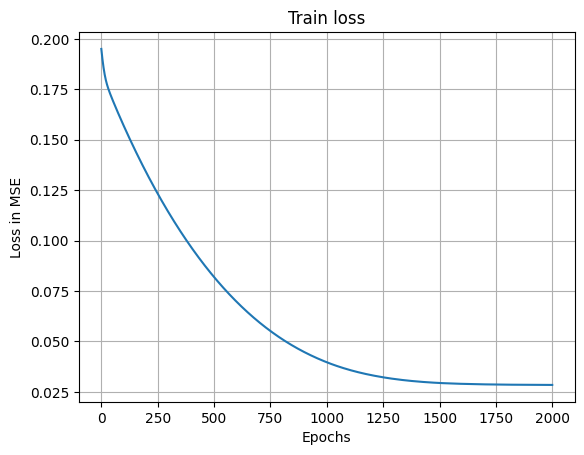

Final evaluation score is: -0.0799
['Final evaluation mse score is: 3.4102', 'Final evaluation mae score is: 1.4430', 'Final evaluation r2 score is: -0.0799', 'Final evaluation rmse score is: 1.8467']
Train evaluation score after: 0.0428 training.
['Train evaluation mse score is: 3.4164', 'Train evaluation mae score is: 1.4685', 'Train evaluation r2 score is: 0.0428', 'Train evaluation rmse score is: 1.8483']


In [270]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch_geometric.nn import to_hetero

def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title("Train loss")
    plt.ylabel("Loss in MSE")
    plt.xlabel("Epochs")
    plt.grid()
    plt.show()

def refit(train_loader, hyperparameters):
    model, loss_list = train_k(train_loader, hyperparameters)
    return model, loss_list

def reevaluate(model, test_loader):
    score, sec_scores = evaluate_k(model, test_loader)
    return score, sec_scores#, (pred_target_values, true_target_values)
    
def final_train_and_evaluate(train_loader, test_loader, hyperparameters):
    global train_indices, test_indices
    model, loss_list = refit(copy.deepcopy(train_loader), hyperparameters)
    plot_loss(loss_list)
    train_score_after_training, sec_train_scores = reevaluate(model, copy.deepcopy(train_loader))
    score, sec_scores = reevaluate(model, test_loader)
    
    print(f"Final evaluation score is: {format(score, '.4f')}")
    print([f"Final evaluation {key} score is: {format(sec_scores[key], '.4f')}" for key in sec_scores])
    print(f"Train evaluation score after: {format(train_score_after_training, '.4f')} training.")
    print([f"Train evaluation {key} score is: {format(sec_train_scores[key], '.4f')}" for key in sec_train_scores])
    return loss_list #, (pred_target_values, true_target_values)

train_index = train_indices
test_index = test_indices
train_loader, test_loader = get_loaders(data, train_index, test_index, best_hyperparams["batch_size"])
training_score_before_training, sec_train_scores = reevaluate(best_hyperparams["model"], copy.deepcopy(train_loader))
print(f"Train evaluation score before: {format(training_score_before_training, '.4f')} training.")
print([f"Train evaluation {key} score is: {format(sec_train_scores[key], '.4f')}" for key in sec_train_scores])
loss_list = final_train_and_evaluate(train_loader, test_loader, best_hyperparams)

In [267]:
def get_model_size(hidden_dim):
    return 29*hidden_dim*2+hidden_dim*2
get_model_size(1)

60

In [97]:
pd.DataFrame( pred_target_values.cpu().numpy(), true_target_values.cpu().numpy()).head(100)

,0
-1.288371,-1.335189
-2.403417,-1.365645
-1.203532,-0.418303
-1.716225,-1.233653
-0.846573,-1.079178
...,...
-0.681252,-1.465579
-2.385594,-1.486140
-0.569868,-1.326131
-1.333348,-1.139820


## Test for Cross validaion index translator

In [50]:
k_fold = KFold(n_splits=5)
for (idx, val_idx) in k_fold.split(train_indices):
    print(30*"#")
    # print(train_indices[idx])
    # print(train_indices[val_idx])

    ## Test
    sorted_k_folds = torch.sort(torch.cat([train_indices[idx], train_indices[val_idx]], 0))[0]
    sorted_all_indices = torch.sort(train_indices)[0]
    mathing_indices = (sorted_all_indices == sorted_k_folds).sum()
    print(mathing_indices == train_indices.shape[0])

##############################
tensor(True)
##############################
tensor(True)
##############################
tensor(True)
##############################
tensor(True)
##############################
tensor(True)


## Empty GPU memory

In [166]:
del model, loss_fn, optim
torch._C._cuda_clearCublasWorkspaces()
torch._dynamo.reset()
import gc
gc.collect()
torch.cuda.empty_cache()

## Base model

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
##TODO change to train,. test val indices form above
X_train, X_test , y_train, y_test = train_test_split(model_and_target_features, target_labels, random_state=0)
standard_scaler = StandardScaler()
standard_scaler.fit(X_train)

X_train, X_test = standard_scaler.transform(X_train), standard_scaler.transform(X_test)

In [280]:
model

array([[5.5100e+02, 3.0016e-02, 3.3800e+02, ..., 4.0000e+00, 1.2000e+01,
        0.0000e+00],
       [2.4000e+01, 3.0016e-02, 7.1000e+01, ..., 4.0000e+00, 1.2000e+01,
        1.0000e+00],
       [1.5500e+02, 3.0016e-02, 7.1300e+02, ..., 4.0000e+00, 1.2000e+01,
        1.0000e+00],
       ...,
       [6.3300e+02, 3.0016e-02, 6.1000e+02, ..., 4.0000e+00, 1.3000e+01,
        1.0000e+00],
       [6.3600e+02, 3.0016e-02, 9.4100e+02, ..., 4.0000e+00, 1.3000e+01,
        1.0000e+00],
       [1.3600e+02, 3.0016e-02, 7.3300e+02, ..., 4.0000e+00, 1.2000e+01,
        1.0000e+00]])

In [277]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

base_model = MLPRegressor(hidden_layer_sizes=(20))
base_model.fit(X_train, y_train)

/home/dwalke/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=20)

In [278]:
from sklearn.metrics import root_mean_squared_error, r2_score
{
    "train_rmse":root_mean_squared_error(y_train, base_model.predict(X_train)),
    "train_r2":r2_score(y_train, base_model.predict(X_train)),
    "test_rmse": root_mean_squared_error(y_test, base_model.predict(X_test)),
    "test_r2":r2_score(y_test, base_model.predict(X_test))
}

{'train_rmse': 0.630041661641547,
 'train_r2': 0.2358449424336172,
 'test_rmse': 0.7127170857289105,
 'test_r2': 0.036665393902286736}

## Old code

In [ ]:
raise Exception("Keep cell outputs here")

In [133]:
# pivot_targets = pd.pivot_table(targets, values="LN_IC50", index=["SANGER_MODEL_ID"],
#                        columns=['DRUG_ID'])

# pd.merge(targets.loc[:, ["SANGER_MODEL_ID",'PUTATIVE_TARGET', 'PATHWAY_NAME', 'MIN_CONC', 'MAX_CONC']], pivot_targets, on=["SANGER_MODEL_ID","SANGER_MODEL_ID"])

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,...,2175,2177,2359,2360,2361,2362,2438,2439,2498,2499
0,GDSC2,401,18945558,683667,PFSK-1,SIDM01132,MB,1003,Camptothecin,TOP1,...,NaN,2.366388,NaN,NaN,NaN,NaN,NaN,NaN,7.846626,10.613759
1,GDSC2,401,18945796,684052,A673,SIDM00848,UNCLASSIFIED,1003,Camptothecin,TOP1,...,NaN,1.723942,5.240599,4.432934,4.716167,4.285911,7.793623,9.156372,7.568813,7.063871
2,GDSC2,401,18946078,684057,ES5,SIDM00263,UNCLASSIFIED,1003,Camptothecin,TOP1,...,4.879849,1.901766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GDSC2,401,18946335,684059,ES7,SIDM00269,UNCLASSIFIED,1003,Camptothecin,TOP1,...,NaN,2.133421,4.578782,3.893851,3.137208,2.719145,8.871504,9.302207,6.655762,9.441838
4,GDSC2,401,18946617,684062,EW-11,SIDM00203,UNCLASSIFIED,1003,Camptothecin,TOP1,...,NaN,1.880307,5.137711,4.863771,5.007426,5.389040,10.462131,9.801610,8.228663,10.817398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242031,GDSC2,401,19187490,1659928,SNU-175,SIDM00216,COREAD,2499,N-acetyl cysteine,Metabolism,...,NaN,1.310061,5.423870,5.397164,5.401524,4.973343,9.264933,9.211173,7.445385,10.134495
242032,GDSC2,401,19187943,1660034,SNU-407,SIDM00214,COREAD,2499,N-acetyl cysteine,Metabolism,...,NaN,2.628609,5.042005,5.055076,4.918666,4.122141,11.121460,9.528520,8.344004,8.575555
242033,GDSC2,401,19188201,1660035,SNU-61,SIDM00194,COREAD,2499,N-acetyl cysteine,Metabolism,...,NaN,2.866949,6.130028,5.649833,4.392357,4.382946,10.879932,10.092187,7.743591,10.520666
242034,GDSC2,401,19188741,1674021,SNU-C5,SIDM00498,COREAD,2499,N-acetyl cysteine,Metabolism,...,NaN,2.653533,6.151265,6.022426,5.661197,4.820414,9.652950,10.181355,7.305220,10.701430


In [79]:
# ~pivot_targets.isnull()

DRUG_ID,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,...,2175,2177,2359,2360,2361,2362,2438,2439,2498,2499
SANGER_MODEL_ID,,,,,,,,,,,,,,,,,,,,,
SIDM00003,True,True,True,True,True,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
SIDM00023,True,False,False,False,True,True,True,True,True,True,...,True,True,False,False,False,False,False,False,False,False
SIDM00040,True,False,False,False,True,True,True,True,True,True,...,True,True,False,False,False,False,False,False,False,False
SIDM00041,True,False,False,False,True,True,True,True,True,True,...,True,True,False,False,False,False,False,False,False,False
SIDM00042,True,True,True,True,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM01248,True,True,True,True,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,True,True
SIDM01251,True,True,True,True,True,False,False,True,True,True,...,False,True,True,True,True,True,True,True,True,True
SIDM01259,True,True,True,True,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,True,True


## TODO

Drug- same drug on different cell models 1803, 1804
-different ids but same name
- Test edge index, test MLPwith lower complexity with grid search
Occurrs 9 times

## Questions
- Which features from mutations and genes I listed are irrelevant? If unknown pick all but probably I have some that does not make sense to include
  => Main goal: Just run with all
  (=> List with classical oncogenes, tummor suppressor genes)
- What is our goal/baseline? => feature selector from Johannes or paper https://academic.oup.com/bib/article/23/3/bbac100/6554594 (can create one but probably you have one)
- Which metric? IC 50 -> root mean squared error, R2-> 0.9 / 0.96
- Label as LN_IC50? IC50
- Defaul test dataset oder k-fold CV? 10 fold vs LOO-CV? 
- Depth vs Breadth? Bei dem Drug bleiben und versuchen zu verbessern (neue Architekturen, Batching etc) oder Lieber den kompletten graphen mit allen drugs und ziel edge attribute regression? Lieber ersteres da unabhängigkeit zwischen medikamenten
- Edge regression task preferred?:
x = ...  # Node feature matrix: [num_nodes, num_features]
edge_index = ... # Edge indices: [2, num_edges
- What is the goal paper for johannes]

src, dst = edge_index
score = (x[src] * x[dst]).sum(dim=-1)

loss = F.cross_entropy(score, data.edge_label)  # Classification
loss = F.mse_loss(score, data.edge_value)  # Regression

## Problems
	
 CUDA allocation error in training
 
 duplicate model_id + gene_id
 model_name	model_id	symbol	gene_id	chr_name	chr_start	chr_end	total_copy_number	minor_copy_number	loh	...	seg_mean	gene_mean	num_targets	focal	breakpoints	num_snps	gatk_mean_log2_copy_ratio	comment	source	data_type
0	MEC-1	SIDM00001	ABCB1	SIDG00064	chr7	87503966	87600461	3.0	1.0	False	...	0.599167	0.414125	28.0	False	0.0	1124.0	0.574127	POOR GOF (70.4%)	Sanger	WES
844	MEC-1	SIDM00001	ABCB1	SIDG00064	chr7	87503966	87600461	3.0	1.0	False	...	0.551774	0.692527	

-> pre-filter? highest POF in comment? or take both?